In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
import sys
sys.path.append('../dataset')
import get_funsd


In [4]:
funsd = get_funsd.CustomFunsdDataset('../dataset/')
funsd.split_generators()

In [5]:
funsd

CustomFunsdDataset:
DatasetDict({
    train: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 149}),
    test: Dataset({features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags','line_ids','linkings','image','image_name'], num_rows: 50})
})

In [6]:
label_map = {
    0: 'O',
    1: 'B-HEADER',
    2: 'I-HEADER',
    3: 'B-QUESTION',
    4: 'I-QUESTION',
    5: 'B-ANSWER', 
    6: 'I-ANSWER'}

In [7]:
funsd['train'][0].keys()

dict_keys(['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'])

In [8]:
from datasets import Dataset, DatasetDict

funsd_train_dataset = Dataset.from_dict({
    "id": [entry["id"] for entry in funsd["train"]],
    "tokens": [entry["tokens"] for entry in funsd["train"]],
    "ner_boxes": [entry["ner_boxes"] for entry in funsd["train"]],
    "bboxes": [entry["bboxes"] for entry in funsd["train"]],
    "ner_tags": [entry["ner_tags"] for entry in funsd["train"]],
    "line_ids": [entry["line_ids"] for entry in funsd["train"]],
    "linkings": [entry["linkings"] for entry in funsd["train"]],
    "image": [entry["image"] for entry in funsd["train"]],
    "image_name": [entry["image_name"] for entry in funsd["train"]],
})

funsd_test_dataset = Dataset.from_dict({
    "id": [entry["id"] for entry in funsd["test"]],
    "tokens": [entry["tokens"] for entry in funsd["test"]],
    "ner_boxes": [entry["ner_boxes"] for entry in funsd["test"]],
    "bboxes": [entry["bboxes"] for entry in funsd["test"]],
    "ner_tags": [entry["ner_tags"] for entry in funsd["test"]],
    "line_ids": [entry["line_ids"] for entry in funsd["test"]],
    "linkings": [entry["linkings"] for entry in funsd["test"]],
    "image": [entry["image"] for entry in funsd["test"]],
    "image_name": [entry["image_name"] for entry in funsd["test"]],
})

# Optionally, you can create a DatasetDict if you have train/test splits
dataset = DatasetDict({
    "train": funsd_train_dataset,
    'test': funsd_test_dataset
})


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_boxes', 'bboxes', 'ner_tags', 'line_ids', 'linkings', 'image', 'image_name'],
        num_rows: 50
    })
})

In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def normalize_box(bbox, width, height):
    return [
        bbox[0] / width * 1000,  # x1
        bbox[1] / height * 1000, # y1
        bbox[2] / width * 1000,  # x2
        bbox[3] / height * 1000, # y2
    ]


In [12]:
example = dataset['train'][0]
normalize_box(unnormalize_box(example['bboxes'][0], example['image'].width, example['image'].height), example['image'].width, example['image'].height), example['bboxes'][0]

([292.0, 91.0, 376.0, 175.0], [292, 91, 376, 175])

In [13]:

import numpy as np
def make_dataset(documents):
    images = documents['image']
    
    rgb_images = list(map(lambda img: img.convert('RGB'), images))
  
    words = documents['tokens']
    
    boxes = documents['bboxes'] ## token boxes normalized below
    
    word_labels = documents['ner_tags']
    
    normalized_boxes = []

    # Normalize the boxes by image width and height
    for i in range(len(boxes)):
        normalized_boxes.append([])
        for j in range(len(boxes[i])):
            normalized_boxes[-1].append(normalize_box(boxes[i][j], images[i].width, images[i].height))

    encoding = processor(rgb_images, words, boxes=normalized_boxes, word_labels=word_labels,
                         truncation=True, padding="max_length", return_offsets_mapping=True)
    
    encoding.pop('offset_mapping')

    return encoding

In [14]:
cols = funsd_train_dataset.column_names



Standardization: Many popular image classification models, like AlexNet, ResNet, and Vision Transformers, originally used 224x224 as a default input size. It has since become a standard, simplifying the process of reusing pre-trained models and ensuring consistency across various tasks.

Computational Efficiency: A size of 224x224 provides a good balance between image detail and computational cost. If images were too large, the model would require significantly more memory and processing power, but if they were too small, important details could be lost. 224x224 strikes a balance where enough spatial information is preserved while keeping the model efficient.

Training and Pre-training: Many models, including LayoutLMv3, are pre-trained on large datasets like ImageNet, where images are typically resized to 224x224. To take advantage of this pre-training and transfer learning, using the same input size ensures compatibility with the pre-trained weights and architectures.

224x224 is automated by layoutlm3

Bounding boxes: Stay on a 0-1000 scale to maintain relative spatial positioning of text or entities in the document.
Images: Resized to 224x224 pixels to meet the input size requirement of the visual part of the model.

In [15]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})
train_dataset = dataset["train"].map(
    make_dataset,
    batched=True,
    remove_columns = cols,
    features=features)

Map: 100%|██████████| 149/149 [00:01<00:00, 76.14 examples/s]


In [16]:
test_dataset = dataset["test"].map(
    make_dataset,
    batched=True,
    remove_columns = cols,
    features=features)

Map: 100%|██████████| 50/50 [00:00<00:00, 78.52 examples/s]


In [17]:
print(processor.tokenizer.decode(train_dataset[0]["input_ids"]))

<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><pa

In [18]:
train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [19]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)


pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [20]:
c=0
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())
  c+=1
  if c>10:break

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5


In [21]:
from evaluate import load 
metric = load("seqeval")  # Replace with the actual metric name


In [22]:
label_list = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

In [23]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [24]:
label_map_reversed = {v: k for k, v in label_map.items()} 


In [25]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator
import optuna
import os
from transformers import LayoutLMv3ForTokenClassification
from transformers.trainer_callback import TrainerCallback


hyperparameter_dict = {}

def objective(trial):
    model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                             id2label=label_map,
                                                             label2id=label_map_reversed).to(device)
    
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    batch_size = 2

    model.config.hidden_dropout_prob = dropout
    model.config.attention_probs_dropout_prob = dropout

    trial_output_dir = f'./results/'
    training_args = TrainingArguments(
        output_dir=trial_output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=20,  # Increased for demonstration
        weight_decay=weight_decay,
        logging_steps=10,
        evaluation_strategy="epoch",
        metric_for_best_model="eval_f1",
        load_best_model_at_end=True,
        save_strategy="epoch",
        save_total_limit=1
    )

    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset.select(range(119)),
        eval_dataset=train_dataset.select(range(119, len(train_dataset))),
        tokenizer=processor,
        data_collator=default_data_collator,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )

    train_result = trainer.train()
    eval_results = trainer.evaluate()
    
    hyperparameter_dict[trial.number] = {
        "final_eval_results": eval_results,
        "training_history": train_result.metrics,
        "hyperparameters": {
            "dropout": dropout,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
        }
    }
    
    return eval_results["eval_f1"]

In [26]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-10-16 13:00:06,202] A new study created in memory with name: no-name-5570f525-16c5-41fa-942c-4cce49b93d52
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/1200 [00:00<?, ?it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  1%|          | 11/1200 [00:02<03:50,  5.16it/s]

{'loss': 1.8453, 'grad_norm': 5.354772567749023, 'learning_rate': 5.351919723374885e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:42,  5.30it/s]

{'loss': 1.2519, 'grad_norm': 11.254236221313477, 'learning_rate': 5.3069456080524065e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:39,  5.32it/s]

{'loss': 1.1225, 'grad_norm': 10.95771312713623, 'learning_rate': 5.2619714927299286e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:37,  5.32it/s]

{'loss': 0.9217, 'grad_norm': 20.388324737548828, 'learning_rate': 5.216997377407451e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:35,  5.32it/s]

{'loss': 1.2186, 'grad_norm': 7.611330509185791, 'learning_rate': 5.172023262084973e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:12,  5.93it/s]

{'loss': 0.7249, 'grad_norm': 8.27083683013916, 'learning_rate': 5.127049146762495e-05, 'epoch': 1.0}


                                                 
  5%|▌         | 60/1200 [00:12<03:12,  5.93it/s]

{'eval_loss': 0.953833818435669, 'eval_precision': 0.5879556259904913, 'eval_recall': 0.6733212341197822, 'eval_f1': 0.6277495769881557, 'eval_accuracy': 0.6683194154488518, 'eval_runtime': 1.0649, 'eval_samples_per_second': 28.171, 'eval_steps_per_second': 14.085, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:20<04:26,  4.24it/s]

{'loss': 0.6963, 'grad_norm': 19.627113342285156, 'learning_rate': 5.082075031440017e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:22<03:31,  5.29it/s]

{'loss': 0.7426, 'grad_norm': 12.470423698425293, 'learning_rate': 5.037100916117539e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:24<03:27,  5.35it/s]

{'loss': 0.8465, 'grad_norm': 6.9759039878845215, 'learning_rate': 4.992126800795061e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:25<03:29,  5.26it/s]

{'loss': 0.7157, 'grad_norm': 6.783536911010742, 'learning_rate': 4.947152685472583e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:27<03:16,  5.53it/s]

{'loss': 0.6643, 'grad_norm': 7.743534088134766, 'learning_rate': 4.902178570150105e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:29<02:47,  6.46it/s]

{'loss': 0.6927, 'grad_norm': 13.585070610046387, 'learning_rate': 4.857204454827627e-05, 'epoch': 2.0}


                                                  
 10%|█         | 120/1200 [00:30<02:47,  6.46it/s]

{'eval_loss': 0.8166894912719727, 'eval_precision': 0.6351249053747161, 'eval_recall': 0.7613430127041743, 'eval_f1': 0.6925299215848122, 'eval_accuracy': 0.7239039665970772, 'eval_runtime': 0.9929, 'eval_samples_per_second': 30.214, 'eval_steps_per_second': 15.107, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:40<04:30,  3.95it/s]

{'loss': 0.5925, 'grad_norm': 11.340744972229004, 'learning_rate': 4.812230339505149e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:42<03:04,  5.73it/s]

{'loss': 0.4178, 'grad_norm': 11.001412391662598, 'learning_rate': 4.7672562241826705e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:44<03:10,  5.50it/s]

{'loss': 0.5099, 'grad_norm': 11.145115852355957, 'learning_rate': 4.7222821088601925e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:46<03:18,  5.24it/s]

{'loss': 0.6785, 'grad_norm': 7.673036098480225, 'learning_rate': 4.6773079935377146e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:48<03:15,  5.28it/s]

{'loss': 0.4801, 'grad_norm': 6.93385124206543, 'learning_rate': 4.6323338782152366e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:49<02:47,  6.07it/s]

{'loss': 0.6603, 'grad_norm': 9.419974327087402, 'learning_rate': 4.587359762892759e-05, 'epoch': 3.0}


                                                  
 15%|█▌        | 180/1200 [00:50<02:47,  6.07it/s]

{'eval_loss': 0.7446023225784302, 'eval_precision': 0.6943521594684385, 'eval_recall': 0.7586206896551724, 'eval_f1': 0.7250650477016479, 'eval_accuracy': 0.7776617954070981, 'eval_runtime': 1.0887, 'eval_samples_per_second': 27.555, 'eval_steps_per_second': 13.778, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [01:01<04:36,  3.65it/s]

{'loss': 0.5013, 'grad_norm': 11.889118194580078, 'learning_rate': 4.542385647570281e-05, 'epoch': 3.17}


 17%|█▋        | 200/1200 [01:03<03:07,  5.35it/s]

{'loss': 0.4598, 'grad_norm': 5.971839904785156, 'learning_rate': 4.497411532247803e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [01:05<03:08,  5.25it/s]

{'loss': 0.3489, 'grad_norm': 11.574615478515625, 'learning_rate': 4.452437416925324e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [01:06<02:53,  5.65it/s]

{'loss': 0.4702, 'grad_norm': 5.595740795135498, 'learning_rate': 4.407463301602846e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [01:08<03:01,  5.35it/s]

{'loss': 0.4614, 'grad_norm': 7.06595516204834, 'learning_rate': 4.362489186280368e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:10<02:40,  5.99it/s]

{'loss': 0.3454, 'grad_norm': 59.66426086425781, 'learning_rate': 4.317515070957891e-05, 'epoch': 4.0}


                                                  
 20%|██        | 240/1200 [01:11<02:40,  5.99it/s]

{'eval_loss': 1.013518214225769, 'eval_precision': 0.6517128874388255, 'eval_recall': 0.7250453720508166, 'eval_f1': 0.686426116838488, 'eval_accuracy': 0.7181628392484343, 'eval_runtime': 1.0675, 'eval_samples_per_second': 28.103, 'eval_steps_per_second': 14.051, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:19<04:08,  3.81it/s]

{'loss': 0.3244, 'grad_norm': 8.240724563598633, 'learning_rate': 4.2725409556354124e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:21<02:49,  5.55it/s]

{'loss': 0.3177, 'grad_norm': 14.808930397033691, 'learning_rate': 4.2275668403129344e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:23<02:39,  5.82it/s]

{'loss': 0.2712, 'grad_norm': 6.973426818847656, 'learning_rate': 4.1825927249904565e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:25<02:52,  5.32it/s]

{'loss': 0.3039, 'grad_norm': 15.691638946533203, 'learning_rate': 4.1376186096679785e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:27<02:54,  5.21it/s]

{'loss': 0.4838, 'grad_norm': 8.328179359436035, 'learning_rate': 4.0926444943455e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:28<02:25,  6.17it/s]

{'loss': 0.3179, 'grad_norm': 5.347484588623047, 'learning_rate': 4.047670379023022e-05, 'epoch': 5.0}


                                                  
 25%|██▌       | 300/1200 [01:29<02:25,  6.17it/s]

{'eval_loss': 0.9241714477539062, 'eval_precision': 0.717948717948718, 'eval_recall': 0.7622504537205081, 'eval_f1': 0.7394366197183098, 'eval_accuracy': 0.7669624217118998, 'eval_runtime': 1.0652, 'eval_samples_per_second': 28.163, 'eval_steps_per_second': 14.081, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:39<04:07,  3.59it/s]

{'loss': 0.2227, 'grad_norm': 4.656594276428223, 'learning_rate': 4.002696263700545e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:41<02:23,  6.13it/s]

{'loss': 0.195, 'grad_norm': 5.92510461807251, 'learning_rate': 3.957722148378066e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:42<02:42,  5.36it/s]

{'loss': 0.2263, 'grad_norm': 13.975259780883789, 'learning_rate': 3.912748033055588e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:44<02:21,  6.08it/s]

{'loss': 0.2174, 'grad_norm': 4.77292537689209, 'learning_rate': 3.86777391773311e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:46<02:07,  6.67it/s]

{'loss': 0.2445, 'grad_norm': 7.253133773803711, 'learning_rate': 3.822799802410632e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:47<02:03,  6.78it/s]

{'loss': 0.2189, 'grad_norm': 6.214419364929199, 'learning_rate': 3.7778256870881536e-05, 'epoch': 6.0}


                                                  
 30%|███       | 360/1200 [01:48<02:03,  6.78it/s]

{'eval_loss': 0.8415888547897339, 'eval_precision': 0.7001661129568106, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7311361665221162, 'eval_accuracy': 0.7669624217118998, 'eval_runtime': 0.8402, 'eval_samples_per_second': 35.706, 'eval_steps_per_second': 17.853, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:57<03:37,  3.82it/s]

{'loss': 0.1881, 'grad_norm': 6.50678825378418, 'learning_rate': 3.732851571765676e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:59<02:36,  5.24it/s]

{'loss': 0.1332, 'grad_norm': 14.519503593444824, 'learning_rate': 3.6878774564431984e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [02:01<02:34,  5.25it/s]

{'loss': 0.1546, 'grad_norm': 5.886096477508545, 'learning_rate': 3.6429033411207204e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [02:03<02:33,  5.20it/s]

{'loss': 0.2304, 'grad_norm': 6.561837196350098, 'learning_rate': 3.597929225798242e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [02:05<02:33,  5.15it/s]

{'loss': 0.1198, 'grad_norm': 9.058588027954102, 'learning_rate': 3.552955110475764e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [02:06<02:12,  5.90it/s]

{'loss': 0.1306, 'grad_norm': 8.496787071228027, 'learning_rate': 3.507980995153286e-05, 'epoch': 7.0}


                                                  
 35%|███▌      | 420/1200 [02:07<02:12,  5.90it/s]

{'eval_loss': 0.9228404760360718, 'eval_precision': 0.7861524978089395, 'eval_recall': 0.8139745916515426, 'eval_f1': 0.799821667409719, 'eval_accuracy': 0.8021920668058455, 'eval_runtime': 1.099, 'eval_samples_per_second': 27.298, 'eval_steps_per_second': 13.649, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [02:15<03:21,  3.81it/s]

{'loss': 0.1114, 'grad_norm': 7.190537929534912, 'learning_rate': 3.463006879830808e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [02:17<02:30,  5.05it/s]

{'loss': 0.103, 'grad_norm': 4.721360683441162, 'learning_rate': 3.41803276450833e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:19<02:25,  5.16it/s]

{'loss': 0.1393, 'grad_norm': 0.769037127494812, 'learning_rate': 3.373058649185852e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:21<02:23,  5.16it/s]

{'loss': 0.1571, 'grad_norm': 4.181352138519287, 'learning_rate': 3.328084533863374e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:23<02:20,  5.18it/s]

{'loss': 0.0878, 'grad_norm': 2.080019950866699, 'learning_rate': 3.2831104185408955e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:25<02:03,  5.84it/s]

{'loss': 0.1424, 'grad_norm': 36.880435943603516, 'learning_rate': 3.2381363032184176e-05, 'epoch': 8.0}


                                                  
 40%|████      | 480/1200 [02:26<02:03,  5.84it/s]

{'eval_loss': 1.2034977674484253, 'eval_precision': 0.7043478260869566, 'eval_recall': 0.73502722323049, 'eval_f1': 0.7193605683836589, 'eval_accuracy': 0.7484342379958246, 'eval_runtime': 1.0707, 'eval_samples_per_second': 28.019, 'eval_steps_per_second': 14.009, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:34<03:03,  3.87it/s]

{'loss': 0.0667, 'grad_norm': 5.881538391113281, 'learning_rate': 3.1931621878959396e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:36<02:09,  5.42it/s]

{'loss': 0.0871, 'grad_norm': 6.7450079917907715, 'learning_rate': 3.148188072573462e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:38<02:10,  5.28it/s]

{'loss': 0.1343, 'grad_norm': 4.368633270263672, 'learning_rate': 3.103213957250984e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:40<02:00,  5.62it/s]

{'loss': 0.0698, 'grad_norm': 8.448609352111816, 'learning_rate': 3.058239841928506e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:42<01:59,  5.60it/s]

{'loss': 0.0919, 'grad_norm': 6.511219501495361, 'learning_rate': 3.013265726606028e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:43<01:41,  6.53it/s]

{'loss': 0.0829, 'grad_norm': 0.8573504090309143, 'learning_rate': 2.96829161128355e-05, 'epoch': 9.0}


                                                  
 45%|████▌     | 540/1200 [02:44<01:41,  6.53it/s]

{'eval_loss': 1.185291051864624, 'eval_precision': 0.7652329749103942, 'eval_recall': 0.7749546279491834, 'eval_f1': 0.7700631199278629, 'eval_accuracy': 0.784446764091858, 'eval_runtime': 1.0217, 'eval_samples_per_second': 29.364, 'eval_steps_per_second': 14.682, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:52<02:48,  3.85it/s]

{'loss': 0.0327, 'grad_norm': 10.804436683654785, 'learning_rate': 2.9233174959610716e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:54<02:04,  5.14it/s]

{'loss': 0.0434, 'grad_norm': 5.6131792068481445, 'learning_rate': 2.8783433806385937e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:56<02:00,  5.21it/s]

{'loss': 0.0749, 'grad_norm': 6.688580513000488, 'learning_rate': 2.8333692653161157e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:58<01:59,  5.16it/s]

{'loss': 0.0479, 'grad_norm': 4.311700344085693, 'learning_rate': 2.7883951499936378e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [03:00<01:58,  5.13it/s]

{'loss': 0.0679, 'grad_norm': 2.0555458068847656, 'learning_rate': 2.7434210346711595e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [03:02<01:41,  5.89it/s]

{'loss': 0.0848, 'grad_norm': 2.9088857173919678, 'learning_rate': 2.6984469193486815e-05, 'epoch': 10.0}


                                                  
 50%|█████     | 600/1200 [03:03<01:41,  5.89it/s]

{'eval_loss': 1.2187564373016357, 'eval_precision': 0.7537643932683791, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.7628865979381443, 'eval_accuracy': 0.7797494780793319, 'eval_runtime': 1.0873, 'eval_samples_per_second': 27.59, 'eval_steps_per_second': 13.795, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [03:11<02:36,  3.77it/s]

{'loss': 0.0427, 'grad_norm': 3.7610599994659424, 'learning_rate': 2.6534728040262032e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [03:13<01:54,  5.07it/s]

{'loss': 0.0442, 'grad_norm': 4.306715965270996, 'learning_rate': 2.6084986887037256e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [03:15<01:50,  5.17it/s]

{'loss': 0.0398, 'grad_norm': 2.7841527462005615, 'learning_rate': 2.5635245733812474e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [03:17<01:47,  5.19it/s]

{'loss': 0.0514, 'grad_norm': 5.0527448654174805, 'learning_rate': 2.5185504580587694e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [03:19<01:45,  5.18it/s]

{'loss': 0.0604, 'grad_norm': 11.738810539245605, 'learning_rate': 2.4735763427362915e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [03:21<01:32,  5.83it/s]

{'loss': 0.0426, 'grad_norm': 6.707899570465088, 'learning_rate': 2.4286022274138135e-05, 'epoch': 11.0}


                                                  
 55%|█████▌    | 660/1200 [03:22<01:32,  5.83it/s]

{'eval_loss': 1.2463184595108032, 'eval_precision': 0.7632508833922261, 'eval_recall': 0.7840290381125227, 'eval_f1': 0.7735004476275739, 'eval_accuracy': 0.7784446764091858, 'eval_runtime': 1.0501, 'eval_samples_per_second': 28.569, 'eval_steps_per_second': 14.285, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:29<02:09,  4.10it/s]

{'loss': 0.0193, 'grad_norm': 1.3741525411605835, 'learning_rate': 2.3836281120913352e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:31<01:42,  5.06it/s]

{'loss': 0.0273, 'grad_norm': 3.054515838623047, 'learning_rate': 2.3386539967688573e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:32<01:38,  5.17it/s]

{'loss': 0.0494, 'grad_norm': 2.5063300132751465, 'learning_rate': 2.2936798814463793e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:34<01:37,  5.13it/s]

{'loss': 0.0388, 'grad_norm': 4.482611656188965, 'learning_rate': 2.2487057661239014e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:36<01:35,  5.12it/s]

{'loss': 0.0369, 'grad_norm': 4.499859809875488, 'learning_rate': 2.203731650801423e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:38<01:21,  5.86it/s]

{'loss': 0.0604, 'grad_norm': 5.1352458000183105, 'learning_rate': 2.1587575354789455e-05, 'epoch': 12.0}


                                                  
 60%|██████    | 720/1200 [03:39<01:21,  5.86it/s]

{'eval_loss': 1.356932282447815, 'eval_precision': 0.7493333333333333, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7570722945666817, 'eval_accuracy': 0.7750521920668059, 'eval_runtime': 1.0805, 'eval_samples_per_second': 27.764, 'eval_steps_per_second': 13.882, 'epoch': 12.0}


 60%|██████    | 720/1200 [03:43<02:29,  3.21it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 223.9155, 'train_samples_per_second': 10.629, 'train_steps_per_second': 5.359, 'train_loss': 0.3306633373308513, 'epoch': 12.0}


100%|██████████| 15/15 [00:01<00:00, 14.59it/s]
[I 2024-10-16 13:03:52,752] Trial 0 finished with value: 0.799821667409719 and parameters: {'dropout': 0.28053364384970336, 'learning_rate': 5.396893838697363e-05, 'weight_decay': 0.0006091999069902721}. Best is trial 0 with value: 0.799821667409719.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:54,  5.06it/s]

{'loss': 1.8112, 'grad_norm': 5.974058628082275, 'learning_rate': 3.4604120717036854e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:47,  5.19it/s]

{'loss': 1.3307, 'grad_norm': 6.636722087860107, 'learning_rate': 3.431332978664158e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:05<03:30,  5.55it/s]

{'loss': 1.1844, 'grad_norm': 13.96107006072998, 'learning_rate': 3.402253885624632e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:23,  5.68it/s]

{'loss': 0.987, 'grad_norm': 28.59563446044922, 'learning_rate': 3.373174792585105e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:30,  5.45it/s]

{'loss': 1.2733, 'grad_norm': 15.029025077819824, 'learning_rate': 3.3440956995455786e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<02:54,  6.54it/s]

{'loss': 0.6918, 'grad_norm': 10.927900314331055, 'learning_rate': 3.315016606506051e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<02:54,  6.54it/s]

{'eval_loss': 0.947752058506012, 'eval_precision': 0.5701219512195121, 'eval_recall': 0.6787658802177858, 'eval_f1': 0.6197183098591549, 'eval_accuracy': 0.673277661795407, 'eval_runtime': 1.0242, 'eval_samples_per_second': 29.29, 'eval_steps_per_second': 14.645, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:16<04:09,  4.53it/s]

{'loss': 0.684, 'grad_norm': 12.339493751525879, 'learning_rate': 3.2859375134665246e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:18<03:42,  5.03it/s]

{'loss': 0.7775, 'grad_norm': 7.904703140258789, 'learning_rate': 3.256858420426998e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:20<03:41,  5.00it/s]

{'loss': 0.9527, 'grad_norm': 10.376520156860352, 'learning_rate': 3.227779327387471e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:22<03:33,  5.15it/s]

{'loss': 0.7501, 'grad_norm': 9.524813652038574, 'learning_rate': 3.1987002343479445e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:24<03:30,  5.16it/s]

{'loss': 0.5557, 'grad_norm': 12.390046119689941, 'learning_rate': 3.169621141308418e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:25<02:47,  6.45it/s]

{'loss': 0.7208, 'grad_norm': 29.726694107055664, 'learning_rate': 3.140542048268891e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:26<02:47,  6.45it/s]

{'eval_loss': 0.9200800061225891, 'eval_precision': 0.6464566929133858, 'eval_recall': 0.7450090744101633, 'eval_f1': 0.6922428330522765, 'eval_accuracy': 0.7176409185803758, 'eval_runtime': 1.0278, 'eval_samples_per_second': 29.189, 'eval_steps_per_second': 14.594, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:36<04:57,  3.59it/s]

{'loss': 0.6695, 'grad_norm': 6.616617202758789, 'learning_rate': 3.1114629552293645e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:38<03:31,  5.00it/s]

{'loss': 0.4681, 'grad_norm': 13.763435363769531, 'learning_rate': 3.082383862189837e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:40<03:25,  5.10it/s]

{'loss': 0.4738, 'grad_norm': 8.751859664916992, 'learning_rate': 3.0533047691503105e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:42<03:27,  5.01it/s]

{'loss': 0.6558, 'grad_norm': 6.096288681030273, 'learning_rate': 3.0242256761107838e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:44<03:26,  4.98it/s]

{'loss': 0.4419, 'grad_norm': 9.011942863464355, 'learning_rate': 2.9951465830712568e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:46<02:57,  5.76it/s]

{'loss': 0.656, 'grad_norm': 17.646329879760742, 'learning_rate': 2.96606749003173e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:47<02:57,  5.76it/s]

{'eval_loss': 0.6983688473701477, 'eval_precision': 0.6730132450331126, 'eval_recall': 0.7377495462794919, 'eval_f1': 0.7038961038961039, 'eval_accuracy': 0.7774008350730689, 'eval_runtime': 1.0981, 'eval_samples_per_second': 27.32, 'eval_steps_per_second': 13.66, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:54<04:08,  4.06it/s]

{'loss': 0.494, 'grad_norm': 12.607215881347656, 'learning_rate': 2.9369883969922034e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:55<02:56,  5.65it/s]

{'loss': 0.5053, 'grad_norm': 4.874766826629639, 'learning_rate': 2.9079093039526767e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:57<03:15,  5.06it/s]

{'loss': 0.4549, 'grad_norm': 12.837896347045898, 'learning_rate': 2.8788302109131497e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:59<03:12,  5.07it/s]

{'loss': 0.329, 'grad_norm': 5.754108905792236, 'learning_rate': 2.849751117873623e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [01:01<03:11,  5.07it/s]

{'loss': 0.4674, 'grad_norm': 11.828466415405273, 'learning_rate': 2.8206720248340963e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:03<02:46,  5.75it/s]

{'loss': 0.2806, 'grad_norm': 12.011472702026367, 'learning_rate': 2.7915929317945696e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:04<02:46,  5.75it/s]

{'eval_loss': 0.7686794996261597, 'eval_precision': 0.7294642857142857, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7353735373537355, 'eval_accuracy': 0.7797494780793319, 'eval_runtime': 1.0847, 'eval_samples_per_second': 27.657, 'eval_steps_per_second': 13.829, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:10<03:41,  4.28it/s]

{'loss': 0.2388, 'grad_norm': 4.538827896118164, 'learning_rate': 2.7625138387550426e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:12<03:05,  5.05it/s]

{'loss': 0.272, 'grad_norm': 11.792872428894043, 'learning_rate': 2.733434745715516e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:14<03:04,  5.03it/s]

{'loss': 0.2572, 'grad_norm': 7.222481727600098, 'learning_rate': 2.7043556526759893e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:16<03:03,  5.00it/s]

{'loss': 0.3207, 'grad_norm': 20.41750144958496, 'learning_rate': 2.675276559636463e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:18<03:02,  4.99it/s]

{'loss': 0.4309, 'grad_norm': 11.542840957641602, 'learning_rate': 2.6461974665969355e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:19<02:37,  5.73it/s]

{'loss': 0.3533, 'grad_norm': 12.677498817443848, 'learning_rate': 2.617118373557409e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:20<02:37,  5.73it/s]

{'eval_loss': 0.8198238611221313, 'eval_precision': 0.7298494242692648, 'eval_recall': 0.7477313974591652, 'eval_f1': 0.7386822052891081, 'eval_accuracy': 0.7779227557411273, 'eval_runtime': 1.0938, 'eval_samples_per_second': 27.428, 'eval_steps_per_second': 13.714, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:27<03:37,  4.09it/s]

{'loss': 0.2188, 'grad_norm': 11.174936294555664, 'learning_rate': 2.5880392805178825e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:29<02:56,  4.98it/s]

{'loss': 0.1977, 'grad_norm': 4.8990278244018555, 'learning_rate': 2.558960187478355e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:31<02:54,  4.98it/s]

{'loss': 0.3007, 'grad_norm': 26.874799728393555, 'learning_rate': 2.5298810944388288e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:33<02:52,  4.99it/s]

{'loss': 0.2136, 'grad_norm': 7.584812164306641, 'learning_rate': 2.500802001399302e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:35<02:49,  5.01it/s]

{'loss': 0.2494, 'grad_norm': 5.602842330932617, 'learning_rate': 2.4717229083597755e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:36<02:27,  5.69it/s]

{'loss': 0.2229, 'grad_norm': 5.592353343963623, 'learning_rate': 2.4426438153202484e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:38<02:27,  5.69it/s]

{'eval_loss': 0.755969226360321, 'eval_precision': 0.7174490699734278, 'eval_recall': 0.73502722323049, 'eval_f1': 0.7261317794710891, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 1.0867, 'eval_samples_per_second': 27.606, 'eval_steps_per_second': 13.803, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 370/1200 [01:45<03:58,  3.47it/s]

{'loss': 0.1936, 'grad_norm': 30.748096466064453, 'learning_rate': 2.4135647222807218e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:47<02:39,  5.14it/s]

{'loss': 0.1438, 'grad_norm': 11.424060821533203, 'learning_rate': 2.384485629241195e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:49<02:38,  5.11it/s]

{'loss': 0.1603, 'grad_norm': 8.876553535461426, 'learning_rate': 2.3554065362016684e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:51<02:35,  5.15it/s]

{'loss': 0.1828, 'grad_norm': 6.884470462799072, 'learning_rate': 2.3263274431621414e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:53<02:30,  5.25it/s]

{'loss': 0.1252, 'grad_norm': 3.8917243480682373, 'learning_rate': 2.2972483501226147e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:55<02:12,  5.90it/s]

{'loss': 0.1362, 'grad_norm': 17.479572296142578, 'learning_rate': 2.268169257083088e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:56<02:12,  5.90it/s]

{'eval_loss': 0.9619516730308533, 'eval_precision': 0.7607573149741824, 'eval_recall': 0.8021778584392014, 'eval_f1': 0.7809187279151942, 'eval_accuracy': 0.7779227557411273, 'eval_runtime': 1.0798, 'eval_samples_per_second': 27.783, 'eval_steps_per_second': 13.891, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [02:01<02:54,  4.40it/s]

{'loss': 0.1236, 'grad_norm': 4.6409173011779785, 'learning_rate': 2.2390901640435613e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [02:03<02:26,  5.19it/s]

{'loss': 0.0869, 'grad_norm': 10.815343856811523, 'learning_rate': 2.2100110710040343e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:05<02:22,  5.27it/s]

{'loss': 0.1628, 'grad_norm': 4.190219879150391, 'learning_rate': 2.1809319779645076e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:07<02:25,  5.07it/s]

{'loss': 0.1749, 'grad_norm': 3.9579479694366455, 'learning_rate': 2.151852884924981e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:09<02:21,  5.16it/s]

{'loss': 0.0943, 'grad_norm': 6.320433139801025, 'learning_rate': 2.122773791885454e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:10<02:01,  5.91it/s]

{'loss': 0.1194, 'grad_norm': 11.928174018859863, 'learning_rate': 2.0936946988459272e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:11<02:01,  5.91it/s]

{'eval_loss': 0.9137288331985474, 'eval_precision': 0.7468581687612208, 'eval_recall': 0.7549909255898367, 'eval_f1': 0.7509025270758123, 'eval_accuracy': 0.8001043841336117, 'eval_runtime': 1.0851, 'eval_samples_per_second': 27.648, 'eval_steps_per_second': 13.824, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:21<03:11,  3.69it/s]

{'loss': 0.077, 'grad_norm': 4.21559476852417, 'learning_rate': 2.0646156058064005e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:23<02:17,  5.07it/s]

{'loss': 0.0582, 'grad_norm': 2.4725918769836426, 'learning_rate': 2.035536512766874e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:25<02:16,  5.04it/s]

{'loss': 0.1437, 'grad_norm': 4.110073089599609, 'learning_rate': 2.006457419727347e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:27<02:15,  5.02it/s]

{'loss': 0.0808, 'grad_norm': 10.620137214660645, 'learning_rate': 1.97737832668782e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:29<02:12,  5.04it/s]

{'loss': 0.0926, 'grad_norm': 5.500711917877197, 'learning_rate': 1.9482992336482935e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:30<01:55,  5.70it/s]

{'loss': 0.1015, 'grad_norm': 0.9621412754058838, 'learning_rate': 1.9192201406087668e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:32<01:55,  5.70it/s]

{'eval_loss': 0.9215991497039795, 'eval_precision': 0.7580496780128795, 'eval_recall': 0.7477313974591652, 'eval_f1': 0.752855185015989, 'eval_accuracy': 0.7930584551148225, 'eval_runtime': 1.0661, 'eval_samples_per_second': 28.139, 'eval_steps_per_second': 14.07, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:38<02:39,  4.07it/s]

{'loss': 0.0438, 'grad_norm': 2.6477558612823486, 'learning_rate': 1.8901410475692398e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:40<02:07,  4.99it/s]

{'loss': 0.0466, 'grad_norm': 5.741765022277832, 'learning_rate': 1.861061954529713e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:42<02:05,  5.01it/s]

{'loss': 0.1044, 'grad_norm': 12.481898307800293, 'learning_rate': 1.8319828614901864e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:44<02:02,  5.07it/s]

{'loss': 0.0645, 'grad_norm': 6.9366984367370605, 'learning_rate': 1.8029037684506597e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:46<02:01,  5.01it/s]

{'loss': 0.1169, 'grad_norm': 5.264166355133057, 'learning_rate': 1.7738246754111327e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:48<01:44,  5.77it/s]

{'loss': 0.0962, 'grad_norm': 2.4588370323181152, 'learning_rate': 1.744745582371606e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:49<01:44,  5.77it/s]

{'eval_loss': 1.0640767812728882, 'eval_precision': 0.7459605026929982, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.7500000000000001, 'eval_accuracy': 0.7993215031315241, 'eval_runtime': 1.0948, 'eval_samples_per_second': 27.401, 'eval_steps_per_second': 13.701, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 610/1200 [02:54<02:29,  3.95it/s]

{'loss': 0.0657, 'grad_norm': 6.325389862060547, 'learning_rate': 1.715666489332079e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:56<01:53,  5.08it/s]

{'loss': 0.0533, 'grad_norm': 4.025105953216553, 'learning_rate': 1.6865873962925527e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:58<01:50,  5.16it/s]

{'loss': 0.0506, 'grad_norm': 1.970442295074463, 'learning_rate': 1.6575083032530256e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [03:00<01:47,  5.22it/s]

{'loss': 0.0703, 'grad_norm': 23.36878776550293, 'learning_rate': 1.628429210213499e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [03:02<01:48,  5.07it/s]

{'loss': 0.0778, 'grad_norm': 3.7901809215545654, 'learning_rate': 1.5993501171739723e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [03:04<01:31,  5.87it/s]

{'loss': 0.0512, 'grad_norm': 12.202472686767578, 'learning_rate': 1.5702710241344456e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [03:05<01:31,  5.87it/s]

{'eval_loss': 0.9820460081100464, 'eval_precision': 0.7700170357751278, 'eval_recall': 0.8203266787658802, 'eval_f1': 0.7943760984182777, 'eval_accuracy': 0.8115866388308977, 'eval_runtime': 1.0822, 'eval_samples_per_second': 27.722, 'eval_steps_per_second': 13.861, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:11<02:06,  4.20it/s]

{'loss': 0.0284, 'grad_norm': 3.339724063873291, 'learning_rate': 1.5411919310949186e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:13<01:43,  5.01it/s]

{'loss': 0.0285, 'grad_norm': 4.498363018035889, 'learning_rate': 1.5121128380553919e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:15<01:41,  5.00it/s]

{'loss': 0.0622, 'grad_norm': 3.3717267513275146, 'learning_rate': 1.483033745015865e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:17<01:40,  4.99it/s]

{'loss': 0.0523, 'grad_norm': 6.7671709060668945, 'learning_rate': 1.4539546519763384e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:19<01:37,  5.01it/s]

{'loss': 0.0496, 'grad_norm': 0.7392420768737793, 'learning_rate': 1.4248755589368115e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:21<01:23,  5.72it/s]

{'loss': 0.0538, 'grad_norm': 5.831087112426758, 'learning_rate': 1.3957964658972848e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:22<01:23,  5.72it/s]

{'eval_loss': 1.1562093496322632, 'eval_precision': 0.7967770814682185, 'eval_recall': 0.8076225045372051, 'eval_f1': 0.8021631365479945, 'eval_accuracy': 0.8006263048016702, 'eval_runtime': 1.0841, 'eval_samples_per_second': 27.673, 'eval_steps_per_second': 13.837, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:29<01:57,  4.00it/s]

{'loss': 0.0223, 'grad_norm': 4.651562213897705, 'learning_rate': 1.366717372857758e-05, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:31<01:32,  4.98it/s]

{'loss': 0.0393, 'grad_norm': 2.962683916091919, 'learning_rate': 1.3376382798182315e-05, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:33<01:29,  5.02it/s]

{'loss': 0.0674, 'grad_norm': 0.1505812108516693, 'learning_rate': 1.3085591867787044e-05, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:35<01:26,  5.08it/s]

{'loss': 0.0284, 'grad_norm': 0.34386274218559265, 'learning_rate': 1.2794800937391776e-05, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:37<01:24,  5.05it/s]

{'loss': 0.0215, 'grad_norm': 1.2763214111328125, 'learning_rate': 1.250401000699651e-05, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:38<01:12,  5.77it/s]

{'loss': 0.0649, 'grad_norm': 2.538374423980713, 'learning_rate': 1.2213219076601242e-05, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:39<01:12,  5.77it/s]

{'eval_loss': 1.141143560409546, 'eval_precision': 0.7851387645478961, 'eval_recall': 0.7958257713248639, 'eval_f1': 0.790446146913024, 'eval_accuracy': 0.8055845511482255, 'eval_runtime': 1.1001, 'eval_samples_per_second': 27.27, 'eval_steps_per_second': 13.635, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:48<01:50,  3.70it/s]

{'loss': 0.0203, 'grad_norm': 6.106093406677246, 'learning_rate': 1.1922428146205975e-05, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:50<01:20,  4.98it/s]

{'loss': 0.0729, 'grad_norm': 3.6302924156188965, 'learning_rate': 1.1631637215810707e-05, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:52<01:17,  5.04it/s]

{'loss': 0.0186, 'grad_norm': 0.042568374425172806, 'learning_rate': 1.134084628541544e-05, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:54<01:14,  5.07it/s]

{'loss': 0.015, 'grad_norm': 2.302838087081909, 'learning_rate': 1.1050055355020171e-05, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:56<01:13,  5.00it/s]

{'loss': 0.0237, 'grad_norm': 2.822500228881836, 'learning_rate': 1.0759264424624905e-05, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:57<01:04,  5.60it/s]

{'loss': 0.03, 'grad_norm': 7.236547470092773, 'learning_rate': 1.0468473494229636e-05, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:59<01:04,  5.60it/s]

{'eval_loss': 1.0858917236328125, 'eval_precision': 0.7690925426774483, 'eval_recall': 0.7767695099818511, 'eval_f1': 0.7729119638826185, 'eval_accuracy': 0.8034968684759917, 'eval_runtime': 1.0978, 'eval_samples_per_second': 27.328, 'eval_steps_per_second': 13.664, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [04:05<01:25,  4.08it/s]

{'loss': 0.0163, 'grad_norm': 5.10974645614624, 'learning_rate': 1.017768256383437e-05, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [04:07<01:06,  5.08it/s]

{'loss': 0.02, 'grad_norm': 1.4265602827072144, 'learning_rate': 9.8868916334391e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [04:09<01:04,  5.10it/s]

{'loss': 0.031, 'grad_norm': 0.16813866794109344, 'learning_rate': 9.596100703043834e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [04:11<01:02,  5.13it/s]

{'loss': 0.0233, 'grad_norm': 0.13233178853988647, 'learning_rate': 9.305309772648565e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [04:13<01:01,  4.99it/s]

{'loss': 0.0293, 'grad_norm': 5.04207181930542, 'learning_rate': 9.014518842253299e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [04:15<00:52,  5.73it/s]

{'loss': 0.0266, 'grad_norm': 21.15293312072754, 'learning_rate': 8.72372791185803e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:16<00:52,  5.73it/s]

{'eval_loss': 1.2205802202224731, 'eval_precision': 0.76875, 'eval_recall': 0.7813067150635209, 'eval_f1': 0.774977497749775, 'eval_accuracy': 0.7943632567849687, 'eval_runtime': 1.1062, 'eval_samples_per_second': 27.119, 'eval_steps_per_second': 13.56, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [04:22<01:08,  4.20it/s]

{'loss': 0.0199, 'grad_norm': 1.0851945877075195, 'learning_rate': 8.432936981462763e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [04:24<00:56,  4.96it/s]

{'loss': 0.0174, 'grad_norm': 1.5829299688339233, 'learning_rate': 8.142146051067495e-06, 'epoch': 15.33}


 78%|███████▊  | 930/1200 [04:26<00:53,  5.08it/s]

{'loss': 0.0079, 'grad_norm': 0.5156413316726685, 'learning_rate': 7.851355120672228e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [04:28<00:50,  5.11it/s]

{'loss': 0.0114, 'grad_norm': 0.5145080089569092, 'learning_rate': 7.5605641902769594e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [04:30<00:48,  5.11it/s]

{'loss': 0.0227, 'grad_norm': 7.767029762268066, 'learning_rate': 7.269773259881692e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [04:31<00:41,  5.81it/s]

{'loss': 0.0167, 'grad_norm': 0.7148140072822571, 'learning_rate': 6.978982329486424e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [04:32<00:41,  5.81it/s]

{'eval_loss': 1.2395236492156982, 'eval_precision': 0.7907801418439716, 'eval_recall': 0.809437386569873, 'eval_f1': 0.8, 'eval_accuracy': 0.8058455114822547, 'eval_runtime': 1.0706, 'eval_samples_per_second': 28.022, 'eval_steps_per_second': 14.011, 'epoch': 16.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 81%|████████  | 971/1200 [04:39<00:56,  4.08it/s]

{'loss': 0.0149, 'grad_norm': 0.1671876758337021, 'learning_rate': 6.688191399091157e-06, 'epoch': 16.17}


 82%|████████▏ | 981/1200 [04:41<00:43,  5.06it/s]

{'loss': 0.0144, 'grad_norm': 3.6101789474487305, 'learning_rate': 6.397400468695888e-06, 'epoch': 16.33}


 83%|████████▎ | 991/1200 [04:43<00:41,  5.00it/s]

{'loss': 0.0158, 'grad_norm': 3.4117813110351562, 'learning_rate': 6.106609538300621e-06, 'epoch': 16.5}


 83%|████████▎ | 1001/1200 [04:45<00:39,  4.99it/s]

{'loss': 0.0051, 'grad_norm': 0.025123367086052895, 'learning_rate': 5.815818607905353e-06, 'epoch': 16.67}


 84%|████████▍ | 1011/1200 [04:47<00:36,  5.12it/s]

{'loss': 0.0145, 'grad_norm': 4.383656024932861, 'learning_rate': 5.525027677510086e-06, 'epoch': 16.83}


 85%|████████▌ | 1020/1200 [04:49<00:32,  5.62it/s]

{'loss': 0.0059, 'grad_norm': 0.24621209502220154, 'learning_rate': 5.234236747114818e-06, 'epoch': 17.0}



 85%|████████▌ | 1020/1200 [04:50<00:32,  5.62it/s]

{'eval_loss': 1.2782745361328125, 'eval_precision': 0.7889667250437828, 'eval_recall': 0.8176043557168784, 'eval_f1': 0.8030303030303031, 'eval_accuracy': 0.8014091858037579, 'eval_runtime': 1.0846, 'eval_samples_per_second': 27.66, 'eval_steps_per_second': 13.83, 'epoch': 17.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 86%|████████▌ | 1031/1200 [04:58<00:44,  3.76it/s]

{'loss': 0.0176, 'grad_norm': 1.3009147644042969, 'learning_rate': 4.94344581671955e-06, 'epoch': 17.17}


 87%|████████▋ | 1041/1200 [05:00<00:31,  5.07it/s]

{'loss': 0.0192, 'grad_norm': 0.4381682574748993, 'learning_rate': 4.652654886324283e-06, 'epoch': 17.33}


 88%|████████▊ | 1051/1200 [05:02<00:29,  4.99it/s]

{'loss': 0.0171, 'grad_norm': 0.03719624504446983, 'learning_rate': 4.361863955929015e-06, 'epoch': 17.5}


 88%|████████▊ | 1061/1200 [05:04<00:27,  5.03it/s]

{'loss': 0.0068, 'grad_norm': 7.956671714782715, 'learning_rate': 4.071073025533747e-06, 'epoch': 17.67}


 89%|████████▉ | 1071/1200 [05:06<00:25,  5.08it/s]

{'loss': 0.0076, 'grad_norm': 2.0829503536224365, 'learning_rate': 3.7802820951384797e-06, 'epoch': 17.83}


 90%|█████████ | 1080/1200 [05:07<00:20,  5.79it/s]

{'loss': 0.0069, 'grad_norm': 0.34530043601989746, 'learning_rate': 3.489491164743212e-06, 'epoch': 18.0}



 90%|█████████ | 1080/1200 [05:08<00:20,  5.79it/s]

{'eval_loss': 1.2215934991836548, 'eval_precision': 0.7852706299911268, 'eval_recall': 0.8030852994555354, 'eval_f1': 0.794078061911171, 'eval_accuracy': 0.8053235908141962, 'eval_runtime': 1.073, 'eval_samples_per_second': 27.958, 'eval_steps_per_second': 13.979, 'epoch': 18.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 91%|█████████ | 1091/1200 [05:15<00:26,  4.13it/s]

{'loss': 0.0084, 'grad_norm': 2.246141195297241, 'learning_rate': 3.198700234347944e-06, 'epoch': 18.17}


 92%|█████████▏| 1101/1200 [05:17<00:19,  5.02it/s]

{'loss': 0.0061, 'grad_norm': 1.3630205392837524, 'learning_rate': 2.9079093039526767e-06, 'epoch': 18.33}


 93%|█████████▎| 1111/1200 [05:19<00:17,  5.05it/s]

{'loss': 0.0113, 'grad_norm': 0.1762552410364151, 'learning_rate': 2.617118373557409e-06, 'epoch': 18.5}


 93%|█████████▎| 1121/1200 [05:21<00:15,  5.07it/s]

{'loss': 0.0053, 'grad_norm': 1.1200695037841797, 'learning_rate': 2.3263274431621414e-06, 'epoch': 18.67}


 94%|█████████▍| 1131/1200 [05:23<00:13,  5.07it/s]

{'loss': 0.0078, 'grad_norm': 3.2796072959899902, 'learning_rate': 2.0355365127668737e-06, 'epoch': 18.83}


 95%|█████████▌| 1140/1200 [05:24<00:10,  5.77it/s]

{'loss': 0.0021, 'grad_norm': 0.013866040855646133, 'learning_rate': 1.744745582371606e-06, 'epoch': 19.0}



 95%|█████████▌| 1140/1200 [05:26<00:10,  5.77it/s]

{'eval_loss': 1.3102917671203613, 'eval_precision': 0.7622439893143366, 'eval_recall': 0.7767695099818511, 'eval_f1': 0.769438202247191, 'eval_accuracy': 0.7930584551148225, 'eval_runtime': 1.0829, 'eval_samples_per_second': 27.704, 'eval_steps_per_second': 13.852, 'epoch': 19.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 96%|█████████▌| 1151/1200 [05:32<00:11,  4.15it/s]

{'loss': 0.01, 'grad_norm': 1.6182652711868286, 'learning_rate': 1.4539546519763384e-06, 'epoch': 19.17}


 97%|█████████▋| 1161/1200 [05:34<00:07,  4.94it/s]

{'loss': 0.0051, 'grad_norm': 0.34063607454299927, 'learning_rate': 1.1631637215810707e-06, 'epoch': 19.33}


 98%|█████████▊| 1171/1200 [05:36<00:05,  5.01it/s]

{'loss': 0.0054, 'grad_norm': 2.9403371810913086, 'learning_rate': 8.72372791185803e-07, 'epoch': 19.5}


 98%|█████████▊| 1181/1200 [05:38<00:03,  5.05it/s]

{'loss': 0.0079, 'grad_norm': 0.026611579582095146, 'learning_rate': 5.815818607905353e-07, 'epoch': 19.67}


 99%|█████████▉| 1190/1200 [05:39<00:01,  5.04it/s]

{'loss': 0.0103, 'grad_norm': 1.0941755771636963, 'learning_rate': 2.9079093039526767e-07, 'epoch': 19.83}


100%|██████████| 1200/1200 [05:41<00:00,  5.77it/s]

{'loss': 0.0052, 'grad_norm': 0.5937913060188293, 'learning_rate': 0.0, 'epoch': 20.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(

100%|██████████| 1200/1200 [05:47<00:00,  5.77it/s]

{'eval_loss': 1.2794909477233887, 'eval_precision': 0.7701754385964912, 'eval_recall': 0.7967332123411979, 'eval_f1': 0.7832292595896521, 'eval_accuracy': 0.8019311064718163, 'eval_runtime': 1.0892, 'eval_samples_per_second': 27.544, 'eval_steps_per_second': 13.772, 'epoch': 20.0}


100%|██████████| 1200/1200 [05:50<00:00,  5.77it/s]

{'train_runtime': 350.0976, 'train_samples_per_second': 6.798, 'train_steps_per_second': 3.428, 'train_loss': 0.20968501135551681, 'epoch': 20.0}


100%|██████████| 1200/1200 [05:50<00:00,  3.42it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.88it/s]
[I 2024-10-16 13:09:45,260] Trial 1 finished with value: 0.8030303030303031 and parameters: {'dropout': 0.30020927314945367, 'learning_rate': 3.489491164743212e-05, 'weight_decay': 0.006551461636200003}. Best is trial 1 with value: 0.8030303030303031.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `ev

{'loss': 1.8783, 'grad_norm': 5.691153049468994, 'learning_rate': 2.37729411614872e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:55,  5.00it/s]

{'loss': 1.4789, 'grad_norm': 10.869479179382324, 'learning_rate': 2.3573168546684784e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:52,  5.03it/s]

{'loss': 1.3174, 'grad_norm': 7.590571403503418, 'learning_rate': 2.3373395931882374e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:50,  5.03it/s]

{'loss': 1.0429, 'grad_norm': 32.55023193359375, 'learning_rate': 2.317362331707996e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:10<03:49,  5.01it/s]

{'loss': 1.3057, 'grad_norm': 8.517935752868652, 'learning_rate': 2.2973850702277548e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:17,  5.77it/s]

{'loss': 0.7423, 'grad_norm': 28.497661590576172, 'learning_rate': 2.277407808747513e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:17,  5.77it/s]

{'eval_loss': 1.045462965965271, 'eval_precision': 0.5793388429752067, 'eval_recall': 0.6361161524500908, 'eval_f1': 0.606401384083045, 'eval_accuracy': 0.642223382045929, 'eval_runtime': 1.0832, 'eval_samples_per_second': 27.696, 'eval_steps_per_second': 13.848, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:18,  4.36it/s]

{'loss': 0.823, 'grad_norm': 11.170764923095703, 'learning_rate': 2.2574305472672718e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:44,  4.99it/s]

{'loss': 0.8019, 'grad_norm': 6.244148254394531, 'learning_rate': 2.2374532857870305e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:39,  5.05it/s]

{'loss': 0.8994, 'grad_norm': 7.108457088470459, 'learning_rate': 2.2174760243067892e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:36,  5.09it/s]

{'loss': 0.7765, 'grad_norm': 10.715017318725586, 'learning_rate': 2.197498762826548e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:33,  5.11it/s]

{'loss': 0.6255, 'grad_norm': 24.702457427978516, 'learning_rate': 2.1775215013463066e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:27<03:09,  5.71it/s]

{'loss': 0.7592, 'grad_norm': 29.59304428100586, 'learning_rate': 2.1575442398660653e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:28<03:09,  5.71it/s]

{'eval_loss': 1.0062925815582275, 'eval_precision': 0.6188271604938271, 'eval_recall': 0.7277676950998185, 'eval_f1': 0.6688907422852377, 'eval_accuracy': 0.6677974947807933, 'eval_runtime': 1.0781, 'eval_samples_per_second': 27.828, 'eval_steps_per_second': 13.914, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:13,  4.21it/s]

{'loss': 0.737, 'grad_norm': 6.7289886474609375, 'learning_rate': 2.137566978385824e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:32,  4.98it/s]

{'loss': 0.5869, 'grad_norm': 15.053236961364746, 'learning_rate': 2.1175897169055823e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:25,  5.10it/s]

{'loss': 0.4277, 'grad_norm': 9.891246795654297, 'learning_rate': 2.097612455425341e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:24,  5.08it/s]

{'loss': 0.6973, 'grad_norm': 10.742286682128906, 'learning_rate': 2.0776351939451e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:25,  5.00it/s]

{'loss': 0.5021, 'grad_norm': 9.443046569824219, 'learning_rate': 2.0576579324648584e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:57,  5.76it/s]

{'loss': 0.5808, 'grad_norm': 35.54224395751953, 'learning_rate': 2.037680670984617e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:44<02:57,  5.76it/s]

{'eval_loss': 0.7939698696136475, 'eval_precision': 0.642681929681112, 'eval_recall': 0.7132486388384754, 'eval_f1': 0.6761290322580645, 'eval_accuracy': 0.7398225469728601, 'eval_runtime': 1.0674, 'eval_samples_per_second': 28.107, 'eval_steps_per_second': 14.053, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:51<04:22,  3.84it/s]

{'loss': 0.4995, 'grad_norm': 11.798656463623047, 'learning_rate': 2.0177034095043758e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:53<03:21,  4.96it/s]

{'loss': 0.5137, 'grad_norm': 8.238619804382324, 'learning_rate': 1.9977261480241344e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:55<03:21,  4.91it/s]

{'loss': 0.5175, 'grad_norm': 15.016194343566895, 'learning_rate': 1.977748886543893e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:57<03:14,  5.02it/s]

{'loss': 0.3792, 'grad_norm': 5.996596813201904, 'learning_rate': 1.9577716250636518e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:59<03:12,  5.02it/s]

{'loss': 0.4406, 'grad_norm': 13.445695877075195, 'learning_rate': 1.9377943635834105e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:01<02:48,  5.69it/s]

{'loss': 0.3495, 'grad_norm': 31.07473373413086, 'learning_rate': 1.9178171021031692e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:02<02:48,  5.69it/s]

{'eval_loss': 0.8340833187103271, 'eval_precision': 0.6739130434782609, 'eval_recall': 0.7032667876588021, 'eval_f1': 0.6882770870337477, 'eval_accuracy': 0.7687891440501043, 'eval_runtime': 1.0819, 'eval_samples_per_second': 27.73, 'eval_steps_per_second': 13.865, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:08<03:51,  4.10it/s]

{'loss': 0.3193, 'grad_norm': 9.428227424621582, 'learning_rate': 1.8978398406229276e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:10<03:05,  5.07it/s]

{'loss': 0.3604, 'grad_norm': 13.223198890686035, 'learning_rate': 1.8778625791426862e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:12<03:02,  5.09it/s]

{'loss': 0.3553, 'grad_norm': 6.202325344085693, 'learning_rate': 1.857885317662445e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:14<02:59,  5.11it/s]

{'loss': 0.3196, 'grad_norm': 11.42149543762207, 'learning_rate': 1.837908056182204e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:16<02:59,  5.05it/s]

{'loss': 0.5136, 'grad_norm': 10.077005386352539, 'learning_rate': 1.8179307947019623e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:18<02:35,  5.78it/s]

{'loss': 0.4045, 'grad_norm': 8.619111061096191, 'learning_rate': 1.797953533221721e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:19<02:35,  5.78it/s]

{'eval_loss': 0.7814529538154602, 'eval_precision': 0.694300518134715, 'eval_recall': 0.7295825771324864, 'eval_f1': 0.7115044247787611, 'eval_accuracy': 0.7758350730688935, 'eval_runtime': 1.0843, 'eval_samples_per_second': 27.666, 'eval_steps_per_second': 13.833, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:25<03:34,  4.14it/s]

{'loss': 0.2551, 'grad_norm': 12.891700744628906, 'learning_rate': 1.7779762717414797e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:27<02:54,  5.03it/s]

{'loss': 0.3033, 'grad_norm': 6.496725082397461, 'learning_rate': 1.757999010261238e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:29<02:53,  5.02it/s]

{'loss': 0.3531, 'grad_norm': 16.789382934570312, 'learning_rate': 1.738021748780997e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:31<02:50,  5.03it/s]

{'loss': 0.2326, 'grad_norm': 9.190630912780762, 'learning_rate': 1.7180444873007558e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:33<02:48,  5.04it/s]

{'loss': 0.29, 'grad_norm': 14.994041442871094, 'learning_rate': 1.6980672258205144e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:35<02:26,  5.74it/s]

{'loss': 0.2366, 'grad_norm': 8.639081001281738, 'learning_rate': 1.6780899643402728e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:36<02:26,  5.74it/s]

{'eval_loss': 0.8367345929145813, 'eval_precision': 0.7081881533101045, 'eval_recall': 0.7377495462794919, 'eval_f1': 0.7226666666666668, 'eval_accuracy': 0.7533924843423799, 'eval_runtime': 1.0678, 'eval_samples_per_second': 28.096, 'eval_steps_per_second': 14.048, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:43<03:24,  4.06it/s]

{'loss': 0.2038, 'grad_norm': 8.65041446685791, 'learning_rate': 1.6581127028600315e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:45<02:45,  4.96it/s]

{'loss': 0.2161, 'grad_norm': 12.601262092590332, 'learning_rate': 1.6381354413797902e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:47<02:37,  5.14it/s]

{'loss': 0.2144, 'grad_norm': 32.96025085449219, 'learning_rate': 1.618158179899549e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:49<02:38,  5.05it/s]

{'loss': 0.2196, 'grad_norm': 5.529824256896973, 'learning_rate': 1.5981809184193076e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:51<02:37,  5.01it/s]

{'loss': 0.1728, 'grad_norm': 6.00937032699585, 'learning_rate': 1.5782036569390662e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:52<02:17,  5.67it/s]

{'loss': 0.2088, 'grad_norm': 14.027016639709473, 'learning_rate': 1.558226395458825e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:53<02:17,  5.67it/s]

{'eval_loss': 0.8719959855079651, 'eval_precision': 0.7322212467076383, 'eval_recall': 0.7568058076225045, 'eval_f1': 0.7443105756358769, 'eval_accuracy': 0.798277661795407, 'eval_runtime': 1.1169, 'eval_samples_per_second': 26.861, 'eval_steps_per_second': 13.431, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [02:00<03:09,  4.06it/s]

{'loss': 0.1549, 'grad_norm': 7.539668560028076, 'learning_rate': 1.5382491339785836e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [02:02<02:31,  5.00it/s]

{'loss': 0.1653, 'grad_norm': 11.221771240234375, 'learning_rate': 1.5182718724983421e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:04<02:26,  5.10it/s]

{'loss': 0.2046, 'grad_norm': 2.2459075450897217, 'learning_rate': 1.4982946110181008e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:06<02:27,  5.02it/s]

{'loss': 0.1717, 'grad_norm': 7.452013969421387, 'learning_rate': 1.4783173495378595e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:08<02:25,  5.02it/s]

{'loss': 0.1223, 'grad_norm': 1.3218483924865723, 'learning_rate': 1.458340088057618e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:10<02:06,  5.71it/s]

{'loss': 0.1302, 'grad_norm': 8.189047813415527, 'learning_rate': 1.4383628265773767e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:11<02:06,  5.71it/s]

{'eval_loss': 1.104071855545044, 'eval_precision': 0.7146529562982005, 'eval_recall': 0.7568058076225045, 'eval_f1': 0.7351256059938298, 'eval_accuracy': 0.7627870563674322, 'eval_runtime': 1.0871, 'eval_samples_per_second': 27.597, 'eval_steps_per_second': 13.798, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:17<02:49,  4.18it/s]

{'loss': 0.0938, 'grad_norm': 7.756120204925537, 'learning_rate': 1.4183855650971354e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:19<02:17,  5.07it/s]

{'loss': 0.1247, 'grad_norm': 17.236215591430664, 'learning_rate': 1.3984083036168943e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:21<02:18,  4.99it/s]

{'loss': 0.246, 'grad_norm': 2.4029085636138916, 'learning_rate': 1.3784310421366526e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:23<02:14,  5.04it/s]

{'loss': 0.1043, 'grad_norm': 8.511645317077637, 'learning_rate': 1.3584537806564113e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:24<02:12,  5.06it/s]

{'loss': 0.1486, 'grad_norm': 53.92852020263672, 'learning_rate': 1.3384765191761702e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:26<01:54,  5.75it/s]

{'loss': 0.1313, 'grad_norm': 1.0627700090408325, 'learning_rate': 1.3184992576959289e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:27<01:54,  5.75it/s]

{'eval_loss': 0.8928079009056091, 'eval_precision': 0.7360275150472915, 'eval_recall': 0.7767695099818511, 'eval_f1': 0.7558498896247239, 'eval_accuracy': 0.7860125260960334, 'eval_runtime': 1.0869, 'eval_samples_per_second': 27.601, 'eval_steps_per_second': 13.801, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:32<02:28,  4.38it/s]

{'loss': 0.0799, 'grad_norm': 5.430895805358887, 'learning_rate': 1.2985219962156872e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:34<02:08,  4.99it/s]

{'loss': 0.0884, 'grad_norm': 9.466446876525879, 'learning_rate': 1.278544734735446e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:36<02:05,  4.99it/s]

{'loss': 0.1528, 'grad_norm': 17.55756187438965, 'learning_rate': 1.2585674732552048e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:38<02:01,  5.11it/s]

{'loss': 0.0881, 'grad_norm': 48.873390197753906, 'learning_rate': 1.2385902117749635e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:40<02:01,  5.01it/s]

{'loss': 0.109, 'grad_norm': 6.266307353973389, 'learning_rate': 1.218612950294722e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:42<01:44,  5.74it/s]

{'loss': 0.1668, 'grad_norm': 2.738971710205078, 'learning_rate': 1.1986356888144807e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:43<01:44,  5.74it/s]

{'eval_loss': 0.9699811935424805, 'eval_precision': 0.7405172413793103, 'eval_recall': 0.779491833030853, 'eval_f1': 0.7595048629531389, 'eval_accuracy': 0.793580375782881, 'eval_runtime': 1.0839, 'eval_samples_per_second': 27.678, 'eval_steps_per_second': 13.839, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:50<02:14,  4.39it/s]

{'loss': 0.0995, 'grad_norm': 27.88704490661621, 'learning_rate': 1.1786584273342392e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:51<01:41,  5.70it/s]

{'loss': 0.1135, 'grad_norm': 8.018328666687012, 'learning_rate': 1.158681165853998e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:53<01:44,  5.45it/s]

{'loss': 0.0935, 'grad_norm': 11.914456367492676, 'learning_rate': 1.1387039043737566e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:55<01:39,  5.61it/s]

{'loss': 0.0971, 'grad_norm': 8.490496635437012, 'learning_rate': 1.1187266428935153e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:57<01:38,  5.55it/s]

{'loss': 0.085, 'grad_norm': 6.700321674346924, 'learning_rate': 1.098749381413274e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:58<01:42,  5.26it/s]

{'loss': 0.0585, 'grad_norm': 5.087162971496582, 'learning_rate': 1.0787721199330326e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [03:00<01:42,  5.26it/s]

{'eval_loss': 1.0131858587265015, 'eval_precision': 0.743231441048035, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.7574543836226079, 'eval_accuracy': 0.7974947807933194, 'eval_runtime': 0.9992, 'eval_samples_per_second': 30.023, 'eval_steps_per_second': 15.012, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:06<02:05,  4.20it/s]

{'loss': 0.0414, 'grad_norm': 2.0027170181274414, 'learning_rate': 1.0587948584527912e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:08<01:42,  5.06it/s]

{'loss': 0.0506, 'grad_norm': 3.8995323181152344, 'learning_rate': 1.03881759697255e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:10<01:38,  5.16it/s]

{'loss': 0.1154, 'grad_norm': 1.418047308921814, 'learning_rate': 1.0188403354923085e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:12<01:37,  5.14it/s]

{'loss': 0.1012, 'grad_norm': 10.925354957580566, 'learning_rate': 9.988630740120672e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:14<01:36,  5.08it/s]

{'loss': 0.1011, 'grad_norm': 5.102041244506836, 'learning_rate': 9.788858125318259e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:15<01:22,  5.80it/s]

{'loss': 0.0872, 'grad_norm': 7.9100189208984375, 'learning_rate': 9.589085510515846e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:16<01:22,  5.80it/s]

{'eval_loss': 1.0753767490386963, 'eval_precision': 0.7522123893805309, 'eval_recall': 0.7713248638838476, 'eval_f1': 0.7616487455197133, 'eval_accuracy': 0.8001043841336117, 'eval_runtime': 1.0699, 'eval_samples_per_second': 28.04, 'eval_steps_per_second': 14.02, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:21<01:47,  4.37it/s]

{'loss': 0.0313, 'grad_norm': 2.142554998397827, 'learning_rate': 9.389312895713431e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:23<01:28,  5.21it/s]

{'loss': 0.0683, 'grad_norm': 3.5621445178985596, 'learning_rate': 9.18954028091102e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:25<01:28,  5.07it/s]

{'loss': 0.0851, 'grad_norm': 3.364666223526001, 'learning_rate': 8.989767666108605e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:27<01:24,  5.19it/s]

{'loss': 0.0499, 'grad_norm': 0.8427229523658752, 'learning_rate': 8.78999505130619e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:29<01:21,  5.29it/s]

{'loss': 0.0274, 'grad_norm': 1.6418999433517456, 'learning_rate': 8.590222436503779e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:30<01:11,  5.86it/s]

{'loss': 0.0862, 'grad_norm': 0.615526020526886, 'learning_rate': 8.390449821701364e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:32<01:11,  5.86it/s]

{'eval_loss': 1.0938525199890137, 'eval_precision': 0.757736516357206, 'eval_recall': 0.7776769509981851, 'eval_f1': 0.7675772503358711, 'eval_accuracy': 0.7922755741127349, 'eval_runtime': 1.0389, 'eval_samples_per_second': 28.877, 'eval_steps_per_second': 14.439, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:39<01:39,  4.13it/s]

{'loss': 0.0348, 'grad_norm': 0.23020583391189575, 'learning_rate': 8.190677206898951e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:41<01:18,  5.11it/s]

{'loss': 0.1271, 'grad_norm': 35.20552444458008, 'learning_rate': 7.990904592096538e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:43<01:14,  5.21it/s]

{'loss': 0.0399, 'grad_norm': 0.8284922242164612, 'learning_rate': 7.791131977294125e-06, 'epoch': 13.5}


 68%|██████▊   | 820/1200 [03:44<01:13,  5.18it/s]

{'loss': 0.0328, 'grad_norm': 13.176642417907715, 'learning_rate': 7.591359362491711e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:46<01:11,  5.14it/s]

{'loss': 0.0704, 'grad_norm': 6.634270668029785, 'learning_rate': 7.391586747689298e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:48<01:02,  5.77it/s]

{'loss': 0.071, 'grad_norm': 14.112957000732422, 'learning_rate': 7.191814132886884e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:49<01:02,  5.77it/s]

{'eval_loss': 1.135519027709961, 'eval_precision': 0.7545375972342264, 'eval_recall': 0.7921960072595281, 'eval_f1': 0.7729083665338645, 'eval_accuracy': 0.8029749478079332, 'eval_runtime': 1.0472, 'eval_samples_per_second': 28.648, 'eval_steps_per_second': 14.324, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:56<01:23,  4.17it/s]

{'loss': 0.0422, 'grad_norm': 5.616758346557617, 'learning_rate': 6.992041518084471e-06, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:58<01:06,  5.08it/s]

{'loss': 0.0359, 'grad_norm': 8.744261741638184, 'learning_rate': 6.792268903282057e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [04:00<01:03,  5.17it/s]

{'loss': 0.0544, 'grad_norm': 1.8479005098342896, 'learning_rate': 6.592496288479644e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [04:02<01:02,  5.07it/s]

{'loss': 0.0498, 'grad_norm': 3.02357816696167, 'learning_rate': 6.39272367367723e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [04:04<01:00,  5.13it/s]

{'loss': 0.0593, 'grad_norm': 9.600909233093262, 'learning_rate': 6.192951058874817e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [04:05<00:51,  5.87it/s]

{'loss': 0.0409, 'grad_norm': 9.462382316589355, 'learning_rate': 5.993178444072403e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:06<00:51,  5.87it/s]

{'eval_loss': 1.159576416015625, 'eval_precision': 0.738074588031223, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.7547671840354768, 'eval_accuracy': 0.8008872651356994, 'eval_runtime': 1.0817, 'eval_samples_per_second': 27.733, 'eval_steps_per_second': 13.866, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [04:13<01:09,  4.18it/s]

{'loss': 0.0448, 'grad_norm': 6.888043403625488, 'learning_rate': 5.79340582926999e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [04:15<00:54,  5.14it/s]

{'loss': 0.0484, 'grad_norm': 3.702289581298828, 'learning_rate': 5.593633214467576e-06, 'epoch': 15.33}


 78%|███████▊  | 931/1200 [04:17<00:52,  5.09it/s]

{'loss': 0.0223, 'grad_norm': 0.21768777072429657, 'learning_rate': 5.393860599665163e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [04:19<00:49,  5.21it/s]

{'loss': 0.0239, 'grad_norm': 3.6529123783111572, 'learning_rate': 5.19408798486275e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [04:21<00:48,  5.08it/s]

{'loss': 0.0714, 'grad_norm': 38.97016906738281, 'learning_rate': 4.994315370060336e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [04:22<00:41,  5.85it/s]

{'loss': 0.0279, 'grad_norm': 2.4641189575195312, 'learning_rate': 4.794542755257923e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [04:23<00:41,  5.85it/s]

{'eval_loss': 1.1719948053359985, 'eval_precision': 0.7475982532751092, 'eval_recall': 0.7767695099818511, 'eval_f1': 0.7619047619047619, 'eval_accuracy': 0.7909707724425887, 'eval_runtime': 1.0713, 'eval_samples_per_second': 28.004, 'eval_steps_per_second': 14.002, 'epoch': 16.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 81%|████████  | 971/1200 [04:28<00:51,  4.43it/s]

{'loss': 0.0335, 'grad_norm': 1.43191659450531, 'learning_rate': 4.59477014045551e-06, 'epoch': 16.17}


 82%|████████▏ | 981/1200 [04:30<00:42,  5.11it/s]

{'loss': 0.0334, 'grad_norm': 10.939430236816406, 'learning_rate': 4.394997525653095e-06, 'epoch': 16.33}


 83%|████████▎ | 991/1200 [04:32<00:40,  5.18it/s]

{'loss': 0.0353, 'grad_norm': 2.6428511142730713, 'learning_rate': 4.195224910850682e-06, 'epoch': 16.5}


 83%|████████▎ | 1001/1200 [04:34<00:38,  5.11it/s]

{'loss': 0.0201, 'grad_norm': 0.13918454945087433, 'learning_rate': 3.995452296048269e-06, 'epoch': 16.67}


 84%|████████▍ | 1011/1200 [04:36<00:36,  5.16it/s]

{'loss': 0.0277, 'grad_norm': 8.23241901397705, 'learning_rate': 3.7956796812458554e-06, 'epoch': 16.83}


 85%|████████▌ | 1020/1200 [04:37<00:31,  5.80it/s]

{'loss': 0.0253, 'grad_norm': 16.074066162109375, 'learning_rate': 3.595907066443442e-06, 'epoch': 17.0}



 85%|████████▌ | 1020/1200 [04:39<00:31,  5.80it/s]

{'eval_loss': 1.2447415590286255, 'eval_precision': 0.7619469026548673, 'eval_recall': 0.7813067150635209, 'eval_f1': 0.7715053763440861, 'eval_accuracy': 0.798277661795407, 'eval_runtime': 1.0698, 'eval_samples_per_second': 28.043, 'eval_steps_per_second': 14.022, 'epoch': 17.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 86%|████████▌ | 1031/1200 [04:43<00:37,  4.47it/s]

{'loss': 0.0373, 'grad_norm': 1.5744332075119019, 'learning_rate': 3.3961344516410283e-06, 'epoch': 17.17}


 87%|████████▋ | 1040/1200 [04:45<00:30,  5.16it/s]

{'loss': 0.0419, 'grad_norm': 0.14291653037071228, 'learning_rate': 3.196361836838615e-06, 'epoch': 17.33}


 88%|████████▊ | 1051/1200 [04:47<00:28,  5.17it/s]

{'loss': 0.0513, 'grad_norm': 0.05207575112581253, 'learning_rate': 2.9965892220362017e-06, 'epoch': 17.5}


 88%|████████▊ | 1061/1200 [04:49<00:26,  5.17it/s]

{'loss': 0.0112, 'grad_norm': 4.370787620544434, 'learning_rate': 2.796816607233788e-06, 'epoch': 17.67}


 89%|████████▉ | 1071/1200 [04:51<00:25,  5.16it/s]

{'loss': 0.0227, 'grad_norm': 5.147915363311768, 'learning_rate': 2.597043992431375e-06, 'epoch': 17.83}


 90%|█████████ | 1080/1200 [04:53<00:20,  5.77it/s]

{'loss': 0.0137, 'grad_norm': 0.12542541325092316, 'learning_rate': 2.3972713776289615e-06, 'epoch': 18.0}



 90%|█████████ | 1080/1200 [04:54<00:20,  5.77it/s]

{'eval_loss': 1.251684308052063, 'eval_precision': 0.748471615720524, 'eval_recall': 0.7776769509981851, 'eval_f1': 0.7627948375611927, 'eval_accuracy': 0.7896659707724426, 'eval_runtime': 1.0688, 'eval_samples_per_second': 28.07, 'eval_steps_per_second': 14.035, 'epoch': 18.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 91%|█████████ | 1091/1200 [05:02<00:27,  3.95it/s]

{'loss': 0.0271, 'grad_norm': 10.171725273132324, 'learning_rate': 2.1974987628265475e-06, 'epoch': 18.17}


 92%|█████████▏| 1101/1200 [05:04<00:19,  5.07it/s]

{'loss': 0.0192, 'grad_norm': 2.5495681762695312, 'learning_rate': 1.9977261480241344e-06, 'epoch': 18.33}


 93%|█████████▎| 1111/1200 [05:06<00:17,  5.14it/s]

{'loss': 0.0327, 'grad_norm': 1.4981070756912231, 'learning_rate': 1.797953533221721e-06, 'epoch': 18.5}


 93%|█████████▎| 1121/1200 [05:08<00:15,  5.13it/s]

{'loss': 0.0209, 'grad_norm': 10.569300651550293, 'learning_rate': 1.5981809184193076e-06, 'epoch': 18.67}


 94%|█████████▍| 1131/1200 [05:10<00:13,  5.08it/s]

{'loss': 0.0249, 'grad_norm': 4.93858528137207, 'learning_rate': 1.398408303616894e-06, 'epoch': 18.83}


 95%|█████████▌| 1140/1200 [05:11<00:10,  5.76it/s]

{'loss': 0.008, 'grad_norm': 0.5626028776168823, 'learning_rate': 1.1986356888144808e-06, 'epoch': 19.0}



 95%|█████████▌| 1140/1200 [05:12<00:10,  5.76it/s]

{'eval_loss': 1.2758698463439941, 'eval_precision': 0.7513227513227513, 'eval_recall': 0.7731397459165155, 'eval_f1': 0.7620751341681574, 'eval_accuracy': 0.7867954070981211, 'eval_runtime': 1.0807, 'eval_samples_per_second': 27.759, 'eval_steps_per_second': 13.879, 'epoch': 19.0}


 95%|█████████▌| 1140/1200 [05:17<00:16,  3.59it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 317.7693, 'train_samples_per_second': 7.49, 'train_steps_per_second': 3.776, 'train_loss': 0.2554367278686218, 'epoch': 19.0}


100%|██████████| 15/15 [00:01<00:00, 14.62it/s]
[I 2024-10-16 13:15:05,183] Trial 2 finished with value: 0.7729083665338645 and parameters: {'dropout': 0.28119180110130126, 'learning_rate': 2.3972713776289613e-05, 'weight_decay': 0.005145641111959823}. Best is trial 1 with value: 0.8030303030303031.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:54,  5.07it/s]

{'loss': 2.192, 'grad_norm': 1.2630798816680908, 'learning_rate': 0.00045562406704120875, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:49,  5.14it/s]

{'loss': 1.767, 'grad_norm': 2.5931074619293213, 'learning_rate': 0.0004517952933685935, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:46,  5.16it/s]

{'loss': 1.8198, 'grad_norm': 1.2817609310150146, 'learning_rate': 0.0004479665196959783, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:45,  5.15it/s]

{'loss': 1.7536, 'grad_norm': 1.6559079885482788, 'learning_rate': 0.00044413774602336314, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:45,  5.10it/s]

{'loss': 1.804, 'grad_norm': 0.7997894287109375, 'learning_rate': 0.0004403089723507479, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:13,  5.90it/s]

{'loss': 1.7263, 'grad_norm': 1.6383856534957886, 'learning_rate': 0.0004364801986781327, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 60/1200 [00:12<03:13,  5.90it/s]

{'eval_loss': 1.8243753910064697, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0697, 'eval_samples_per_second': 28.045, 'eval_steps_per_second': 14.023, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:12,  4.47it/s]

{'loss': 1.7979, 'grad_norm': 1.3051891326904297, 'learning_rate': 0.00043265142500551753, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:36,  5.18it/s]

{'loss': 1.7578, 'grad_norm': 1.0225147008895874, 'learning_rate': 0.0004288226513329023, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:36,  5.12it/s]

{'loss': 1.8127, 'grad_norm': 2.4459447860717773, 'learning_rate': 0.00042499387766028714, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:33,  5.14it/s]

{'loss': 1.7569, 'grad_norm': 4.591825485229492, 'learning_rate': 0.0004211651039876719, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:28,  5.23it/s]

{'loss': 1.7379, 'grad_norm': 3.340955972671509, 'learning_rate': 0.00041733633031505675, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:03,  5.88it/s]

{'loss': 1.7667, 'grad_norm': 4.025803089141846, 'learning_rate': 0.00041350755664244153, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 120/1200 [00:27<03:03,  5.88it/s]

{'eval_loss': 1.8398778438568115, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0703, 'eval_samples_per_second': 28.03, 'eval_steps_per_second': 14.015, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:08,  4.30it/s]

{'loss': 1.788, 'grad_norm': 4.763923168182373, 'learning_rate': 0.00040967878296982636, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:26,  5.12it/s]

{'loss': 1.8188, 'grad_norm': 4.224104404449463, 'learning_rate': 0.00040585000929721114, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:25,  5.11it/s]

{'loss': 1.7296, 'grad_norm': 1.449508547782898, 'learning_rate': 0.0004020212356245959, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:20,  5.18it/s]

{'loss': 1.7446, 'grad_norm': 2.824056625366211, 'learning_rate': 0.00039819246195198075, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:25,  5.02it/s]

{'loss': 1.7243, 'grad_norm': 1.4999512434005737, 'learning_rate': 0.00039436368827936553, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:53,  5.88it/s]

{'loss': 1.8027, 'grad_norm': 5.149691581726074, 'learning_rate': 0.0003905349146067503, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 180/1200 [00:44<02:53,  5.88it/s]

{'eval_loss': 1.8031723499298096, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0693, 'eval_samples_per_second': 28.055, 'eval_steps_per_second': 14.027, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:48<03:51,  4.37it/s]

{'loss': 1.7388, 'grad_norm': 2.6102054119110107, 'learning_rate': 0.00038670614093413514, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:50<03:14,  5.14it/s]

{'loss': 1.8216, 'grad_norm': 3.5326366424560547, 'learning_rate': 0.00038287736726151997, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:52<03:13,  5.11it/s]

{'loss': 1.7542, 'grad_norm': 1.126121997833252, 'learning_rate': 0.0003790485935889047, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:54<03:11,  5.12it/s]

{'loss': 1.7151, 'grad_norm': 1.3285382986068726, 'learning_rate': 0.0003752198199162895, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:56<03:07,  5.16it/s]

{'loss': 1.8234, 'grad_norm': 1.095781683921814, 'learning_rate': 0.00037139104624367436, 'epoch': 3.83}


 20%|██        | 240/1200 [00:58<02:45,  5.81it/s]

{'loss': 1.7803, 'grad_norm': 3.8497707843780518, 'learning_rate': 0.00036756227257105914, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 240/1200 [00:59<02:45,  5.81it/s]

{'eval_loss': 1.811633825302124, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0687, 'eval_samples_per_second': 28.071, 'eval_steps_per_second': 14.035, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:04<03:33,  4.45it/s]

{'loss': 1.7628, 'grad_norm': 2.4544360637664795, 'learning_rate': 0.0003637334988984439, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:06<03:02,  5.13it/s]

{'loss': 1.7783, 'grad_norm': 1.2609416246414185, 'learning_rate': 0.00035990472522582875, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:08<03:02,  5.09it/s]

{'loss': 1.7524, 'grad_norm': 0.985393226146698, 'learning_rate': 0.0003560759515532135, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:10<02:59,  5.12it/s]

{'loss': 1.7503, 'grad_norm': 1.8738830089569092, 'learning_rate': 0.00035224717788059836, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:11<02:55,  5.18it/s]

{'loss': 1.779, 'grad_norm': 2.7077314853668213, 'learning_rate': 0.00034841840420798314, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:13<02:35,  5.78it/s]

{'loss': 1.6916, 'grad_norm': 2.8126296997070312, 'learning_rate': 0.0003445896305353679, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▌       | 300/1200 [01:14<02:35,  5.78it/s]

{'eval_loss': 1.8009026050567627, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0664, 'eval_samples_per_second': 28.132, 'eval_steps_per_second': 14.066, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:19<03:18,  4.47it/s]

{'loss': 1.7435, 'grad_norm': 1.0072437524795532, 'learning_rate': 0.00034076085686275275, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:21<02:51,  5.11it/s]

{'loss': 1.7973, 'grad_norm': 2.6558995246887207, 'learning_rate': 0.0003369320831901375, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:23<02:48,  5.16it/s]

{'loss': 1.8012, 'grad_norm': 2.7626259326934814, 'learning_rate': 0.00033310330951752236, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:25<02:45,  5.20it/s]

{'loss': 1.7674, 'grad_norm': 2.601437568664551, 'learning_rate': 0.00032927453584490713, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:27<02:45,  5.13it/s]

{'loss': 1.7592, 'grad_norm': 1.768338918685913, 'learning_rate': 0.00032544576217229197, 'epoch': 5.83}


 30%|███       | 360/1200 [01:28<02:26,  5.72it/s]

{'loss': 1.7082, 'grad_norm': 3.541175603866577, 'learning_rate': 0.00032161698849967674, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 360/1200 [01:29<02:26,  5.72it/s]

{'eval_loss': 1.7959290742874146, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0887, 'eval_samples_per_second': 27.555, 'eval_steps_per_second': 13.777, 'epoch': 6.0}


 30%|███       | 360/1200 [01:32<03:36,  3.87it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 92.8814, 'train_samples_per_second': 25.624, 'train_steps_per_second': 12.92, 'train_loss': 1.7784737586975097, 'epoch': 6.0}


 93%|█████████▎| 14/15 [00:00<00:00, 15.31it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 15/15 [00:01<00:00, 14.88it/s]
[I 2024-10-16 13:16:40,177] Trial 3 finished with value: 0.0 and parameters: {'dropout': 0.4330624212458415, 'learning_rate': 0.0004594528407138239, 'weight_decay': 0.00030480089719267875}. Best is trial 1 with value: 0.8030303030303031.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capsto

{'loss': 2.1201, 'grad_norm': 2.2554070949554443, 'learning_rate': 0.0002784369984764537, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:45,  5.23it/s]

{'loss': 1.7452, 'grad_norm': 3.244504451751709, 'learning_rate': 0.0002760971917665675, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:49,  5.09it/s]

{'loss': 1.8097, 'grad_norm': 2.0896100997924805, 'learning_rate': 0.0002737573850566813, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:44,  5.15it/s]

{'loss': 1.7507, 'grad_norm': 2.2459020614624023, 'learning_rate': 0.0002714175783467952, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:46,  5.07it/s]

{'loss': 1.7935, 'grad_norm': 1.054817795753479, 'learning_rate': 0.00026907777163690904, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:14,  5.85it/s]

{'loss': 1.7207, 'grad_norm': 1.8551428318023682, 'learning_rate': 0.00026673796492702285, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:14,  5.85it/s]

{'eval_loss': 1.8273712396621704, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0729, 'eval_samples_per_second': 27.963, 'eval_steps_per_second': 13.981, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:12,  4.47it/s]

{'loss': 1.8011, 'grad_norm': 1.3020890951156616, 'learning_rate': 0.0002643981582171367, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:38,  5.13it/s]

{'loss': 1.7542, 'grad_norm': 1.1344083547592163, 'learning_rate': 0.0002620583515072505, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:39,  5.06it/s]

{'loss': 1.8096, 'grad_norm': 2.608738422393799, 'learning_rate': 0.0002597185447973644, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:35,  5.10it/s]

{'loss': 1.75, 'grad_norm': 4.919071674346924, 'learning_rate': 0.0002573787380874782, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:28,  5.22it/s]

{'loss': 1.7378, 'grad_norm': 3.693310499191284, 'learning_rate': 0.00025503893137759204, 'epoch': 1.83}


 10%|█         | 120/1200 [00:27<03:08,  5.74it/s]

{'loss': 1.7674, 'grad_norm': 4.542511940002441, 'learning_rate': 0.0002526991246677059, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 120/1200 [00:28<03:08,  5.74it/s]

{'eval_loss': 1.8409650325775146, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0762, 'eval_samples_per_second': 27.876, 'eval_steps_per_second': 13.938, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:35<04:22,  4.08it/s]

{'loss': 1.7912, 'grad_norm': 4.984409809112549, 'learning_rate': 0.0002503593179578197, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:37<03:28,  5.08it/s]

{'loss': 1.8104, 'grad_norm': 4.559741973876953, 'learning_rate': 0.0002480195112479335, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:39<03:23,  5.15it/s]

{'loss': 1.7253, 'grad_norm': 1.4982309341430664, 'learning_rate': 0.00024567970453804737, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:41<03:22,  5.14it/s]

{'loss': 1.7437, 'grad_norm': 3.1772267818450928, 'learning_rate': 0.0002433398978281612, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:43<03:21,  5.10it/s]

{'loss': 1.7248, 'grad_norm': 1.6267421245574951, 'learning_rate': 0.00024100009111827504, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:44<02:55,  5.82it/s]

{'loss': 1.8056, 'grad_norm': 5.662475109100342, 'learning_rate': 0.00023866028440838887, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 180/1200 [00:46<02:55,  5.82it/s]

{'eval_loss': 1.8028502464294434, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0672, 'eval_samples_per_second': 28.111, 'eval_steps_per_second': 14.055, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:52<03:55,  4.28it/s]

{'loss': 1.7357, 'grad_norm': 2.8292179107666016, 'learning_rate': 0.0002363204776985027, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:54<03:16,  5.09it/s]

{'loss': 1.8202, 'grad_norm': 3.6522576808929443, 'learning_rate': 0.00023398067098861656, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:55<03:15,  5.06it/s]

{'loss': 1.7434, 'grad_norm': 1.332869529724121, 'learning_rate': 0.00023164086427873037, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:57<03:13,  5.07it/s]

{'loss': 1.7138, 'grad_norm': 1.5998895168304443, 'learning_rate': 0.0002293010575688442, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:59<03:07,  5.17it/s]

{'loss': 1.8231, 'grad_norm': 1.225298285484314, 'learning_rate': 0.00022696125085895806, 'epoch': 3.83}


 20%|██        | 240/1200 [01:01<02:44,  5.82it/s]

{'loss': 1.7794, 'grad_norm': 4.2510247230529785, 'learning_rate': 0.0002246214441490719, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 240/1200 [01:02<02:44,  5.82it/s]

{'eval_loss': 1.8096450567245483, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0715, 'eval_samples_per_second': 27.998, 'eval_steps_per_second': 13.999, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:08<03:42,  4.27it/s]

{'loss': 1.7598, 'grad_norm': 2.6995439529418945, 'learning_rate': 0.0002222816374391857, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:10<03:03,  5.10it/s]

{'loss': 1.7768, 'grad_norm': 1.237127423286438, 'learning_rate': 0.00021994183072929956, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:12<03:04,  5.04it/s]

{'loss': 1.7536, 'grad_norm': 1.0904139280319214, 'learning_rate': 0.0002176020240194134, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:14<03:02,  5.04it/s]

{'loss': 1.7486, 'grad_norm': 2.046213388442993, 'learning_rate': 0.00021526221730952723, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:16<02:56,  5.15it/s]

{'loss': 1.7794, 'grad_norm': 2.981074333190918, 'learning_rate': 0.00021292241059964106, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:17<02:34,  5.81it/s]

{'loss': 1.6874, 'grad_norm': 3.0309038162231445, 'learning_rate': 0.0002105826038897549, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▌       | 300/1200 [01:18<02:34,  5.81it/s]

{'eval_loss': 1.8013936281204224, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0727, 'eval_samples_per_second': 27.966, 'eval_steps_per_second': 13.983, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:25<03:29,  4.24it/s]

{'loss': 1.74, 'grad_norm': 1.1045873165130615, 'learning_rate': 0.00020824279717986872, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:26<02:53,  5.08it/s]

{'loss': 1.7937, 'grad_norm': 2.690857410430908, 'learning_rate': 0.00020590299046998256, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:28<02:50,  5.11it/s]

{'loss': 1.7966, 'grad_norm': 2.9200077056884766, 'learning_rate': 0.0002035631837600964, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:30<02:52,  4.99it/s]

{'loss': 1.7626, 'grad_norm': 2.884058713912964, 'learning_rate': 0.00020122337705021022, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:32<02:45,  5.12it/s]

{'loss': 1.7578, 'grad_norm': 1.9400298595428467, 'learning_rate': 0.00019888357034032408, 'epoch': 5.83}


 30%|███       | 360/1200 [01:34<02:23,  5.85it/s]

{'loss': 1.7065, 'grad_norm': 3.8163888454437256, 'learning_rate': 0.0001965437636304379, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 360/1200 [01:35<02:23,  5.85it/s]

{'eval_loss': 1.796890139579773, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.2849686847599165, 'eval_runtime': 1.0788, 'eval_samples_per_second': 27.81, 'eval_steps_per_second': 13.905, 'epoch': 6.0}


 30%|███       | 360/1200 [01:40<03:53,  3.59it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 100.0811, 'train_samples_per_second': 23.781, 'train_steps_per_second': 11.99, 'train_loss': 1.7733229213290744, 'epoch': 6.0}


 93%|█████████▎| 14/15 [00:00<00:00, 14.78it/s]c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 15/15 [00:01<00:00, 14.63it/s]
[I 2024-10-16 13:18:22,301] Trial 4 finished with value: 0.0 and parameters: {'dropout': 0.25237670543085167, 'learning_rate': 0.00028077680518633985, 'weight_decay': 0.009349140275365125}. Best is trial 1 with value: 0.8030303030303031.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capsto

{'loss': 1.8255, 'grad_norm': 4.578648090362549, 'learning_rate': 3.246536405477573e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:47,  5.17it/s]

{'loss': 1.3724, 'grad_norm': 9.29129409790039, 'learning_rate': 3.219254586944147e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:45,  5.19it/s]

{'loss': 1.1689, 'grad_norm': 17.282011032104492, 'learning_rate': 3.191972768410722e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:45,  5.14it/s]

{'loss': 1.0236, 'grad_norm': 20.156234741210938, 'learning_rate': 3.164690949877298e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:41,  5.19it/s]

{'loss': 1.2106, 'grad_norm': 8.186885833740234, 'learning_rate': 3.137409131343873e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:14,  5.86it/s]

{'loss': 0.7281, 'grad_norm': 11.689262390136719, 'learning_rate': 3.1101273128104476e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:14,  5.86it/s]

{'eval_loss': 0.8937354683876038, 'eval_precision': 0.6442463533225283, 'eval_recall': 0.721415607985481, 'eval_f1': 0.6806506849315068, 'eval_accuracy': 0.6970250521920668, 'eval_runtime': 1.0747, 'eval_samples_per_second': 27.914, 'eval_steps_per_second': 13.957, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:13,  4.45it/s]

{'loss': 0.7374, 'grad_norm': 15.404871940612793, 'learning_rate': 3.082845494277023e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:40,  5.08it/s]

{'loss': 0.7473, 'grad_norm': 8.46240234375, 'learning_rate': 3.055563675743598e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:32,  5.22it/s]

{'loss': 0.872, 'grad_norm': 6.877196788787842, 'learning_rate': 3.028281857210173e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:36,  5.08it/s]

{'loss': 0.7265, 'grad_norm': 14.337701797485352, 'learning_rate': 3.0010000386767477e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:31,  5.15it/s]

{'loss': 0.6219, 'grad_norm': 14.055976867675781, 'learning_rate': 2.973718220143323e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:27<03:08,  5.73it/s]

{'loss': 0.6331, 'grad_norm': 34.124813079833984, 'learning_rate': 2.946436401609898e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:28<03:08,  5.73it/s]

{'eval_loss': 0.8646315336227417, 'eval_precision': 0.6639871382636656, 'eval_recall': 0.7495462794918331, 'eval_f1': 0.7041773231031543, 'eval_accuracy': 0.7077244258872651, 'eval_runtime': 1.0889, 'eval_samples_per_second': 27.552, 'eval_steps_per_second': 13.776, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:06,  4.34it/s]

{'loss': 0.6225, 'grad_norm': 5.417941570281982, 'learning_rate': 2.919154583076473e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:31,  5.00it/s]

{'loss': 0.4406, 'grad_norm': 13.578083038330078, 'learning_rate': 2.8918727645430478e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:24,  5.13it/s]

{'loss': 0.4015, 'grad_norm': 6.9924492835998535, 'learning_rate': 2.864590946009623e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:21,  5.15it/s]

{'loss': 0.6029, 'grad_norm': 8.70174503326416, 'learning_rate': 2.837309127476198e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:17,  5.21it/s]

{'loss': 0.4497, 'grad_norm': 12.172530174255371, 'learning_rate': 2.8100273089427728e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:54,  5.86it/s]

{'loss': 0.6381, 'grad_norm': 12.232186317443848, 'learning_rate': 2.782745490409348e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:44<02:54,  5.86it/s]

{'eval_loss': 0.7167049646377563, 'eval_precision': 0.6988973706530959, 'eval_recall': 0.7477313974591652, 'eval_f1': 0.7224901359053049, 'eval_accuracy': 0.7745302713987474, 'eval_runtime': 1.07, 'eval_samples_per_second': 28.038, 'eval_steps_per_second': 14.019, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<04:06,  4.09it/s]

{'loss': 0.5651, 'grad_norm': 10.390883445739746, 'learning_rate': 2.755463671875923e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<03:15,  5.11it/s]

{'loss': 0.4921, 'grad_norm': 3.9649815559387207, 'learning_rate': 2.728181853342498e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:54<03:13,  5.12it/s]

{'loss': 0.405, 'grad_norm': 15.574759483337402, 'learning_rate': 2.700900034809073e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:56<03:14,  5.05it/s]

{'loss': 0.3402, 'grad_norm': 7.4655442237854, 'learning_rate': 2.673618216275648e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:58<03:10,  5.09it/s]

{'loss': 0.3905, 'grad_norm': 13.70623779296875, 'learning_rate': 2.646336397742223e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:00<02:46,  5.77it/s]

{'loss': 0.2688, 'grad_norm': 25.023061752319336, 'learning_rate': 2.6190545792087982e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:01<02:46,  5.77it/s]

{'eval_loss': 0.8529289960861206, 'eval_precision': 0.710594315245478, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7291206363234644, 'eval_accuracy': 0.7593945720250522, 'eval_runtime': 1.0762, 'eval_samples_per_second': 27.876, 'eval_steps_per_second': 13.938, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:07<03:48,  4.16it/s]

{'loss': 0.2456, 'grad_norm': 8.621453285217285, 'learning_rate': 2.591772760675373e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:09<03:05,  5.06it/s]

{'loss': 0.3687, 'grad_norm': 5.975217342376709, 'learning_rate': 2.564490942141948e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:11<03:00,  5.13it/s]

{'loss': 0.2598, 'grad_norm': 10.168051719665527, 'learning_rate': 2.5372091236085232e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:13<03:02,  5.04it/s]

{'loss': 0.2989, 'grad_norm': 14.963318824768066, 'learning_rate': 2.5099273050750983e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:15<02:55,  5.17it/s]

{'loss': 0.4065, 'grad_norm': 9.7543363571167, 'learning_rate': 2.482645486541673e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:17<02:34,  5.83it/s]

{'loss': 0.3196, 'grad_norm': 12.283225059509277, 'learning_rate': 2.4553636680082482e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:18<02:34,  5.83it/s]

{'eval_loss': 0.7861329913139343, 'eval_precision': 0.7664670658682635, 'eval_recall': 0.8130671506352087, 'eval_f1': 0.7890797005724351, 'eval_accuracy': 0.7894050104384134, 'eval_runtime': 1.0845, 'eval_samples_per_second': 27.663, 'eval_steps_per_second': 13.831, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:24<03:34,  4.15it/s]

{'loss': 0.2139, 'grad_norm': 9.336587905883789, 'learning_rate': 2.4280818494748233e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:26<02:50,  5.16it/s]

{'loss': 0.2054, 'grad_norm': 1.7565298080444336, 'learning_rate': 2.400800030941398e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:28<02:51,  5.06it/s]

{'loss': 0.2544, 'grad_norm': 5.541084289550781, 'learning_rate': 2.3735182124079732e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:30<02:49,  5.06it/s]

{'loss': 0.2259, 'grad_norm': 8.514226913452148, 'learning_rate': 2.3462363938745483e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:32<02:44,  5.15it/s]

{'loss': 0.2345, 'grad_norm': 11.169288635253906, 'learning_rate': 2.3189545753411234e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:34<02:25,  5.77it/s]

{'loss': 0.1897, 'grad_norm': 5.81382417678833, 'learning_rate': 2.2916727568076982e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:35<02:25,  5.77it/s]

{'eval_loss': 0.7832159399986267, 'eval_precision': 0.7285223367697594, 'eval_recall': 0.7695099818511797, 'eval_f1': 0.7484554280670785, 'eval_accuracy': 0.784446764091858, 'eval_runtime': 1.0996, 'eval_samples_per_second': 27.282, 'eval_steps_per_second': 13.641, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:41<03:16,  4.22it/s]

{'loss': 0.1958, 'grad_norm': 16.328554153442383, 'learning_rate': 2.2643909382742733e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:43<02:39,  5.12it/s]

{'loss': 0.1343, 'grad_norm': 9.433364868164062, 'learning_rate': 2.2371091197408484e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:45<02:35,  5.20it/s]

{'loss': 0.1486, 'grad_norm': 4.573279857635498, 'learning_rate': 2.2098273012074235e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:47<02:34,  5.18it/s]

{'loss': 0.2426, 'grad_norm': 10.499131202697754, 'learning_rate': 2.1825454826739983e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:49<02:34,  5.11it/s]

{'loss': 0.1522, 'grad_norm': 5.793452739715576, 'learning_rate': 2.1552636641405734e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:51<02:13,  5.82it/s]

{'loss': 0.1466, 'grad_norm': 19.261714935302734, 'learning_rate': 2.1279818456071485e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:52<02:13,  5.82it/s]

{'eval_loss': 0.8934416174888611, 'eval_precision': 0.7383177570093458, 'eval_recall': 0.7885662431941923, 'eval_f1': 0.7626151820974111, 'eval_accuracy': 0.7800104384133612, 'eval_runtime': 1.0852, 'eval_samples_per_second': 27.646, 'eval_steps_per_second': 13.823, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:58<03:06,  4.12it/s]

{'loss': 0.1409, 'grad_norm': 4.280658721923828, 'learning_rate': 2.1007000270737236e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [02:00<02:28,  5.12it/s]

{'loss': 0.1229, 'grad_norm': 6.2246809005737305, 'learning_rate': 2.0734182085402984e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:02<02:25,  5.14it/s]

{'loss': 0.1809, 'grad_norm': 1.7097746133804321, 'learning_rate': 2.0461363900068735e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:04<02:26,  5.04it/s]

{'loss': 0.1418, 'grad_norm': 5.66553258895874, 'learning_rate': 2.0188545714734486e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:06<02:20,  5.19it/s]

{'loss': 0.0799, 'grad_norm': 1.4221113920211792, 'learning_rate': 1.9915727529400234e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:08<02:03,  5.85it/s]

{'loss': 0.1557, 'grad_norm': 30.977802276611328, 'learning_rate': 1.9642909344065985e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:09<02:03,  5.85it/s]

{'eval_loss': 0.8846453428268433, 'eval_precision': 0.7530434782608696, 'eval_recall': 0.7858439201451906, 'eval_f1': 0.7690941385435169, 'eval_accuracy': 0.7888830897703549, 'eval_runtime': 1.0847, 'eval_samples_per_second': 27.657, 'eval_steps_per_second': 13.829, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:16<02:56,  4.01it/s]

{'loss': 0.0752, 'grad_norm': 4.949319362640381, 'learning_rate': 1.9370091158731736e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:18<02:18,  5.05it/s]

{'loss': 0.0928, 'grad_norm': 8.531050682067871, 'learning_rate': 1.9097272973397487e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:20<02:12,  5.18it/s]

{'loss': 0.1288, 'grad_norm': 7.577373504638672, 'learning_rate': 1.8824454788063235e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:22<02:12,  5.11it/s]

{'loss': 0.0885, 'grad_norm': 8.450113296508789, 'learning_rate': 1.8551636602728986e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:24<02:11,  5.08it/s]

{'loss': 0.1034, 'grad_norm': 5.515613555908203, 'learning_rate': 1.8278818417394737e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:26<01:52,  5.86it/s]

{'loss': 0.0767, 'grad_norm': 5.747694492340088, 'learning_rate': 1.800600023206049e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:27<01:52,  5.86it/s]

{'eval_loss': 1.0740848779678345, 'eval_precision': 0.7356521739130435, 'eval_recall': 0.7676950998185118, 'eval_f1': 0.7513321492007105, 'eval_accuracy': 0.7815762004175365, 'eval_runtime': 1.0831, 'eval_samples_per_second': 27.699, 'eval_steps_per_second': 13.85, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:33<02:36,  4.13it/s]

{'loss': 0.0566, 'grad_norm': 1.8785607814788818, 'learning_rate': 1.7733182046726236e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:35<02:05,  5.09it/s]

{'loss': 0.0493, 'grad_norm': 7.29444694519043, 'learning_rate': 1.7460363861391987e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:37<02:02,  5.14it/s]

{'loss': 0.0871, 'grad_norm': 12.742707252502441, 'learning_rate': 1.7187545676057738e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:39<02:01,  5.09it/s]

{'loss': 0.082, 'grad_norm': 8.358642578125, 'learning_rate': 1.691472749072349e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:41<01:58,  5.13it/s]

{'loss': 0.0912, 'grad_norm': 10.471076965332031, 'learning_rate': 1.6641909305389237e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:43<01:42,  5.85it/s]

{'loss': 0.0957, 'grad_norm': 2.034080982208252, 'learning_rate': 1.6369091120054988e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:44<01:42,  5.85it/s]

{'eval_loss': 1.0446555614471436, 'eval_precision': 0.7610008628127696, 'eval_recall': 0.8003629764065335, 'eval_f1': 0.7801857585139318, 'eval_accuracy': 0.7807933194154488, 'eval_runtime': 1.0729, 'eval_samples_per_second': 27.96, 'eval_steps_per_second': 13.98, 'epoch': 10.0}


 50%|█████     | 600/1200 [02:48<01:42,  5.85it/s]

{'train_runtime': 168.6877, 'train_samples_per_second': 14.109, 'train_steps_per_second': 7.114, 'train_loss': 0.38961055427789687, 'epoch': 10.0}


 50%|█████     | 600/1200 [02:48<02:48,  3.55it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.94it/s]
[I 2024-10-16 13:21:13,215] Trial 5 finished with value: 0.7890797005724351 and parameters: {'dropout': 0.14383508256246827, 'learning_rate': 3.2738182240109976e-05, 'weight_decay': 4.452308534055257e-06}. Best is trial 1 with value: 0.8030303030303031.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `e

{'loss': 1.871, 'grad_norm': 5.179420471191406, 'learning_rate': 2.23420748966474e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:51,  5.10it/s]

{'loss': 1.5175, 'grad_norm': 10.93262004852295, 'learning_rate': 2.2154326368104144e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:48,  5.11it/s]

{'loss': 1.4204, 'grad_norm': 7.094358921051025, 'learning_rate': 2.196657783956089e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:43,  5.19it/s]

{'loss': 1.1147, 'grad_norm': 25.598493576049805, 'learning_rate': 2.1778829311017635e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:44,  5.13it/s]

{'loss': 1.3892, 'grad_norm': 10.55135726928711, 'learning_rate': 2.159108078247438e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:12,  5.91it/s]

{'loss': 0.8131, 'grad_norm': 13.705972671508789, 'learning_rate': 2.1403332253931123e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:12,  5.91it/s]

{'eval_loss': 1.0344358682632446, 'eval_precision': 0.5029282576866764, 'eval_recall': 0.6234119782214156, 'eval_f1': 0.5567260940032414, 'eval_accuracy': 0.6495302713987474, 'eval_runtime': 1.1006, 'eval_samples_per_second': 27.258, 'eval_steps_per_second': 13.629, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:17,  4.39it/s]

{'loss': 0.7594, 'grad_norm': 16.385761260986328, 'learning_rate': 2.1215583725387866e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:40,  5.08it/s]

{'loss': 0.7868, 'grad_norm': 14.74977970123291, 'learning_rate': 2.1027835196844614e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:40,  5.04it/s]

{'loss': 0.9438, 'grad_norm': 10.029825210571289, 'learning_rate': 2.0840086668301357e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:34,  5.12it/s]

{'loss': 0.7499, 'grad_norm': 9.813322067260742, 'learning_rate': 2.06523381397581e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:31,  5.14it/s]

{'loss': 0.635, 'grad_norm': 14.492076873779297, 'learning_rate': 2.0464589611214845e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:27<03:07,  5.77it/s]

{'loss': 0.7325, 'grad_norm': 27.584556579589844, 'learning_rate': 2.0276841082671592e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:28<03:07,  5.77it/s]

{'eval_loss': 0.9601593017578125, 'eval_precision': 0.6029074215761285, 'eval_recall': 0.7150635208711433, 'eval_f1': 0.6542133665421336, 'eval_accuracy': 0.677713987473904, 'eval_runtime': 1.0699, 'eval_samples_per_second': 28.04, 'eval_steps_per_second': 14.02, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:34<04:16,  4.17it/s]

{'loss': 0.6931, 'grad_norm': 10.961194038391113, 'learning_rate': 2.0089092554128336e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:29,  5.05it/s]

{'loss': 0.499, 'grad_norm': 8.048222541809082, 'learning_rate': 1.990134402558508e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:25,  5.11it/s]

{'loss': 0.5083, 'grad_norm': 7.850020408630371, 'learning_rate': 1.9713595497041824e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:22,  5.13it/s]

{'loss': 0.637, 'grad_norm': 9.617449760437012, 'learning_rate': 1.952584696849857e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:24,  5.03it/s]

{'loss': 0.4518, 'grad_norm': 9.254571914672852, 'learning_rate': 1.933809843995531e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:52,  5.90it/s]

{'loss': 0.6189, 'grad_norm': 10.07510757446289, 'learning_rate': 1.915034991141206e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:44<02:52,  5.90it/s]

{'eval_loss': 0.7213996052742004, 'eval_precision': 0.6610441767068274, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7013208351086493, 'eval_accuracy': 0.7727035490605428, 'eval_runtime': 1.0654, 'eval_samples_per_second': 28.159, 'eval_steps_per_second': 14.08, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:51<04:01,  4.18it/s]

{'loss': 0.4814, 'grad_norm': 11.613479614257812, 'learning_rate': 1.8962601382868802e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:53<03:15,  5.10it/s]

{'loss': 0.5114, 'grad_norm': 5.635437488555908, 'learning_rate': 1.877485285432555e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:55<03:13,  5.11it/s]

{'loss': 0.4694, 'grad_norm': 18.422306060791016, 'learning_rate': 1.858710432578229e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:56<03:11,  5.10it/s]

{'loss': 0.3539, 'grad_norm': 6.637698650360107, 'learning_rate': 1.8399355797239037e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:58<03:08,  5.14it/s]

{'loss': 0.5195, 'grad_norm': 17.24995994567871, 'learning_rate': 1.821160726869578e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:00<02:44,  5.84it/s]

{'loss': 0.4116, 'grad_norm': 86.44447326660156, 'learning_rate': 1.8023858740152525e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:01<02:44,  5.84it/s]

{'eval_loss': 0.8149489164352417, 'eval_precision': 0.6582914572864321, 'eval_recall': 0.7132486388384754, 'eval_f1': 0.6846689895470383, 'eval_accuracy': 0.7471294363256785, 'eval_runtime': 1.0703, 'eval_samples_per_second': 28.029, 'eval_steps_per_second': 14.015, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:08<03:52,  4.08it/s]

{'loss': 0.3027, 'grad_norm': 5.315496444702148, 'learning_rate': 1.783611021160927e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:10<03:04,  5.08it/s]

{'loss': 0.3336, 'grad_norm': 7.559973239898682, 'learning_rate': 1.7648361683066016e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:12<03:00,  5.15it/s]

{'loss': 0.2583, 'grad_norm': 9.016685485839844, 'learning_rate': 1.746061315452276e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:14<03:02,  5.04it/s]

{'loss': 0.3152, 'grad_norm': 18.157163619995117, 'learning_rate': 1.7272864625979503e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:16<02:55,  5.18it/s]

{'loss': 0.4855, 'grad_norm': 9.1342191696167, 'learning_rate': 1.7085116097436247e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:17<02:35,  5.80it/s]

{'loss': 0.3583, 'grad_norm': 13.8744535446167, 'learning_rate': 1.689736756889299e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:18<02:35,  5.80it/s]

{'eval_loss': 0.81900954246521, 'eval_precision': 0.6569037656903766, 'eval_recall': 0.7123411978221416, 'eval_f1': 0.6835002176752286, 'eval_accuracy': 0.7460855949895616, 'eval_runtime': 1.0792, 'eval_samples_per_second': 27.798, 'eval_steps_per_second': 13.899, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:23<03:20,  4.43it/s]

{'loss': 0.2602, 'grad_norm': 11.427563667297363, 'learning_rate': 1.6709619040349738e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:25<02:51,  5.11it/s]

{'loss': 0.2557, 'grad_norm': 4.258365154266357, 'learning_rate': 1.652187051180648e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:27<02:50,  5.11it/s]

{'loss': 0.3123, 'grad_norm': 8.287528038024902, 'learning_rate': 1.6334121983263225e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:29<02:48,  5.10it/s]

{'loss': 0.2558, 'grad_norm': 10.144135475158691, 'learning_rate': 1.614637345471997e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:31<02:44,  5.16it/s]

{'loss': 0.2883, 'grad_norm': 12.40809440612793, 'learning_rate': 1.5958624926176716e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:33<02:23,  5.84it/s]

{'loss': 0.2285, 'grad_norm': 14.794038772583008, 'learning_rate': 1.577087639763346e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:34<02:23,  5.84it/s]

{'eval_loss': 0.7570806741714478, 'eval_precision': 0.6834008097165992, 'eval_recall': 0.7658802177858439, 'eval_f1': 0.722293538724861, 'eval_accuracy': 0.7922755741127349, 'eval_runtime': 1.1198, 'eval_samples_per_second': 26.79, 'eval_steps_per_second': 13.395, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:40<03:20,  4.14it/s]

{'loss': 0.2649, 'grad_norm': 7.853571891784668, 'learning_rate': 1.5583127869090204e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:42<02:43,  5.01it/s]

{'loss': 0.157, 'grad_norm': 10.902798652648926, 'learning_rate': 1.5395379340546948e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:44<02:18,  5.86it/s]

{'loss': 0.2388, 'grad_norm': 7.438413619995117, 'learning_rate': 1.5207630812003693e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:46<02:28,  5.39it/s]

{'loss': 0.2248, 'grad_norm': 6.060693740844727, 'learning_rate': 1.5019882283460437e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:48<02:18,  5.71it/s]

{'loss': 0.1816, 'grad_norm': 18.078210830688477, 'learning_rate': 1.4832133754917183e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:49<02:17,  5.68it/s]

{'loss': 0.1716, 'grad_norm': 14.020315170288086, 'learning_rate': 1.4644385226373926e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:50<02:17,  5.68it/s]

{'eval_loss': 0.8102732300758362, 'eval_precision': 0.7556719022687609, 'eval_recall': 0.7858439201451906, 'eval_f1': 0.7704626334519572, 'eval_accuracy': 0.8006263048016702, 'eval_runtime': 0.9759, 'eval_samples_per_second': 30.739, 'eval_steps_per_second': 15.37, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:57<02:53,  4.43it/s]

{'loss': 0.1735, 'grad_norm': 8.688435554504395, 'learning_rate': 1.4456636697830672e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:58<02:20,  5.40it/s]

{'loss': 0.1448, 'grad_norm': 5.127876281738281, 'learning_rate': 1.4268888169287416e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:00<02:18,  5.42it/s]

{'loss': 0.1902, 'grad_norm': 3.0516340732574463, 'learning_rate': 1.4081139640744161e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:02<02:07,  5.80it/s]

{'loss': 0.2286, 'grad_norm': 6.7571492195129395, 'learning_rate': 1.3893391112200905e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:04<02:09,  5.65it/s]

{'loss': 0.1154, 'grad_norm': 1.1437482833862305, 'learning_rate': 1.3705642583657649e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:05<01:57,  6.12it/s]

{'loss': 0.1841, 'grad_norm': 2.5990562438964844, 'learning_rate': 1.3517894055114394e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:07<01:57,  6.12it/s]

{'eval_loss': 0.835021436214447, 'eval_precision': 0.7522123893805309, 'eval_recall': 0.7713248638838476, 'eval_f1': 0.7616487455197133, 'eval_accuracy': 0.795929018789144, 'eval_runtime': 1.035, 'eval_samples_per_second': 28.986, 'eval_steps_per_second': 14.493, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:12<02:39,  4.44it/s]

{'loss': 0.1025, 'grad_norm': 4.3500075340271, 'learning_rate': 1.3330145526571138e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:14<02:02,  5.71it/s]

{'loss': 0.1082, 'grad_norm': 9.138859748840332, 'learning_rate': 1.3142396998027884e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:16<02:04,  5.53it/s]

{'loss': 0.186, 'grad_norm': 12.842988014221191, 'learning_rate': 1.2954648469484627e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:18<02:00,  5.62it/s]

{'loss': 0.0918, 'grad_norm': 11.61754322052002, 'learning_rate': 1.2766899940941371e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:19<01:54,  5.83it/s]

{'loss': 0.1402, 'grad_norm': 11.384329795837402, 'learning_rate': 1.2579151412398117e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:21<01:49,  6.03it/s]

{'loss': 0.1263, 'grad_norm': 2.0847742557525635, 'learning_rate': 1.2391402883854862e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:22<01:49,  6.03it/s]

{'eval_loss': 0.9579522609710693, 'eval_precision': 0.7783641160949868, 'eval_recall': 0.8030852994555354, 'eval_f1': 0.7905314872711032, 'eval_accuracy': 0.7862734864300627, 'eval_runtime': 1.0808, 'eval_samples_per_second': 27.758, 'eval_steps_per_second': 13.879, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:29<02:35,  4.16it/s]

{'loss': 0.075, 'grad_norm': 3.008058786392212, 'learning_rate': 1.2203654355311604e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:31<02:01,  5.24it/s]

{'loss': 0.0809, 'grad_norm': 8.387496948242188, 'learning_rate': 1.201590582676835e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:32<01:47,  5.83it/s]

{'loss': 0.137, 'grad_norm': 19.05124855041504, 'learning_rate': 1.1828157298225095e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:34<01:53,  5.46it/s]

{'loss': 0.0822, 'grad_norm': 5.815754413604736, 'learning_rate': 1.164040876968184e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:36<01:50,  5.49it/s]

{'loss': 0.1158, 'grad_norm': 8.250643730163574, 'learning_rate': 1.1452660241138583e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:37<01:30,  6.62it/s]

{'loss': 0.1285, 'grad_norm': 2.3580071926116943, 'learning_rate': 1.1264911712595328e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:38<01:30,  6.62it/s]

{'eval_loss': 0.911205530166626, 'eval_precision': 0.7710843373493976, 'eval_recall': 0.8130671506352087, 'eval_f1': 0.7915194346289752, 'eval_accuracy': 0.8087160751565762, 'eval_runtime': 1.0128, 'eval_samples_per_second': 29.62, 'eval_steps_per_second': 14.81, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:45<02:23,  4.12it/s]

{'loss': 0.0778, 'grad_norm': 4.047955513000488, 'learning_rate': 1.1077163184052072e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:47<01:53,  5.11it/s]

{'loss': 0.1098, 'grad_norm': 3.4148802757263184, 'learning_rate': 1.0889414655508818e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:49<01:53,  5.01it/s]

{'loss': 0.0862, 'grad_norm': 0.9268108010292053, 'learning_rate': 1.0701666126965561e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:51<01:50,  5.08it/s]

{'loss': 0.0886, 'grad_norm': 15.726523399353027, 'learning_rate': 1.0513917598422307e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:53<01:47,  5.09it/s]

{'loss': 0.1074, 'grad_norm': 11.940621376037598, 'learning_rate': 1.032616906987905e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:55<01:32,  5.85it/s]

{'loss': 0.0546, 'grad_norm': 3.518810510635376, 'learning_rate': 1.0138420541335796e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:56<01:32,  5.85it/s]

{'eval_loss': 0.9644704461097717, 'eval_precision': 0.7640545144804088, 'eval_recall': 0.8139745916515426, 'eval_f1': 0.7882249560632688, 'eval_accuracy': 0.8155010438413361, 'eval_runtime': 1.0719, 'eval_samples_per_second': 27.988, 'eval_steps_per_second': 13.994, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:02<02:05,  4.21it/s]

{'loss': 0.0431, 'grad_norm': 6.4541120529174805, 'learning_rate': 9.95067201279254e-06, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:04<01:40,  5.14it/s]

{'loss': 0.0657, 'grad_norm': 1.9779285192489624, 'learning_rate': 9.762923484249285e-06, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:06<01:38,  5.18it/s]

{'loss': 0.0988, 'grad_norm': 1.4064171314239502, 'learning_rate': 9.57517495570603e-06, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:08<01:38,  5.08it/s]

{'loss': 0.0785, 'grad_norm': 14.169354438781738, 'learning_rate': 9.387426427162775e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:10<01:36,  5.09it/s]

{'loss': 0.0844, 'grad_norm': 2.4439923763275146, 'learning_rate': 9.199677898619518e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:11<01:21,  5.89it/s]

{'loss': 0.0826, 'grad_norm': 3.5671026706695557, 'learning_rate': 9.011929370076262e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:12<01:21,  5.89it/s]

{'eval_loss': 1.071068286895752, 'eval_precision': 0.756201881950385, 'eval_recall': 0.8021778584392014, 'eval_f1': 0.7785116688683399, 'eval_accuracy': 0.7969728601252609, 'eval_runtime': 1.0682, 'eval_samples_per_second': 28.084, 'eval_steps_per_second': 14.042, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:19<01:53,  4.12it/s]

{'loss': 0.0365, 'grad_norm': 3.674753427505493, 'learning_rate': 8.824180841533008e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:21<01:29,  5.14it/s]

{'loss': 0.0771, 'grad_norm': 6.276674747467041, 'learning_rate': 8.636432312989752e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:23<01:27,  5.12it/s]

{'loss': 0.0683, 'grad_norm': 5.552008628845215, 'learning_rate': 8.448683784446495e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:25<01:25,  5.15it/s]

{'loss': 0.0523, 'grad_norm': 12.235310554504395, 'learning_rate': 8.26093525590324e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:27<01:21,  5.24it/s]

{'loss': 0.0363, 'grad_norm': 1.5314607620239258, 'learning_rate': 8.073186727359985e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:28<01:11,  5.88it/s]

{'loss': 0.1019, 'grad_norm': 8.459056854248047, 'learning_rate': 7.88543819881673e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:30<01:11,  5.88it/s]

{'eval_loss': 1.1482473611831665, 'eval_precision': 0.7411561691113029, 'eval_recall': 0.779491833030853, 'eval_f1': 0.75984077841663, 'eval_accuracy': 0.7839248434237995, 'eval_runtime': 1.0706, 'eval_samples_per_second': 28.023, 'eval_steps_per_second': 14.011, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:35<01:35,  4.28it/s]

{'loss': 0.0344, 'grad_norm': 0.3066329061985016, 'learning_rate': 7.697689670273474e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:37<01:19,  5.00it/s]

{'loss': 0.1134, 'grad_norm': 10.582483291625977, 'learning_rate': 7.5099411417302186e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:39<01:15,  5.13it/s]

{'loss': 0.0289, 'grad_norm': 0.1785990297794342, 'learning_rate': 7.322192613186963e-06, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:41<01:14,  5.10it/s]

{'loss': 0.0302, 'grad_norm': 2.5311365127563477, 'learning_rate': 7.134444084643708e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:43<01:11,  5.19it/s]

{'loss': 0.0539, 'grad_norm': 5.002955436706543, 'learning_rate': 6.9466955561004525e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:45<01:02,  5.78it/s]

{'loss': 0.0683, 'grad_norm': 12.477788925170898, 'learning_rate': 6.758947027557197e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:46<01:02,  5.78it/s]

{'eval_loss': 1.0720428228378296, 'eval_precision': 0.7622317596566524, 'eval_recall': 0.8058076225045372, 'eval_f1': 0.7834142037935597, 'eval_accuracy': 0.7993215031315241, 'eval_runtime': 1.0742, 'eval_samples_per_second': 27.928, 'eval_steps_per_second': 13.964, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:53<01:29,  3.92it/s]

{'loss': 0.0404, 'grad_norm': 8.523937225341797, 'learning_rate': 6.571198499013942e-06, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:55<01:06,  5.09it/s]

{'loss': 0.0356, 'grad_norm': 6.3865556716918945, 'learning_rate': 6.3834499704706856e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:57<01:03,  5.15it/s]

{'loss': 0.0365, 'grad_norm': 0.36799463629722595, 'learning_rate': 6.195701441927431e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:59<01:02,  5.11it/s]

{'loss': 0.0467, 'grad_norm': 0.2806324362754822, 'learning_rate': 6.007952913384175e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [04:01<01:01,  5.04it/s]

{'loss': 0.0666, 'grad_norm': 2.951045274734497, 'learning_rate': 5.82020438484092e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [04:02<00:52,  5.72it/s]

{'loss': 0.0423, 'grad_norm': 22.58075523376465, 'learning_rate': 5.632455856297664e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:04<00:52,  5.72it/s]

{'eval_loss': 1.063905119895935, 'eval_precision': 0.789198606271777, 'eval_recall': 0.822141560798548, 'eval_f1': 0.8053333333333333, 'eval_accuracy': 0.8024530271398748, 'eval_runtime': 1.0713, 'eval_samples_per_second': 28.003, 'eval_steps_per_second': 14.002, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [04:09<01:07,  4.27it/s]

{'loss': 0.0343, 'grad_norm': 3.9471664428710938, 'learning_rate': 5.444707327754409e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [04:11<00:53,  5.22it/s]

{'loss': 0.053, 'grad_norm': 6.029415607452393, 'learning_rate': 5.256958799211153e-06, 'epoch': 15.33}


 78%|███████▊  | 931/1200 [04:13<00:52,  5.10it/s]

{'loss': 0.0183, 'grad_norm': 2.8604414463043213, 'learning_rate': 5.069210270667898e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [04:15<00:49,  5.24it/s]

{'loss': 0.0237, 'grad_norm': 1.70978581905365, 'learning_rate': 4.881461742124643e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [04:17<00:49,  5.04it/s]

{'loss': 0.0451, 'grad_norm': 5.781438827514648, 'learning_rate': 4.693713213581387e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [04:19<00:41,  5.84it/s]

{'loss': 0.0374, 'grad_norm': 6.710177898406982, 'learning_rate': 4.505964685038131e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [04:20<00:41,  5.84it/s]

{'eval_loss': 1.1282187700271606, 'eval_precision': 0.7572156196943973, 'eval_recall': 0.809437386569873, 'eval_f1': 0.7824561403508773, 'eval_accuracy': 0.7841858037578288, 'eval_runtime': 1.0737, 'eval_samples_per_second': 27.94, 'eval_steps_per_second': 13.97, 'epoch': 16.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 81%|████████  | 971/1200 [04:26<00:54,  4.24it/s]

{'loss': 0.0455, 'grad_norm': 0.6872334480285645, 'learning_rate': 4.318216156494876e-06, 'epoch': 16.17}


 82%|████████▏ | 981/1200 [04:28<00:42,  5.15it/s]

{'loss': 0.0257, 'grad_norm': 3.7376272678375244, 'learning_rate': 4.13046762795162e-06, 'epoch': 16.33}


 83%|████████▎ | 991/1200 [04:30<00:41,  5.01it/s]

{'loss': 0.0302, 'grad_norm': 4.4277729988098145, 'learning_rate': 3.942719099408365e-06, 'epoch': 16.5}


 83%|████████▎ | 1001/1200 [04:32<00:38,  5.12it/s]

{'loss': 0.0213, 'grad_norm': 8.008055686950684, 'learning_rate': 3.7549705708651093e-06, 'epoch': 16.67}


 84%|████████▍ | 1011/1200 [04:34<00:37,  5.08it/s]

{'loss': 0.0307, 'grad_norm': 8.04027271270752, 'learning_rate': 3.567222042321854e-06, 'epoch': 16.83}


 85%|████████▌ | 1020/1200 [04:35<00:30,  5.88it/s]

{'loss': 0.0322, 'grad_norm': 0.13761325180530548, 'learning_rate': 3.3794735137785986e-06, 'epoch': 17.0}



 85%|████████▌ | 1020/1200 [04:37<00:30,  5.88it/s]

{'eval_loss': 1.19899320602417, 'eval_precision': 0.7938325991189428, 'eval_recall': 0.8176043557168784, 'eval_f1': 0.8055431381314261, 'eval_accuracy': 0.8061064718162839, 'eval_runtime': 1.0833, 'eval_samples_per_second': 27.692, 'eval_steps_per_second': 13.846, 'epoch': 17.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 86%|████████▌ | 1031/1200 [04:43<00:40,  4.14it/s]

{'loss': 0.0349, 'grad_norm': 3.1985602378845215, 'learning_rate': 3.1917249852353428e-06, 'epoch': 17.17}


 87%|████████▋ | 1041/1200 [04:45<00:31,  5.07it/s]

{'loss': 0.0376, 'grad_norm': 0.6489917039871216, 'learning_rate': 3.0039764566920874e-06, 'epoch': 17.33}


 88%|████████▊ | 1051/1200 [04:47<00:28,  5.19it/s]

{'loss': 0.041, 'grad_norm': 0.2179630994796753, 'learning_rate': 2.816227928148832e-06, 'epoch': 17.5}


 88%|████████▊ | 1061/1200 [04:49<00:27,  5.10it/s]

{'loss': 0.0122, 'grad_norm': 5.286520004272461, 'learning_rate': 2.6284793996055767e-06, 'epoch': 17.67}


 89%|████████▉ | 1071/1200 [04:51<00:25,  5.14it/s]

{'loss': 0.0318, 'grad_norm': 11.475799560546875, 'learning_rate': 2.4407308710623214e-06, 'epoch': 17.83}


 90%|█████████ | 1080/1200 [04:53<00:20,  5.87it/s]

{'loss': 0.0145, 'grad_norm': 1.2738631963729858, 'learning_rate': 2.2529823425190656e-06, 'epoch': 18.0}



 90%|█████████ | 1080/1200 [04:54<00:20,  5.87it/s]

{'eval_loss': 1.1431314945220947, 'eval_precision': 0.7796754910333049, 'eval_recall': 0.8284936479128857, 'eval_f1': 0.8033435987681478, 'eval_accuracy': 0.8024530271398748, 'eval_runtime': 1.0892, 'eval_samples_per_second': 27.543, 'eval_steps_per_second': 13.772, 'epoch': 18.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 91%|█████████ | 1091/1200 [05:00<00:26,  4.16it/s]

{'loss': 0.0177, 'grad_norm': 2.119110584259033, 'learning_rate': 2.06523381397581e-06, 'epoch': 18.17}


 92%|█████████▏| 1101/1200 [05:02<00:19,  5.04it/s]

{'loss': 0.0222, 'grad_norm': 0.24263568222522736, 'learning_rate': 1.8774852854325546e-06, 'epoch': 18.33}


 93%|█████████▎| 1111/1200 [05:04<00:17,  5.07it/s]

{'loss': 0.0317, 'grad_norm': 2.3319292068481445, 'learning_rate': 1.6897367568892993e-06, 'epoch': 18.5}


 93%|█████████▎| 1121/1200 [05:06<00:15,  5.09it/s]

{'loss': 0.03, 'grad_norm': 2.3254218101501465, 'learning_rate': 1.5019882283460437e-06, 'epoch': 18.67}


 94%|█████████▍| 1131/1200 [05:08<00:13,  5.08it/s]

{'loss': 0.0202, 'grad_norm': 3.526463031768799, 'learning_rate': 1.3142396998027884e-06, 'epoch': 18.83}


 95%|█████████▌| 1140/1200 [05:09<00:10,  5.80it/s]

{'loss': 0.0167, 'grad_norm': 0.43989723920822144, 'learning_rate': 1.1264911712595328e-06, 'epoch': 19.0}



 95%|█████████▌| 1140/1200 [05:11<00:10,  5.80it/s]

{'eval_loss': 1.1432812213897705, 'eval_precision': 0.7892918825561313, 'eval_recall': 0.8294010889292196, 'eval_f1': 0.808849557522124, 'eval_accuracy': 0.8076722338204593, 'eval_runtime': 1.0806, 'eval_samples_per_second': 27.764, 'eval_steps_per_second': 13.882, 'epoch': 19.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 96%|█████████▌| 1151/1200 [05:17<00:11,  4.11it/s]

{'loss': 0.0192, 'grad_norm': 1.4567649364471436, 'learning_rate': 9.387426427162773e-07, 'epoch': 19.17}


 97%|█████████▋| 1161/1200 [05:19<00:07,  5.12it/s]

{'loss': 0.0144, 'grad_norm': 4.092544078826904, 'learning_rate': 7.509941141730219e-07, 'epoch': 19.33}


 98%|█████████▊| 1171/1200 [05:21<00:05,  5.11it/s]

{'loss': 0.0092, 'grad_norm': 2.8767054080963135, 'learning_rate': 5.632455856297664e-07, 'epoch': 19.5}


 98%|█████████▊| 1181/1200 [05:23<00:03,  5.12it/s]

{'loss': 0.0233, 'grad_norm': 0.3764432966709137, 'learning_rate': 3.7549705708651093e-07, 'epoch': 19.67}


 99%|█████████▉| 1191/1200 [05:25<00:01,  5.09it/s]

{'loss': 0.0293, 'grad_norm': 3.637894868850708, 'learning_rate': 1.8774852854325546e-07, 'epoch': 19.83}


100%|██████████| 1200/1200 [05:27<00:00,  5.88it/s]

{'loss': 0.0203, 'grad_norm': 0.15204831957817078, 'learning_rate': 0.0, 'epoch': 20.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(

100%|██████████| 1200/1200 [05:32<00:00,  5.88it/s]

{'eval_loss': 1.168500542640686, 'eval_precision': 0.7897923875432526, 'eval_recall': 0.8284936479128857, 'eval_f1': 0.8086802480070859, 'eval_accuracy': 0.80741127348643, 'eval_runtime': 1.104, 'eval_samples_per_second': 27.174, 'eval_steps_per_second': 13.587, 'epoch': 20.0}


100%|██████████| 1200/1200 [05:36<00:00,  5.88it/s]

{'train_runtime': 336.2011, 'train_samples_per_second': 7.079, 'train_steps_per_second': 3.569, 'train_loss': 0.2413643151211242, 'epoch': 20.0}


100%|██████████| 1200/1200 [05:36<00:00,  3.57it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.87it/s]
[I 2024-10-16 13:26:51,651] Trial 6 finished with value: 0.808849557522124 and parameters: {'dropout': 0.23459288620531482, 'learning_rate': 2.2529823425190657e-05, 'weight_decay': 0.0027315998351235063}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `ev

{'loss': 1.8827, 'grad_norm': 4.235380172729492, 'learning_rate': 9.46874306847229e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:48,  5.16it/s]

{'loss': 1.3418, 'grad_norm': 11.763970375061035, 'learning_rate': 9.389173798989329e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:48,  5.12it/s]

{'loss': 1.1937, 'grad_norm': 13.741142272949219, 'learning_rate': 9.309604529506368e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:08<03:44,  5.17it/s]

{'loss': 1.0245, 'grad_norm': 7.892805099487305, 'learning_rate': 9.230035260023408e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:41,  5.18it/s]

{'loss': 1.1912, 'grad_norm': 4.462553024291992, 'learning_rate': 9.150465990540449e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:16,  5.80it/s]

{'loss': 0.7579, 'grad_norm': 17.30693244934082, 'learning_rate': 9.070896721057487e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:16,  5.80it/s]

{'eval_loss': 0.9897266626358032, 'eval_precision': 0.6020816653322658, 'eval_recall': 0.6823956442831216, 'eval_f1': 0.6397277754147171, 'eval_accuracy': 0.6555323590814196, 'eval_runtime': 1.0713, 'eval_samples_per_second': 28.003, 'eval_steps_per_second': 14.002, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:13,  4.46it/s]

{'loss': 0.82, 'grad_norm': 13.474575996398926, 'learning_rate': 8.991327451574526e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:39,  5.10it/s]

{'loss': 0.9419, 'grad_norm': 10.762990951538086, 'learning_rate': 8.911758182091567e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:39,  5.06it/s]

{'loss': 0.9456, 'grad_norm': 5.860646724700928, 'learning_rate': 8.832188912608607e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:36,  5.09it/s]

{'loss': 0.7996, 'grad_norm': 8.228621482849121, 'learning_rate': 8.752619643125645e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:31,  5.16it/s]

{'loss': 0.6921, 'grad_norm': 9.803606033325195, 'learning_rate': 8.673050373642686e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:05,  5.84it/s]

{'loss': 0.7415, 'grad_norm': 16.88058090209961, 'learning_rate': 8.593481104159725e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:28<03:05,  5.84it/s]

{'eval_loss': 0.894910454750061, 'eval_precision': 0.5981104651162791, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.6642453591606134, 'eval_accuracy': 0.6863256784968684, 'eval_runtime': 1.0723, 'eval_samples_per_second': 27.978, 'eval_steps_per_second': 13.989, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:06,  4.34it/s]

{'loss': 0.6763, 'grad_norm': 10.069194793701172, 'learning_rate': 8.513911834676765e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:26,  5.13it/s]

{'loss': 0.5444, 'grad_norm': 7.25116491317749, 'learning_rate': 8.434342565193804e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:26,  5.09it/s]

{'loss': 0.5328, 'grad_norm': 7.551775932312012, 'learning_rate': 8.354773295710844e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:23,  5.12it/s]

{'loss': 0.7667, 'grad_norm': 5.6096625328063965, 'learning_rate': 8.275204026227883e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:40<03:23,  5.06it/s]

{'loss': 0.5087, 'grad_norm': 6.185503959655762, 'learning_rate': 8.195634756744923e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:42<02:55,  5.81it/s]

{'loss': 0.8104, 'grad_norm': 6.061768054962158, 'learning_rate': 8.116065487261962e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:43<02:55,  5.81it/s]

{'eval_loss': 0.7974951267242432, 'eval_precision': 0.6177847113884556, 'eval_recall': 0.7186932849364791, 'eval_f1': 0.6644295302013422, 'eval_accuracy': 0.7014613778705637, 'eval_runtime': 1.1088, 'eval_samples_per_second': 27.057, 'eval_steps_per_second': 13.528, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<04:05,  4.11it/s]

{'loss': 0.64, 'grad_norm': 8.745185852050781, 'learning_rate': 8.036496217779002e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<03:16,  5.08it/s]

{'loss': 0.5578, 'grad_norm': 5.658336162567139, 'learning_rate': 7.956926948296043e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:54<03:11,  5.16it/s]

{'loss': 0.4712, 'grad_norm': 12.579861640930176, 'learning_rate': 7.87735767881308e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:56<03:10,  5.14it/s]

{'loss': 0.4191, 'grad_norm': 10.803312301635742, 'learning_rate': 7.79778840933012e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:58<03:08,  5.14it/s]

{'loss': 0.5478, 'grad_norm': 11.392926216125488, 'learning_rate': 7.718219139847161e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:59<02:46,  5.76it/s]

{'loss': 0.4473, 'grad_norm': 31.04247283935547, 'learning_rate': 7.6386498703642e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:01<02:46,  5.76it/s]

{'eval_loss': 1.0327014923095703, 'eval_precision': 0.6715141146278871, 'eval_recall': 0.7123411978221416, 'eval_f1': 0.6913254073095553, 'eval_accuracy': 0.7072025052192067, 'eval_runtime': 1.0664, 'eval_samples_per_second': 28.133, 'eval_steps_per_second': 14.067, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:07<03:54,  4.04it/s]

{'loss': 0.3339, 'grad_norm': 4.852982044219971, 'learning_rate': 7.559080600881239e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:09<03:01,  5.16it/s]

{'loss': 0.3601, 'grad_norm': 6.676222801208496, 'learning_rate': 7.47951133139828e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:11<03:05,  5.02it/s]

{'loss': 0.3611, 'grad_norm': 5.921631336212158, 'learning_rate': 7.399942061915319e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:13<02:55,  5.22it/s]

{'loss': 0.3284, 'grad_norm': 8.989513397216797, 'learning_rate': 7.320372792432358e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:15<02:58,  5.09it/s]

{'loss': 0.4504, 'grad_norm': 7.278196811676025, 'learning_rate': 7.240803522949398e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:17<02:33,  5.86it/s]

{'loss': 0.4317, 'grad_norm': 7.065787315368652, 'learning_rate': 7.161234253466437e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:18<02:33,  5.86it/s]

{'eval_loss': 0.7718387246131897, 'eval_precision': 0.6867469879518072, 'eval_recall': 0.7241379310344828, 'eval_f1': 0.7049469964664311, 'eval_accuracy': 0.7518267223382046, 'eval_runtime': 1.0666, 'eval_samples_per_second': 28.126, 'eval_steps_per_second': 14.063, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:24<03:32,  4.18it/s]

{'loss': 0.2589, 'grad_norm': 7.34021520614624, 'learning_rate': 7.081664983983477e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:26<02:54,  5.05it/s]

{'loss': 0.314, 'grad_norm': 12.379996299743652, 'learning_rate': 7.002095714500516e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:28<02:47,  5.20it/s]

{'loss': 0.3053, 'grad_norm': 14.218631744384766, 'learning_rate': 6.922526445017556e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:30<02:48,  5.09it/s]

{'loss': 0.2465, 'grad_norm': 5.425084590911865, 'learning_rate': 6.842957175534595e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:32<02:44,  5.16it/s]

{'loss': 0.2717, 'grad_norm': 6.813899993896484, 'learning_rate': 6.763387906051636e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:34<02:23,  5.86it/s]

{'loss': 0.2292, 'grad_norm': 3.1260154247283936, 'learning_rate': 6.683818636568674e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:35<02:23,  5.86it/s]

{'eval_loss': 0.8611463904380798, 'eval_precision': 0.6891891891891891, 'eval_recall': 0.7404718693284936, 'eval_f1': 0.7139107611548555, 'eval_accuracy': 0.7536534446764092, 'eval_runtime': 1.0745, 'eval_samples_per_second': 27.92, 'eval_steps_per_second': 13.96, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:41<03:20,  4.13it/s]

{'loss': 0.2071, 'grad_norm': 3.4189183712005615, 'learning_rate': 6.604249367085714e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:43<02:40,  5.11it/s]

{'loss': 0.1563, 'grad_norm': 8.595109939575195, 'learning_rate': 6.524680097602755e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:45<02:38,  5.11it/s]

{'loss': 0.1799, 'grad_norm': 2.542240858078003, 'learning_rate': 6.445110828119794e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:47<02:38,  5.04it/s]

{'loss': 0.2006, 'grad_norm': 3.6349799633026123, 'learning_rate': 6.365541558636832e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:49<02:33,  5.14it/s]

{'loss': 0.1591, 'grad_norm': 4.330291748046875, 'learning_rate': 6.285972289153873e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:51<02:15,  5.77it/s]

{'loss': 0.1172, 'grad_norm': 4.470728874206543, 'learning_rate': 6.206403019670913e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:52<02:15,  5.77it/s]

{'eval_loss': 0.9740370512008667, 'eval_precision': 0.7385281385281385, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.7558706247230836, 'eval_accuracy': 0.7664405010438413, 'eval_runtime': 1.0681, 'eval_samples_per_second': 28.088, 'eval_steps_per_second': 14.044, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:58<03:03,  4.19it/s]

{'loss': 0.1332, 'grad_norm': 4.9230570793151855, 'learning_rate': 6.126833750187952e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [02:00<02:29,  5.08it/s]

{'loss': 0.119, 'grad_norm': 3.2096686363220215, 'learning_rate': 6.047264480704991e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:02<02:25,  5.16it/s]

{'loss': 0.1912, 'grad_norm': 3.0814526081085205, 'learning_rate': 5.967695211222031e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:04<02:24,  5.13it/s]

{'loss': 0.2339, 'grad_norm': 4.983815670013428, 'learning_rate': 5.8881259417390714e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:06<02:22,  5.11it/s]

{'loss': 0.1079, 'grad_norm': 3.7946605682373047, 'learning_rate': 5.80855667225611e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:08<02:03,  5.84it/s]

{'loss': 0.1399, 'grad_norm': 4.318199157714844, 'learning_rate': 5.72898740277315e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:09<02:03,  5.84it/s]

{'eval_loss': 1.1362712383270264, 'eval_precision': 0.6921768707482994, 'eval_recall': 0.7386569872958257, 'eval_f1': 0.7146619841966638, 'eval_accuracy': 0.7325156576200418, 'eval_runtime': 1.0829, 'eval_samples_per_second': 27.704, 'eval_steps_per_second': 13.852, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:15<02:51,  4.14it/s]

{'loss': 0.0838, 'grad_norm': 3.7890663146972656, 'learning_rate': 5.64941813329019e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:17<02:08,  5.45it/s]

{'loss': 0.0811, 'grad_norm': 5.248734951019287, 'learning_rate': 5.5698488638072294e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:19<02:14,  5.12it/s]

{'loss': 0.1419, 'grad_norm': 8.164189338684082, 'learning_rate': 5.490279594324268e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:21<02:11,  5.15it/s]

{'loss': 0.1064, 'grad_norm': 10.636659622192383, 'learning_rate': 5.410710324841308e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:23<02:03,  5.42it/s]

{'loss': 0.1176, 'grad_norm': 4.593860626220703, 'learning_rate': 5.331141055358348e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:24<01:46,  6.23it/s]

{'loss': 0.0646, 'grad_norm': 0.7866900563240051, 'learning_rate': 5.251571785875388e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:25<01:46,  6.23it/s]

{'eval_loss': 1.1805394887924194, 'eval_precision': 0.7309058614564832, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7387791741472173, 'eval_accuracy': 0.7643528183716075, 'eval_runtime': 0.9942, 'eval_samples_per_second': 30.175, 'eval_steps_per_second': 15.088, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:30<02:26,  4.42it/s]

{'loss': 0.0641, 'grad_norm': 4.927384376525879, 'learning_rate': 5.172002516392427e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:32<02:04,  5.15it/s]

{'loss': 0.0666, 'grad_norm': 3.838731288909912, 'learning_rate': 5.092433246909466e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:34<02:00,  5.20it/s]

{'loss': 0.0786, 'grad_norm': 5.782930374145508, 'learning_rate': 5.0128639774265065e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:36<02:00,  5.15it/s]

{'loss': 0.1019, 'grad_norm': 4.062026023864746, 'learning_rate': 4.933294707943546e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:38<01:50,  5.52it/s]

{'loss': 0.0629, 'grad_norm': 2.743072271347046, 'learning_rate': 4.853725438460585e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:39<01:35,  6.27it/s]

{'loss': 0.0985, 'grad_norm': 5.8986921310424805, 'learning_rate': 4.774156168977625e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:40<01:35,  6.27it/s]

{'eval_loss': 1.0786292552947998, 'eval_precision': 0.7125541125541126, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7292866637128932, 'eval_accuracy': 0.7677453027139874, 'eval_runtime': 1.0554, 'eval_samples_per_second': 28.424, 'eval_steps_per_second': 14.212, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:45<02:07,  4.61it/s]

{'loss': 0.0806, 'grad_norm': 9.674331665039062, 'learning_rate': 4.6945868994946645e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:47<01:46,  5.45it/s]

{'loss': 0.0665, 'grad_norm': 1.1369798183441162, 'learning_rate': 4.615017630011704e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:49<01:42,  5.57it/s]

{'loss': 0.0691, 'grad_norm': 4.1745805740356445, 'learning_rate': 4.5354483605287434e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:50<01:41,  5.51it/s]

{'loss': 0.0585, 'grad_norm': 15.519845962524414, 'learning_rate': 4.4558790910457836e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:52<01:41,  5.42it/s]

{'loss': 0.0523, 'grad_norm': 3.004939079284668, 'learning_rate': 4.3763098215628224e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:54<01:27,  6.20it/s]

{'loss': 0.062, 'grad_norm': 3.1194021701812744, 'learning_rate': 4.2967405520798626e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:55<01:27,  6.20it/s]

{'eval_loss': 1.3422815799713135, 'eval_precision': 0.7230499561787905, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7356219349086045, 'eval_accuracy': 0.7536534446764092, 'eval_runtime': 1.0182, 'eval_samples_per_second': 29.463, 'eval_steps_per_second': 14.731, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 670/1200 [02:59<01:57,  4.49it/s]

{'loss': 0.0329, 'grad_norm': 2.1829419136047363, 'learning_rate': 4.217171282596902e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:01<01:34,  5.51it/s]

{'loss': 0.032, 'grad_norm': 1.840826153755188, 'learning_rate': 4.1376020131139416e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:03<01:33,  5.42it/s]

{'loss': 0.062, 'grad_norm': 6.4077606201171875, 'learning_rate': 4.058032743630981e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:05<01:30,  5.49it/s]

{'loss': 0.0418, 'grad_norm': 4.232691764831543, 'learning_rate': 3.978463474148021e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:07<01:29,  5.46it/s]

{'loss': 0.0398, 'grad_norm': 0.7441746592521667, 'learning_rate': 3.89889420466506e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:08<01:16,  6.24it/s]

{'loss': 0.0382, 'grad_norm': 0.833927571773529, 'learning_rate': 3.8193249351821e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:09<01:16,  6.24it/s]

{'eval_loss': 1.4267131090164185, 'eval_precision': 0.7090909090909091, 'eval_recall': 0.7431941923774955, 'eval_f1': 0.7257421355782012, 'eval_accuracy': 0.7562630480167014, 'eval_runtime': 1.0222, 'eval_samples_per_second': 29.347, 'eval_steps_per_second': 14.674, 'epoch': 12.0}


 60%|██████    | 720/1200 [03:12<02:08,  3.73it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 192.6825, 'train_samples_per_second': 12.352, 'train_steps_per_second': 6.228, 'train_loss': 0.3721514584289657, 'epoch': 12.0}


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]
[I 2024-10-16 13:30:06,502] Trial 7 finished with value: 0.7558706247230836 and parameters: {'dropout': 0.49634213071759037, 'learning_rate': 9.54831233795525e-05, 'weight_decay': 1.705281234211899e-05}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:35,  5.51it/s]

{'loss': 1.8591, 'grad_norm': 4.922362327575684, 'learning_rate': 9.975167375830608e-06, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:03<03:29,  5.63it/s]

{'loss': 1.609, 'grad_norm': 6.896960258483887, 'learning_rate': 9.891342439899256e-06, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:05<03:30,  5.55it/s]

{'loss': 1.5584, 'grad_norm': 6.7069292068481445, 'learning_rate': 9.807517503967907e-06, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:31,  5.48it/s]

{'loss': 1.2722, 'grad_norm': 9.962708473205566, 'learning_rate': 9.723692568036559e-06, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:29,  5.49it/s]

{'loss': 1.3842, 'grad_norm': 9.639362335205078, 'learning_rate': 9.639867632105208e-06, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:10<02:58,  6.37it/s]

{'loss': 1.0346, 'grad_norm': 21.179128646850586, 'learning_rate': 9.556042696173858e-06, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 60/1200 [00:11<02:58,  6.37it/s]

{'eval_loss': 1.349500298500061, 'eval_precision': 0.47906602254428343, 'eval_recall': 0.5399274047186933, 'eval_f1': 0.5076791808873721, 'eval_accuracy': 0.5615866388308977, 'eval_runtime': 1.0276, 'eval_samples_per_second': 29.194, 'eval_steps_per_second': 14.597, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:16<03:56,  4.77it/s]

{'loss': 1.0402, 'grad_norm': 12.03134822845459, 'learning_rate': 9.47221776024251e-06, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:18<03:22,  5.52it/s]

{'loss': 0.9501, 'grad_norm': 6.70081901550293, 'learning_rate': 9.38839282431116e-06, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:19<03:21,  5.50it/s]

{'loss': 1.0511, 'grad_norm': 7.416494846343994, 'learning_rate': 9.30456788837981e-06, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:21<03:23,  5.41it/s]

{'loss': 0.9088, 'grad_norm': 14.470109939575195, 'learning_rate': 9.22074295244846e-06, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:23<03:17,  5.51it/s]

{'loss': 0.7219, 'grad_norm': 14.700150489807129, 'learning_rate': 9.13691801651711e-06, 'epoch': 1.83}


 10%|█         | 120/1200 [00:25<02:52,  6.26it/s]

{'loss': 0.7381, 'grad_norm': 28.165143966674805, 'learning_rate': 9.053093080585761e-06, 'epoch': 2.0}



 10%|█         | 120/1200 [00:26<02:52,  6.26it/s]

{'eval_loss': 1.0411012172698975, 'eval_precision': 0.6109271523178808, 'eval_recall': 0.6696914700544465, 'eval_f1': 0.638961038961039, 'eval_accuracy': 0.6638830897703549, 'eval_runtime': 1.0283, 'eval_samples_per_second': 29.175, 'eval_steps_per_second': 14.587, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:12,  4.23it/s]

{'loss': 0.8104, 'grad_norm': 10.936327934265137, 'learning_rate': 8.969268144654411e-06, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:17,  5.37it/s]

{'loss': 0.6317, 'grad_norm': 8.684619903564453, 'learning_rate': 8.885443208723061e-06, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:13,  5.42it/s]

{'loss': 0.5517, 'grad_norm': 10.335537910461426, 'learning_rate': 8.801618272791712e-06, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:38<03:10,  5.46it/s]

{'loss': 0.761, 'grad_norm': 8.11351203918457, 'learning_rate': 8.717793336860362e-06, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:40<03:11,  5.39it/s]

{'loss': 0.5598, 'grad_norm': 15.519922256469727, 'learning_rate': 8.633968400929012e-06, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:42<02:47,  6.10it/s]

{'loss': 0.699, 'grad_norm': 31.517345428466797, 'learning_rate': 8.550143464997663e-06, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:43<02:47,  6.10it/s]

{'eval_loss': 0.8157743215560913, 'eval_precision': 0.6312236286919831, 'eval_recall': 0.6787658802177858, 'eval_f1': 0.6541320507214692, 'eval_accuracy': 0.7374739039665971, 'eval_runtime': 1.0405, 'eval_samples_per_second': 28.832, 'eval_steps_per_second': 14.416, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:49<03:49,  4.40it/s]

{'loss': 0.6236, 'grad_norm': 22.096696853637695, 'learning_rate': 8.466318529066313e-06, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:51<03:07,  5.34it/s]

{'loss': 0.6119, 'grad_norm': 9.16258430480957, 'learning_rate': 8.382493593134964e-06, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:53<03:02,  5.41it/s]

{'loss': 0.5459, 'grad_norm': 18.912046432495117, 'learning_rate': 8.298668657203614e-06, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:55<02:58,  5.49it/s]

{'loss': 0.4416, 'grad_norm': 7.271125316619873, 'learning_rate': 8.214843721272264e-06, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:56<02:53,  5.58it/s]

{'loss': 0.538, 'grad_norm': 13.4667387008667, 'learning_rate': 8.131018785340915e-06, 'epoch': 3.83}


 20%|██        | 240/1200 [00:58<02:32,  6.30it/s]

{'loss': 0.4395, 'grad_norm': 49.938987731933594, 'learning_rate': 8.047193849409565e-06, 'epoch': 4.0}



 20%|██        | 240/1200 [00:59<02:32,  6.30it/s]

{'eval_loss': 0.811667263507843, 'eval_precision': 0.6494762288477035, 'eval_recall': 0.7313974591651543, 'eval_f1': 0.6880068288518993, 'eval_accuracy': 0.7573068893528184, 'eval_runtime': 1.0212, 'eval_samples_per_second': 29.376, 'eval_steps_per_second': 14.688, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:05<03:39,  4.32it/s]

{'loss': 0.4019, 'grad_norm': 7.473574161529541, 'learning_rate': 7.963368913478215e-06, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:07<02:51,  5.48it/s]

{'loss': 0.4712, 'grad_norm': 23.62425422668457, 'learning_rate': 7.879543977546866e-06, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:09<02:47,  5.53it/s]

{'loss': 0.3996, 'grad_norm': 10.733699798583984, 'learning_rate': 7.795719041615516e-06, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:11<02:45,  5.55it/s]

{'loss': 0.405, 'grad_norm': 10.363234519958496, 'learning_rate': 7.711894105684167e-06, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:12<02:36,  5.82it/s]

{'loss': 0.5657, 'grad_norm': 14.306578636169434, 'learning_rate': 7.628069169752817e-06, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:14<02:17,  6.52it/s]

{'loss': 0.468, 'grad_norm': 14.237098693847656, 'learning_rate': 7.544244233821467e-06, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:15<02:17,  6.52it/s]

{'eval_loss': 0.7803182005882263, 'eval_precision': 0.673109243697479, 'eval_recall': 0.7268602540834845, 'eval_f1': 0.6989528795811518, 'eval_accuracy': 0.7635699373695198, 'eval_runtime': 1.0325, 'eval_samples_per_second': 29.057, 'eval_steps_per_second': 14.528, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:21<03:26,  4.31it/s]

{'loss': 0.3358, 'grad_norm': 12.312677383422852, 'learning_rate': 7.460419297890118e-06, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:23<02:49,  5.18it/s]

{'loss': 0.3885, 'grad_norm': 9.930294036865234, 'learning_rate': 7.376594361958768e-06, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:25<02:42,  5.33it/s]

{'loss': 0.4194, 'grad_norm': 11.519268035888672, 'learning_rate': 7.292769426027418e-06, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:27<02:26,  5.88it/s]

{'loss': 0.3512, 'grad_norm': 15.292244911193848, 'learning_rate': 7.208944490096069e-06, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:29<02:42,  5.24it/s]

{'loss': 0.4242, 'grad_norm': 16.77077293395996, 'learning_rate': 7.125119554164719e-06, 'epoch': 5.83}


 30%|███       | 360/1200 [01:31<02:22,  5.88it/s]

{'loss': 0.3332, 'grad_norm': 11.264431953430176, 'learning_rate': 7.041294618233369e-06, 'epoch': 6.0}



 30%|███       | 360/1200 [01:32<02:22,  5.88it/s]

{'eval_loss': 0.7861510515213013, 'eval_precision': 0.6985605419136325, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7227332457293035, 'eval_accuracy': 0.7755741127348643, 'eval_runtime': 1.0345, 'eval_samples_per_second': 29.0, 'eval_steps_per_second': 14.5, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:38<02:59,  4.62it/s]

{'loss': 0.358, 'grad_norm': 15.088824272155762, 'learning_rate': 6.9574696823020196e-06, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:39<02:26,  5.60it/s]

{'loss': 0.3057, 'grad_norm': 11.340468406677246, 'learning_rate': 6.87364474637067e-06, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:41<01:59,  6.79it/s]

{'loss': 0.3318, 'grad_norm': 12.749007225036621, 'learning_rate': 6.789819810439321e-06, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:42<01:55,  6.93it/s]

{'loss': 0.3211, 'grad_norm': 7.745203495025635, 'learning_rate': 6.70599487450797e-06, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:44<01:53,  6.93it/s]

{'loss': 0.2444, 'grad_norm': 17.965810775756836, 'learning_rate': 6.622169938576621e-06, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:45<01:49,  7.11it/s]

{'loss': 0.3094, 'grad_norm': 37.818878173828125, 'learning_rate': 6.5383450026452715e-06, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:46<01:49,  7.11it/s]

{'eval_loss': 0.835491955280304, 'eval_precision': 0.7145299145299145, 'eval_recall': 0.7586206896551724, 'eval_f1': 0.7359154929577465, 'eval_accuracy': 0.7794885177453027, 'eval_runtime': 0.8272, 'eval_samples_per_second': 36.268, 'eval_steps_per_second': 18.134, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:52<02:59,  4.28it/s]

{'loss': 0.295, 'grad_norm': 9.64873218536377, 'learning_rate': 6.454520066713923e-06, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:54<02:25,  5.20it/s]

{'loss': 0.2504, 'grad_norm': 24.478130340576172, 'learning_rate': 6.370695130782572e-06, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:56<02:09,  5.81it/s]

{'loss': 0.3224, 'grad_norm': 2.9915828704833984, 'learning_rate': 6.286870194851222e-06, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:58<02:17,  5.37it/s]

{'loss': 0.2973, 'grad_norm': 9.29435920715332, 'learning_rate': 6.203045258919874e-06, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:00<02:14,  5.42it/s]

{'loss': 0.2206, 'grad_norm': 5.776706218719482, 'learning_rate': 6.119220322988523e-06, 'epoch': 7.83}


 40%|████      | 480/1200 [02:01<01:56,  6.17it/s]

{'loss': 0.2733, 'grad_norm': 31.11444091796875, 'learning_rate': 6.035395387057174e-06, 'epoch': 8.0}



 40%|████      | 480/1200 [02:02<01:56,  6.17it/s]

{'eval_loss': 0.9164770841598511, 'eval_precision': 0.7127659574468085, 'eval_recall': 0.7295825771324864, 'eval_f1': 0.7210762331838564, 'eval_accuracy': 0.7617432150313153, 'eval_runtime': 1.0274, 'eval_samples_per_second': 29.199, 'eval_steps_per_second': 14.599, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:09<02:45,  4.28it/s]

{'loss': 0.2132, 'grad_norm': 5.385056018829346, 'learning_rate': 5.951570451125825e-06, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:11<02:15,  5.16it/s]

{'loss': 0.2023, 'grad_norm': 6.812605381011963, 'learning_rate': 5.867745515194475e-06, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:13<02:08,  5.36it/s]

{'loss': 0.3287, 'grad_norm': 7.928647041320801, 'learning_rate': 5.783920579263125e-06, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:15<02:09,  5.26it/s]

{'loss': 0.1936, 'grad_norm': 21.176420211791992, 'learning_rate': 5.7000956433317754e-06, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:17<02:07,  5.24it/s]

{'loss': 0.2478, 'grad_norm': 20.986568450927734, 'learning_rate': 5.616270707400426e-06, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:18<01:49,  6.01it/s]

{'loss': 0.2199, 'grad_norm': 9.173402786254883, 'learning_rate': 5.5324457714690766e-06, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:19<01:49,  6.01it/s]

{'eval_loss': 0.8700317144393921, 'eval_precision': 0.6847918436703483, 'eval_recall': 0.7313974591651543, 'eval_f1': 0.7073277753400613, 'eval_accuracy': 0.7580897703549061, 'eval_runtime': 1.0784, 'eval_samples_per_second': 27.82, 'eval_steps_per_second': 13.91, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:26<02:34,  4.21it/s]

{'loss': 0.1975, 'grad_norm': 10.573168754577637, 'learning_rate': 5.448620835537726e-06, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:27<02:04,  5.13it/s]

{'loss': 0.1858, 'grad_norm': 10.310775756835938, 'learning_rate': 5.364795899606377e-06, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:29<02:00,  5.22it/s]

{'loss': 0.2712, 'grad_norm': 14.077754020690918, 'learning_rate': 5.280970963675027e-06, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:31<01:58,  5.23it/s]

{'loss': 0.192, 'grad_norm': 11.11406421661377, 'learning_rate': 5.197146027743678e-06, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:33<01:57,  5.19it/s]

{'loss': 0.2163, 'grad_norm': 6.555514335632324, 'learning_rate': 5.113321091812328e-06, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:35<01:41,  5.89it/s]

{'loss': 0.2013, 'grad_norm': 10.531100273132324, 'learning_rate': 5.029496155880978e-06, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:36<01:41,  5.89it/s]

{'eval_loss': 0.8393086791038513, 'eval_precision': 0.7144089732528042, 'eval_recall': 0.7513611615245009, 'eval_f1': 0.7324192835028749, 'eval_accuracy': 0.7852296450939458, 'eval_runtime': 1.0674, 'eval_samples_per_second': 28.106, 'eval_steps_per_second': 14.053, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:42<02:18,  4.25it/s]

{'loss': 0.1995, 'grad_norm': 45.58890151977539, 'learning_rate': 4.945671219949628e-06, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:44<01:51,  5.19it/s]

{'loss': 0.1785, 'grad_norm': 5.672694683074951, 'learning_rate': 4.861846284018279e-06, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:46<01:49,  5.20it/s]

{'loss': 0.1664, 'grad_norm': 5.479991436004639, 'learning_rate': 4.778021348086929e-06, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:48<01:46,  5.24it/s]

{'loss': 0.1959, 'grad_norm': 12.950698852539062, 'learning_rate': 4.69419641215558e-06, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:50<01:43,  5.31it/s]

{'loss': 0.1739, 'grad_norm': 7.040616035461426, 'learning_rate': 4.61037147622423e-06, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:51<01:30,  5.98it/s]

{'loss': 0.1539, 'grad_norm': 14.535412788391113, 'learning_rate': 4.526546540292881e-06, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:52<01:30,  5.98it/s]

{'eval_loss': 0.8248475790023804, 'eval_precision': 0.7528187337380746, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.7698447893569844, 'eval_accuracy': 0.7909707724425887, 'eval_runtime': 1.0757, 'eval_samples_per_second': 27.888, 'eval_steps_per_second': 13.944, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [02:58<02:02,  4.32it/s]

{'loss': 0.1281, 'grad_norm': 5.817121982574463, 'learning_rate': 4.4427216043615305e-06, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:00<01:39,  5.21it/s]

{'loss': 0.1519, 'grad_norm': 11.567537307739258, 'learning_rate': 4.358896668430181e-06, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:02<01:38,  5.14it/s]

{'loss': 0.1794, 'grad_norm': 7.577639102935791, 'learning_rate': 4.2750717324988316e-06, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:04<01:37,  5.14it/s]

{'loss': 0.1977, 'grad_norm': 15.392528533935547, 'learning_rate': 4.191246796567482e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:06<01:34,  5.19it/s]

{'loss': 0.2023, 'grad_norm': 10.779626846313477, 'learning_rate': 4.107421860636132e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:07<01:20,  5.97it/s]

{'loss': 0.1519, 'grad_norm': 10.361726760864258, 'learning_rate': 4.023596924704782e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:09<01:20,  5.97it/s]

{'eval_loss': 1.0436530113220215, 'eval_precision': 0.7339857651245552, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7412398921832883, 'eval_accuracy': 0.7661795407098121, 'eval_runtime': 1.073, 'eval_samples_per_second': 27.959, 'eval_steps_per_second': 13.979, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:14<01:49,  4.30it/s]

{'loss': 0.103, 'grad_norm': 3.2037293910980225, 'learning_rate': 3.939771988773433e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:16<01:28,  5.20it/s]

{'loss': 0.1741, 'grad_norm': 3.806650161743164, 'learning_rate': 3.8559470528420835e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:18<01:26,  5.22it/s]

{'loss': 0.1554, 'grad_norm': 7.495138645172119, 'learning_rate': 3.7721221169107337e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:20<01:24,  5.20it/s]

{'loss': 0.1118, 'grad_norm': 5.500106334686279, 'learning_rate': 3.688297180979384e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:22<01:22,  5.20it/s]

{'loss': 0.1178, 'grad_norm': 33.79331588745117, 'learning_rate': 3.6044722450480344e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:24<01:11,  5.87it/s]

{'loss': 0.2071, 'grad_norm': 4.647782802581787, 'learning_rate': 3.5206473091166845e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:25<01:11,  5.87it/s]

{'eval_loss': 0.9087768793106079, 'eval_precision': 0.72544080604534, 'eval_recall': 0.7840290381125227, 'eval_f1': 0.7535979066724815, 'eval_accuracy': 0.7737473903966597, 'eval_runtime': 1.0717, 'eval_samples_per_second': 27.993, 'eval_steps_per_second': 13.996, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:31<01:37,  4.21it/s]

{'loss': 0.1279, 'grad_norm': 12.453173637390137, 'learning_rate': 3.436822373185335e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:33<01:18,  5.11it/s]

{'loss': 0.2127, 'grad_norm': 10.408038139343262, 'learning_rate': 3.352997437253985e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:35<01:15,  5.18it/s]

{'loss': 0.1085, 'grad_norm': 4.241163730621338, 'learning_rate': 3.2691725013226358e-06, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:37<01:14,  5.09it/s]

{'loss': 0.0787, 'grad_norm': 7.366894721984863, 'learning_rate': 3.185347565391286e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:39<01:10,  5.22it/s]

{'loss': 0.1415, 'grad_norm': 7.0078582763671875, 'learning_rate': 3.101522629459937e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:40<01:01,  5.85it/s]

{'loss': 0.1341, 'grad_norm': 15.8776216506958, 'learning_rate': 3.017697693528587e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:41<01:01,  5.85it/s]

{'eval_loss': 0.9620735049247742, 'eval_precision': 0.7519929140832595, 'eval_recall': 0.7704174228675136, 'eval_f1': 0.7610936799641417, 'eval_accuracy': 0.7886221294363257, 'eval_runtime': 1.0638, 'eval_samples_per_second': 28.202, 'eval_steps_per_second': 14.101, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:47<01:21,  4.28it/s]

{'loss': 0.1202, 'grad_norm': 13.83333683013916, 'learning_rate': 2.9338727575972376e-06, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:49<01:05,  5.17it/s]

{'loss': 0.107, 'grad_norm': 4.671470642089844, 'learning_rate': 2.8500478216658877e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:51<01:03,  5.16it/s]

{'loss': 0.0864, 'grad_norm': 1.8287208080291748, 'learning_rate': 2.7662228857345383e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:53<01:01,  5.22it/s]

{'loss': 0.1109, 'grad_norm': 14.31783676147461, 'learning_rate': 2.6823979498031884e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [03:55<00:59,  5.16it/s]

{'loss': 0.176, 'grad_norm': 7.818729877471924, 'learning_rate': 2.598573013871839e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [03:57<00:50,  5.89it/s]

{'loss': 0.1247, 'grad_norm': 27.23314666748047, 'learning_rate': 2.514748077940489e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [03:58<00:50,  5.89it/s]

{'eval_loss': 0.9948713779449463, 'eval_precision': 0.7577639751552795, 'eval_recall': 0.7749546279491834, 'eval_f1': 0.7662628981606102, 'eval_accuracy': 0.7899269311064718, 'eval_runtime': 1.0736, 'eval_samples_per_second': 27.943, 'eval_steps_per_second': 13.971, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [04:05<01:10,  4.13it/s]

{'loss': 0.1037, 'grad_norm': 11.686704635620117, 'learning_rate': 2.4309231420091397e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [04:07<00:54,  5.13it/s]

{'loss': 0.1257, 'grad_norm': 7.120677947998047, 'learning_rate': 2.34709820607779e-06, 'epoch': 15.33}


 78%|███████▊  | 931/1200 [04:09<00:51,  5.20it/s]

{'loss': 0.0836, 'grad_norm': 4.877873420715332, 'learning_rate': 2.2632732701464404e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [04:11<00:49,  5.19it/s]

{'loss': 0.0879, 'grad_norm': 5.449381351470947, 'learning_rate': 2.1794483342150905e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [04:12<00:48,  5.17it/s]

{'loss': 0.115, 'grad_norm': 15.003002166748047, 'learning_rate': 2.095623398283741e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [04:14<00:40,  5.89it/s]

{'loss': 0.0892, 'grad_norm': 1.6578452587127686, 'learning_rate': 2.011798462352391e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [04:15<00:40,  5.89it/s]

{'eval_loss': 0.9842973351478577, 'eval_precision': 0.751084128360798, 'eval_recall': 0.7858439201451906, 'eval_f1': 0.7680709534368071, 'eval_accuracy': 0.7779227557411273, 'eval_runtime': 1.063, 'eval_samples_per_second': 28.222, 'eval_steps_per_second': 14.111, 'epoch': 16.0}


 80%|████████  | 960/1200 [04:19<00:40,  5.89it/s]

{'train_runtime': 259.4968, 'train_samples_per_second': 9.172, 'train_steps_per_second': 4.624, 'train_loss': 0.39153332163890203, 'epoch': 16.0}


 80%|████████  | 960/1200 [04:19<01:04,  3.69it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.49it/s]
[I 2024-10-16 13:34:28,421] Trial 8 finished with value: 0.7698447893569844 and parameters: {'dropout': 0.10973060133507495, 'learning_rate': 1.0058992311761956e-05, 'weight_decay': 5.596340400404823e-05}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `ev

{'loss': 1.9158, 'grad_norm': 1.824133276939392, 'learning_rate': 0.00014506297306638927, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:46,  5.20it/s]

{'loss': 1.712, 'grad_norm': 4.026243209838867, 'learning_rate': 0.00014384395648599942, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:05<03:45,  5.18it/s]

{'loss': 1.6411, 'grad_norm': 4.4102935791015625, 'learning_rate': 0.0001426249399056096, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:40,  5.25it/s]

{'loss': 1.4201, 'grad_norm': 4.597274303436279, 'learning_rate': 0.00014140592332521977, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:40,  5.22it/s]

{'loss': 1.683, 'grad_norm': 4.940290927886963, 'learning_rate': 0.00014018690674482995, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:11,  5.95it/s]

{'loss': 1.3556, 'grad_norm': 10.324707984924316, 'learning_rate': 0.0001389678901644401, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:11,  5.95it/s]

{'eval_loss': 1.626015543937683, 'eval_precision': 0.316688567674113, 'eval_recall': 0.21869328493647913, 'eval_f1': 0.2587224906065486, 'eval_accuracy': 0.38230688935281837, 'eval_runtime': 1.0062, 'eval_samples_per_second': 29.815, 'eval_steps_per_second': 14.908, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:16<03:49,  4.93it/s]

{'loss': 1.3845, 'grad_norm': 5.043340682983398, 'learning_rate': 0.0001377488735840503, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:18<03:35,  5.20it/s]

{'loss': 1.1668, 'grad_norm': 3.2913565635681152, 'learning_rate': 0.00013652985700366048, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:20<03:09,  5.87it/s]

{'loss': 1.2264, 'grad_norm': 4.80360221862793, 'learning_rate': 0.00013531084042327067, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:22<03:15,  5.63it/s]

{'loss': 1.1823, 'grad_norm': 9.175901412963867, 'learning_rate': 0.00013409182384288082, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:24<03:29,  5.19it/s]

{'loss': 1.024, 'grad_norm': 4.699618816375732, 'learning_rate': 0.000132872807262491, 'epoch': 1.83}


 10%|█         | 120/1200 [00:25<02:44,  6.58it/s]

{'loss': 0.9164, 'grad_norm': 5.087562561035156, 'learning_rate': 0.00013165379068210117, 'epoch': 2.0}



 10%|█         | 120/1200 [00:26<02:44,  6.58it/s]

{'eval_loss': 1.1633468866348267, 'eval_precision': 0.5165562913907285, 'eval_recall': 0.6370235934664247, 'eval_f1': 0.5704997968305567, 'eval_accuracy': 0.6234342379958246, 'eval_runtime': 1.0181, 'eval_samples_per_second': 29.468, 'eval_steps_per_second': 14.734, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:16,  4.17it/s]

{'loss': 0.9551, 'grad_norm': 11.298836708068848, 'learning_rate': 0.00013043477410171135, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:23,  5.19it/s]

{'loss': 0.7918, 'grad_norm': 5.567951679229736, 'learning_rate': 0.0001292157575213215, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:17,  5.32it/s]

{'loss': 0.8091, 'grad_norm': 4.026618003845215, 'learning_rate': 0.0001279967409409317, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:38<03:18,  5.24it/s]

{'loss': 1.0542, 'grad_norm': 5.149680137634277, 'learning_rate': 0.00012677772436054188, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:40<03:13,  5.31it/s]

{'loss': 0.734, 'grad_norm': 4.774633884429932, 'learning_rate': 0.00012555870778015204, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:42<02:47,  6.10it/s]

{'loss': 1.0079, 'grad_norm': 9.706426620483398, 'learning_rate': 0.00012433969119976222, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:43<02:47,  6.10it/s]

{'eval_loss': 1.1920372247695923, 'eval_precision': 0.5083700440528635, 'eval_recall': 0.5235934664246824, 'eval_f1': 0.5158694680375503, 'eval_accuracy': 0.5816805845511482, 'eval_runtime': 1.0691, 'eval_samples_per_second': 28.062, 'eval_steps_per_second': 14.031, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<03:58,  4.23it/s]

{'loss': 0.9018, 'grad_norm': 5.314277172088623, 'learning_rate': 0.00012312067461937238, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:51<03:13,  5.18it/s]

{'loss': 0.7219, 'grad_norm': 2.9294967651367188, 'learning_rate': 0.00012190165803898257, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:53<03:08,  5.23it/s]

{'loss': 0.6529, 'grad_norm': 6.196478366851807, 'learning_rate': 0.00012068264145859274, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:55<03:08,  5.20it/s]

{'loss': 0.6012, 'grad_norm': 4.292801380157471, 'learning_rate': 0.00011946362487820291, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:57<03:01,  5.32it/s]

{'loss': 0.6737, 'grad_norm': 5.942967414855957, 'learning_rate': 0.0001182446082978131, 'epoch': 3.83}


 20%|██        | 240/1200 [00:59<02:39,  6.00it/s]

{'loss': 0.643, 'grad_norm': 11.630471229553223, 'learning_rate': 0.00011702559171742327, 'epoch': 4.0}



 20%|██        | 240/1200 [01:00<02:39,  6.00it/s]

{'eval_loss': 1.0829683542251587, 'eval_precision': 0.6001648804616653, 'eval_recall': 0.6606170598911071, 'eval_f1': 0.6289416846652268, 'eval_accuracy': 0.6576200417536534, 'eval_runtime': 1.0715, 'eval_samples_per_second': 27.998, 'eval_steps_per_second': 13.999, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:05<03:34,  4.41it/s]

{'loss': 0.5185, 'grad_norm': 2.9585418701171875, 'learning_rate': 0.00011580657513703344, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:06<02:59,  5.22it/s]

{'loss': 0.5066, 'grad_norm': 6.45006799697876, 'learning_rate': 0.00011458755855664361, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:08<03:01,  5.13it/s]

{'loss': 0.4931, 'grad_norm': 2.8276286125183105, 'learning_rate': 0.0001133685419762538, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:10<02:56,  5.19it/s]

{'loss': 0.5053, 'grad_norm': 7.456249237060547, 'learning_rate': 0.00011214952539586397, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:12<02:55,  5.17it/s]

{'loss': 0.5755, 'grad_norm': 4.6723713874816895, 'learning_rate': 0.00011093050881547413, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:14<02:32,  5.91it/s]

{'loss': 0.5226, 'grad_norm': 3.534787893295288, 'learning_rate': 0.00010971149223508431, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:15<02:32,  5.91it/s]

{'eval_loss': 0.9570816159248352, 'eval_precision': 0.6715517241379311, 'eval_recall': 0.7068965517241379, 'eval_f1': 0.6887709991158267, 'eval_accuracy': 0.7353862212943633, 'eval_runtime': 1.0777, 'eval_samples_per_second': 27.838, 'eval_steps_per_second': 13.919, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:21<03:33,  4.17it/s]

{'loss': 0.3409, 'grad_norm': 6.946852684020996, 'learning_rate': 0.0001084924756546945, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:23<02:49,  5.19it/s]

{'loss': 0.3994, 'grad_norm': 5.139086723327637, 'learning_rate': 0.00010727345907430465, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:25<02:46,  5.22it/s]

{'loss': 0.4659, 'grad_norm': 3.674673318862915, 'learning_rate': 0.00010605444249391483, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:27<02:37,  5.45it/s]

{'loss': 0.3862, 'grad_norm': 12.612422943115234, 'learning_rate': 0.00010483542591352501, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:29<02:38,  5.37it/s]

{'loss': 0.4294, 'grad_norm': 5.517833709716797, 'learning_rate': 0.00010361640933313518, 'epoch': 5.83}


 30%|███       | 360/1200 [01:31<02:11,  6.41it/s]

{'loss': 0.3769, 'grad_norm': 2.830662250518799, 'learning_rate': 0.00010239739275274535, 'epoch': 6.0}



 30%|███       | 360/1200 [01:32<02:11,  6.41it/s]

{'eval_loss': 1.0031415224075317, 'eval_precision': 0.6102941176470589, 'eval_recall': 0.677858439201452, 'eval_f1': 0.6423043852106621, 'eval_accuracy': 0.7173799582463466, 'eval_runtime': 1.0314, 'eval_samples_per_second': 29.088, 'eval_steps_per_second': 14.544, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:38<03:14,  4.26it/s]

{'loss': 0.3889, 'grad_norm': 6.131458759307861, 'learning_rate': 0.00010117837617235553, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:40<02:37,  5.20it/s]

{'loss': 0.2534, 'grad_norm': 5.70488977432251, 'learning_rate': 9.995935959196571e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:42<02:34,  5.25it/s]

{'loss': 0.299, 'grad_norm': 6.21527099609375, 'learning_rate': 9.874034301157588e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:43<02:31,  5.26it/s]

{'loss': 0.2838, 'grad_norm': 4.951462268829346, 'learning_rate': 9.752132643118605e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:45<02:33,  5.14it/s]

{'loss': 0.2863, 'grad_norm': 2.262770414352417, 'learning_rate': 9.630230985079623e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:47<01:59,  6.53it/s]

{'loss': 0.3238, 'grad_norm': 5.38417387008667, 'learning_rate': 9.508329327040641e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:48<01:59,  6.53it/s]

{'eval_loss': 1.2705937623977661, 'eval_precision': 0.5813148788927336, 'eval_recall': 0.6098003629764065, 'eval_f1': 0.5952170062001771, 'eval_accuracy': 0.6852818371607515, 'eval_runtime': 1.0359, 'eval_samples_per_second': 28.96, 'eval_steps_per_second': 14.48, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:53<02:53,  4.44it/s]

{'loss': 0.2426, 'grad_norm': 3.175274133682251, 'learning_rate': 9.386427669001658e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:55<02:27,  5.16it/s]

{'loss': 0.1822, 'grad_norm': 3.6842122077941895, 'learning_rate': 9.264526010962674e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:57<02:24,  5.20it/s]

{'loss': 0.2372, 'grad_norm': 0.7252670526504517, 'learning_rate': 9.142624352923693e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:59<02:18,  5.34it/s]

{'loss': 0.2046, 'grad_norm': 4.20469856262207, 'learning_rate': 9.020722694884711e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:00<02:17,  5.30it/s]

{'loss': 0.1818, 'grad_norm': 2.372957944869995, 'learning_rate': 8.898821036845727e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:02<02:01,  5.93it/s]

{'loss': 0.2016, 'grad_norm': 1.3155559301376343, 'learning_rate': 8.776919378806744e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:03<02:01,  5.93it/s]

{'eval_loss': 1.1295831203460693, 'eval_precision': 0.6628420123565755, 'eval_recall': 0.6814882032667876, 'eval_f1': 0.6720357941834452, 'eval_accuracy': 0.7372129436325678, 'eval_runtime': 1.0233, 'eval_samples_per_second': 29.318, 'eval_steps_per_second': 14.659, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:08<02:38,  4.47it/s]

{'loss': 0.1487, 'grad_norm': 4.226922035217285, 'learning_rate': 8.655017720767763e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:10<02:16,  5.12it/s]

{'loss': 0.1288, 'grad_norm': 4.071185111999512, 'learning_rate': 8.53311606272878e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:12<02:13,  5.15it/s]

{'loss': 0.2014, 'grad_norm': 1.60962975025177, 'learning_rate': 8.411214404689797e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:14<02:09,  5.24it/s]

{'loss': 0.1415, 'grad_norm': 4.149097442626953, 'learning_rate': 8.289312746650814e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:15<01:58,  5.65it/s]

{'loss': 0.177, 'grad_norm': 3.087176561355591, 'learning_rate': 8.167411088611833e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:17<01:40,  6.54it/s]

{'loss': 0.1155, 'grad_norm': 0.19203029572963715, 'learning_rate': 8.04550943057285e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:18<01:40,  6.54it/s]

{'eval_loss': 1.4177268743515015, 'eval_precision': 0.6818604651162791, 'eval_recall': 0.6651542649727767, 'eval_f1': 0.673403766651355, 'eval_accuracy': 0.7306889352818372, 'eval_runtime': 1.0123, 'eval_samples_per_second': 29.636, 'eval_steps_per_second': 14.818, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:23<02:26,  4.42it/s]

{'loss': 0.0991, 'grad_norm': 3.40632963180542, 'learning_rate': 7.923607772533867e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:25<02:02,  5.21it/s]

{'loss': 0.0767, 'grad_norm': 1.3853418827056885, 'learning_rate': 7.801706114494884e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:26<01:47,  5.83it/s]

{'loss': 0.1136, 'grad_norm': 3.2046446800231934, 'learning_rate': 7.679804456455903e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:28<01:49,  5.67it/s]

{'loss': 0.1065, 'grad_norm': 3.3873164653778076, 'learning_rate': 7.55790279841692e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:30<01:49,  5.56it/s]

{'loss': 0.131, 'grad_norm': 8.735109329223633, 'learning_rate': 7.436001140377936e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:32<01:56,  5.15it/s]

{'loss': 0.1011, 'grad_norm': 3.4773776531219482, 'learning_rate': 7.314099482338954e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:33<01:56,  5.15it/s]

{'eval_loss': 1.3165310621261597, 'eval_precision': 0.6713286713286714, 'eval_recall': 0.6969147005444646, 'eval_f1': 0.6838824577025824, 'eval_accuracy': 0.7374739039665971, 'eval_runtime': 0.9492, 'eval_samples_per_second': 31.605, 'eval_steps_per_second': 15.802, 'epoch': 10.0}


 50%|█████     | 600/1200 [02:36<02:36,  3.84it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 156.0492, 'train_samples_per_second': 15.252, 'train_steps_per_second': 7.69, 'train_loss': 0.6053472578525543, 'epoch': 10.0}


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]
[I 2024-10-16 13:37:06,478] Trial 9 finished with value: 0.6887709991158267 and parameters: {'dropout': 0.3350828509371684, 'learning_rate': 0.00014628198964677908, 'weight_decay': 0.005931066544537442}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:35,  5.51it/s]

{'loss': 1.8986, 'grad_norm': 5.837960720062256, 'learning_rate': 1.2142474888456089e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:03<03:46,  5.21it/s]

{'loss': 1.6039, 'grad_norm': 6.110531330108643, 'learning_rate': 1.2040437284351415e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:05<03:34,  5.44it/s]

{'loss': 1.536, 'grad_norm': 6.697413444519043, 'learning_rate': 1.1938399680246744e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:16,  5.89it/s]

{'loss': 1.2448, 'grad_norm': 27.22519302368164, 'learning_rate': 1.183636207614207e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:16,  5.85it/s]

{'loss': 1.4415, 'grad_norm': 8.963932991027832, 'learning_rate': 1.1734324472037398e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:10<03:05,  6.15it/s]

{'loss': 0.9627, 'grad_norm': 19.653339385986328, 'learning_rate': 1.1632286867932723e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:11<03:05,  6.15it/s]

{'eval_loss': 1.1843230724334717, 'eval_precision': 0.4465261514441842, 'eval_recall': 0.5190562613430127, 'eval_f1': 0.4800671422576584, 'eval_accuracy': 0.6033402922755741, 'eval_runtime': 1.0113, 'eval_samples_per_second': 29.665, 'eval_steps_per_second': 14.832, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:16<04:07,  4.56it/s]

{'loss': 0.943, 'grad_norm': 14.415459632873535, 'learning_rate': 1.1530249263828052e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:18<03:18,  5.65it/s]

{'loss': 0.897, 'grad_norm': 10.085010528564453, 'learning_rate': 1.1428211659723378e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:19<03:29,  5.30it/s]

{'loss': 1.0134, 'grad_norm': 10.141000747680664, 'learning_rate': 1.1326174055618706e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:21<03:18,  5.53it/s]

{'loss': 0.8456, 'grad_norm': 10.29096508026123, 'learning_rate': 1.1224136451514031e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:23<03:20,  5.44it/s]

{'loss': 0.7207, 'grad_norm': 22.151166915893555, 'learning_rate': 1.112209884740936e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:25<02:46,  6.50it/s]

{'loss': 0.7572, 'grad_norm': 32.3746337890625, 'learning_rate': 1.1020061243304686e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:26<02:46,  6.50it/s]

{'eval_loss': 0.9961490631103516, 'eval_precision': 0.6153846153846154, 'eval_recall': 0.6969147005444646, 'eval_f1': 0.6536170212765957, 'eval_accuracy': 0.6821503131524008, 'eval_runtime': 1.0547, 'eval_samples_per_second': 28.443, 'eval_steps_per_second': 14.222, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:31<04:06,  4.34it/s]

{'loss': 0.7772, 'grad_norm': 6.211078643798828, 'learning_rate': 1.0918023639200014e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:33<03:20,  5.28it/s]

{'loss': 0.5751, 'grad_norm': 9.920674324035645, 'learning_rate': 1.081598603509534e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:35<03:23,  5.17it/s]

{'loss': 0.5717, 'grad_norm': 8.97170352935791, 'learning_rate': 1.0713948430990667e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:37<03:20,  5.18it/s]

{'loss': 0.7525, 'grad_norm': 9.152098655700684, 'learning_rate': 1.0611910826885994e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:39<03:21,  5.10it/s]

{'loss': 0.5353, 'grad_norm': 15.019018173217773, 'learning_rate': 1.050987322278132e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:40<02:54,  5.85it/s]

{'loss': 0.7741, 'grad_norm': 37.20718765258789, 'learning_rate': 1.0407835618676647e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:41<02:54,  5.85it/s]

{'eval_loss': 0.7785675525665283, 'eval_precision': 0.652605459057072, 'eval_recall': 0.7159709618874773, 'eval_f1': 0.6828212894850714, 'eval_accuracy': 0.7481732776617954, 'eval_runtime': 1.0689, 'eval_samples_per_second': 28.067, 'eval_steps_per_second': 14.034, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:46<03:48,  4.41it/s]

{'loss': 0.7053, 'grad_norm': 22.072702407836914, 'learning_rate': 1.0305798014571975e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:48<03:15,  5.12it/s]

{'loss': 0.6381, 'grad_norm': 7.1753435134887695, 'learning_rate': 1.0203760410467302e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:50<03:11,  5.18it/s]

{'loss': 0.5577, 'grad_norm': 19.934024810791016, 'learning_rate': 1.0101722806362628e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:52<03:10,  5.15it/s]

{'loss': 0.4241, 'grad_norm': 12.213213920593262, 'learning_rate': 9.999685202257955e-06, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:54<03:07,  5.17it/s]

{'loss': 0.5383, 'grad_norm': 14.08899211883545, 'learning_rate': 9.897647598153283e-06, 'epoch': 3.83}


 20%|██        | 240/1200 [00:56<02:40,  5.96it/s]

{'loss': 0.418, 'grad_norm': 55.407962799072266, 'learning_rate': 9.79560999404861e-06, 'epoch': 4.0}



 20%|██        | 240/1200 [00:57<02:40,  5.96it/s]

{'eval_loss': 0.7502089738845825, 'eval_precision': 0.6764705882352942, 'eval_recall': 0.7513611615245009, 'eval_f1': 0.71195184866724, 'eval_accuracy': 0.7596555323590815, 'eval_runtime': 1.0978, 'eval_samples_per_second': 27.327, 'eval_steps_per_second': 13.664, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:04<03:38,  4.35it/s]

{'loss': 0.387, 'grad_norm': 25.83676528930664, 'learning_rate': 9.693572389943936e-06, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:05<02:50,  5.50it/s]

{'loss': 0.4555, 'grad_norm': 9.745789527893066, 'learning_rate': 9.591534785839263e-06, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:07<02:50,  5.45it/s]

{'loss': 0.3628, 'grad_norm': 9.181402206420898, 'learning_rate': 9.489497181734591e-06, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:09<02:56,  5.21it/s]

{'loss': 0.3887, 'grad_norm': 13.489883422851562, 'learning_rate': 9.387459577629918e-06, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:11<02:38,  5.75it/s]

{'loss': 0.5366, 'grad_norm': 9.10879135131836, 'learning_rate': 9.285421973525244e-06, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:12<02:22,  6.31it/s]

{'loss': 0.4563, 'grad_norm': 10.519495964050293, 'learning_rate': 9.183384369420573e-06, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:13<02:22,  6.31it/s]

{'eval_loss': 0.7121258974075317, 'eval_precision': 0.6442622950819672, 'eval_recall': 0.7132486388384754, 'eval_f1': 0.6770025839793281, 'eval_accuracy': 0.7651356993736952, 'eval_runtime': 1.0233, 'eval_samples_per_second': 29.318, 'eval_steps_per_second': 14.659, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:20<03:28,  4.26it/s]

{'loss': 0.3463, 'grad_norm': 15.092903137207031, 'learning_rate': 9.081346765315899e-06, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:22<02:50,  5.16it/s]

{'loss': 0.3435, 'grad_norm': 10.068623542785645, 'learning_rate': 8.979309161211226e-06, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:24<02:49,  5.13it/s]

{'loss': 0.4232, 'grad_norm': 12.051352500915527, 'learning_rate': 8.877271557106552e-06, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:25<02:44,  5.21it/s]

{'loss': 0.3471, 'grad_norm': 7.179581165313721, 'learning_rate': 8.77523395300188e-06, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:27<02:43,  5.18it/s]

{'loss': 0.3823, 'grad_norm': 13.843316078186035, 'learning_rate': 8.673196348897207e-06, 'epoch': 5.83}


 30%|███       | 360/1200 [01:29<02:22,  5.91it/s]

{'loss': 0.2974, 'grad_norm': 14.088995933532715, 'learning_rate': 8.571158744792534e-06, 'epoch': 6.0}



 30%|███       | 360/1200 [01:30<02:22,  5.91it/s]

{'eval_loss': 0.7866939306259155, 'eval_precision': 0.6608767576509512, 'eval_recall': 0.7250453720508166, 'eval_f1': 0.6914755517092168, 'eval_accuracy': 0.7479123173277662, 'eval_runtime': 1.0728, 'eval_samples_per_second': 27.963, 'eval_steps_per_second': 13.981, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:37<03:17,  4.20it/s]

{'loss': 0.322, 'grad_norm': 17.197647094726562, 'learning_rate': 8.46912114068786e-06, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:38<02:20,  5.85it/s]

{'loss': 0.2563, 'grad_norm': 16.6719970703125, 'learning_rate': 8.367083536583188e-06, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:40<02:31,  5.33it/s]

{'loss': 0.2894, 'grad_norm': 11.572588920593262, 'learning_rate': 8.265045932478515e-06, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:42<02:34,  5.18it/s]

{'loss': 0.2854, 'grad_norm': 6.270613193511963, 'learning_rate': 8.163008328373842e-06, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:44<02:33,  5.15it/s]

{'loss': 0.249, 'grad_norm': 16.090534210205078, 'learning_rate': 8.060970724269168e-06, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:46<02:11,  5.94it/s]

{'loss': 0.2631, 'grad_norm': 19.57436752319336, 'learning_rate': 7.958933120164496e-06, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:47<02:11,  5.94it/s]

{'eval_loss': 0.8312889337539673, 'eval_precision': 0.7066115702479339, 'eval_recall': 0.7758620689655172, 'eval_f1': 0.7396193771626297, 'eval_accuracy': 0.7510438413361169, 'eval_runtime': 1.0655, 'eval_samples_per_second': 28.157, 'eval_steps_per_second': 14.078, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:53<02:51,  4.49it/s]

{'loss': 0.2408, 'grad_norm': 8.825819969177246, 'learning_rate': 7.856895516059823e-06, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:55<02:21,  5.38it/s]

{'loss': 0.2391, 'grad_norm': 8.794005393981934, 'learning_rate': 7.75485791195515e-06, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:57<02:16,  5.50it/s]

{'loss': 0.2922, 'grad_norm': 3.5177299976348877, 'learning_rate': 7.652820307850476e-06, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:59<02:04,  5.94it/s]

{'loss': 0.2653, 'grad_norm': 7.783690452575684, 'learning_rate': 7.5507827037458034e-06, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:01<02:18,  5.26it/s]

{'loss': 0.1935, 'grad_norm': 4.844386100769043, 'learning_rate': 7.44874509964113e-06, 'epoch': 7.83}


 40%|████      | 480/1200 [02:02<02:00,  5.97it/s]

{'loss': 0.2335, 'grad_norm': 5.965319633483887, 'learning_rate': 7.346707495536457e-06, 'epoch': 8.0}



 40%|████      | 480/1200 [02:03<02:00,  5.97it/s]

{'eval_loss': 0.9012378454208374, 'eval_precision': 0.6974716652136007, 'eval_recall': 0.7259528130671506, 'eval_f1': 0.7114273010226768, 'eval_accuracy': 0.7445198329853863, 'eval_runtime': 1.0647, 'eval_samples_per_second': 28.176, 'eval_steps_per_second': 14.088, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:10<02:50,  4.16it/s]

{'loss': 0.2042, 'grad_norm': 12.557913780212402, 'learning_rate': 7.244669891431785e-06, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:12<02:16,  5.12it/s]

{'loss': 0.1662, 'grad_norm': 7.229579448699951, 'learning_rate': 7.142632287327112e-06, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:14<02:12,  5.21it/s]

{'loss': 0.2847, 'grad_norm': 10.256695747375488, 'learning_rate': 7.040594683222438e-06, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:16<02:10,  5.22it/s]

{'loss': 0.1585, 'grad_norm': 11.802541732788086, 'learning_rate': 6.938557079117765e-06, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:18<02:10,  5.14it/s]

{'loss': 0.224, 'grad_norm': 17.624732971191406, 'learning_rate': 6.836519475013093e-06, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:19<01:51,  5.95it/s]

{'loss': 0.2019, 'grad_norm': 4.06718635559082, 'learning_rate': 6.73448187090842e-06, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:20<01:51,  5.95it/s]

{'eval_loss': 0.86582350730896, 'eval_precision': 0.7198975234842016, 'eval_recall': 0.76497277676951, 'eval_f1': 0.7417509898812142, 'eval_accuracy': 0.7604384133611691, 'eval_runtime': 1.0707, 'eval_samples_per_second': 28.018, 'eval_steps_per_second': 14.009, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:27<02:32,  4.24it/s]

{'loss': 0.1657, 'grad_norm': 5.51111364364624, 'learning_rate': 6.632444266803746e-06, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:28<02:03,  5.16it/s]

{'loss': 0.1522, 'grad_norm': 9.890534400939941, 'learning_rate': 6.530406662699073e-06, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:30<02:01,  5.17it/s]

{'loss': 0.2397, 'grad_norm': 16.40798568725586, 'learning_rate': 6.428369058594401e-06, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:32<01:59,  5.19it/s]

{'loss': 0.1719, 'grad_norm': 14.206912994384766, 'learning_rate': 6.326331454489728e-06, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:34<01:55,  5.25it/s]

{'loss': 0.207, 'grad_norm': 10.647028923034668, 'learning_rate': 6.224293850385054e-06, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:36<01:42,  5.87it/s]

{'loss': 0.2072, 'grad_norm': 13.459651947021484, 'learning_rate': 6.122256246280381e-06, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:37<01:42,  5.87it/s]

{'eval_loss': 0.8408057689666748, 'eval_precision': 0.7170138888888888, 'eval_recall': 0.7495462794918331, 'eval_f1': 0.732919254658385, 'eval_accuracy': 0.7685281837160751, 'eval_runtime': 1.062, 'eval_samples_per_second': 28.248, 'eval_steps_per_second': 14.124, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:43<02:19,  4.22it/s]

{'loss': 0.1917, 'grad_norm': 38.37022399902344, 'learning_rate': 6.020218642175708e-06, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:45<01:52,  5.16it/s]

{'loss': 0.1652, 'grad_norm': 16.7384033203125, 'learning_rate': 5.918181038071035e-06, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:47<01:50,  5.16it/s]

{'loss': 0.1287, 'grad_norm': 5.353988170623779, 'learning_rate': 5.816143433966362e-06, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:49<01:47,  5.21it/s]

{'loss': 0.1496, 'grad_norm': 10.924778938293457, 'learning_rate': 5.714105829861689e-06, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:51<01:45,  5.22it/s]

{'loss': 0.1655, 'grad_norm': 6.6568827629089355, 'learning_rate': 5.612068225757016e-06, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:53<01:30,  5.95it/s]

{'loss': 0.1486, 'grad_norm': 16.639583587646484, 'learning_rate': 5.510030621652343e-06, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:54<01:30,  5.95it/s]

{'eval_loss': 0.838674783706665, 'eval_precision': 0.7377740303541316, 'eval_recall': 0.794010889292196, 'eval_f1': 0.7648601398601399, 'eval_accuracy': 0.7747912317327766, 'eval_runtime': 1.068, 'eval_samples_per_second': 28.091, 'eval_steps_per_second': 14.045, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:00<02:05,  4.21it/s]

{'loss': 0.0964, 'grad_norm': 4.207821369171143, 'learning_rate': 5.40799301754767e-06, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:02<01:41,  5.10it/s]

{'loss': 0.1135, 'grad_norm': 10.61479663848877, 'learning_rate': 5.305955413442997e-06, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:04<01:38,  5.17it/s]

{'loss': 0.1419, 'grad_norm': 9.015049934387207, 'learning_rate': 5.2039178093383236e-06, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:06<01:36,  5.20it/s]

{'loss': 0.1678, 'grad_norm': 14.277022361755371, 'learning_rate': 5.101880205233651e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:08<01:34,  5.18it/s]

{'loss': 0.2061, 'grad_norm': 13.658914566040039, 'learning_rate': 4.9998426011289775e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:10<01:23,  5.77it/s]

{'loss': 0.1449, 'grad_norm': 9.586341857910156, 'learning_rate': 4.897804997024305e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:11<01:23,  5.77it/s]

{'eval_loss': 0.972335696220398, 'eval_precision': 0.7375565610859729, 'eval_recall': 0.7395644283121597, 'eval_f1': 0.7385591300407793, 'eval_accuracy': 0.7612212943632568, 'eval_runtime': 1.0708, 'eval_samples_per_second': 28.018, 'eval_steps_per_second': 14.009, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:16<01:47,  4.38it/s]

{'loss': 0.0679, 'grad_norm': 1.8830759525299072, 'learning_rate': 4.7957673929196315e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:18<01:28,  5.20it/s]

{'loss': 0.1301, 'grad_norm': 4.9748616218566895, 'learning_rate': 4.693729788814959e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:20<01:25,  5.22it/s]

{'loss': 0.1172, 'grad_norm': 4.658659934997559, 'learning_rate': 4.591692184710286e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:22<01:24,  5.22it/s]

{'loss': 0.111, 'grad_norm': 6.4323954582214355, 'learning_rate': 4.489654580605613e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:24<01:22,  5.20it/s]

{'loss': 0.0868, 'grad_norm': 6.745738983154297, 'learning_rate': 4.38761697650094e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:25<01:11,  5.86it/s]

{'loss': 0.1916, 'grad_norm': 2.1995885372161865, 'learning_rate': 4.285579372396267e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:26<01:11,  5.86it/s]

{'eval_loss': 0.9559488892555237, 'eval_precision': 0.7117039586919105, 'eval_recall': 0.7504537205081669, 'eval_f1': 0.7305653710247348, 'eval_accuracy': 0.7774008350730689, 'eval_runtime': 1.0604, 'eval_samples_per_second': 28.291, 'eval_steps_per_second': 14.146, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:33<01:37,  4.19it/s]

{'loss': 0.0802, 'grad_norm': 18.598140716552734, 'learning_rate': 4.183541768291594e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:35<01:15,  5.25it/s]

{'loss': 0.1848, 'grad_norm': 16.38762092590332, 'learning_rate': 4.081504164186921e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:37<01:15,  5.19it/s]

{'loss': 0.0836, 'grad_norm': 4.983210563659668, 'learning_rate': 3.979466560082248e-06, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:39<01:13,  5.18it/s]

{'loss': 0.0706, 'grad_norm': 10.943530082702637, 'learning_rate': 3.877428955977575e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:41<01:12,  5.12it/s]

{'loss': 0.118, 'grad_norm': 7.560098171234131, 'learning_rate': 3.7753913518729017e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:42<01:01,  5.89it/s]

{'loss': 0.1193, 'grad_norm': 16.827625274658203, 'learning_rate': 3.6733537477682287e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:44<01:01,  5.89it/s]

{'eval_loss': 0.9674897789955139, 'eval_precision': 0.7064377682403433, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7260696956329952, 'eval_accuracy': 0.7841858037578288, 'eval_runtime': 1.0771, 'eval_samples_per_second': 27.852, 'eval_steps_per_second': 13.926, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:50<01:22,  4.22it/s]

{'loss': 0.0919, 'grad_norm': 6.8698410987854, 'learning_rate': 3.571316143663556e-06, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:52<01:06,  5.11it/s]

{'loss': 0.0814, 'grad_norm': 5.930529594421387, 'learning_rate': 3.4692785395588827e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:54<01:03,  5.21it/s]

{'loss': 0.0921, 'grad_norm': 1.4619152545928955, 'learning_rate': 3.36724093545421e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:55<01:01,  5.21it/s]

{'loss': 0.0746, 'grad_norm': 2.7711737155914307, 'learning_rate': 3.2652033313495366e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [03:57<00:58,  5.24it/s]

{'loss': 0.1493, 'grad_norm': 5.111823081970215, 'learning_rate': 3.163165727244864e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [03:59<00:50,  5.97it/s]

{'loss': 0.0948, 'grad_norm': 23.134681701660156, 'learning_rate': 3.0611281231401906e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:00<00:50,  5.97it/s]

{'eval_loss': 0.9733284115791321, 'eval_precision': 0.6754684838160137, 'eval_recall': 0.7196007259528131, 'eval_f1': 0.6968365553602812, 'eval_accuracy': 0.769572025052192, 'eval_runtime': 1.0714, 'eval_samples_per_second': 28.001, 'eval_steps_per_second': 14.0, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [04:07<01:09,  4.17it/s]

{'loss': 0.1098, 'grad_norm': 5.8967061042785645, 'learning_rate': 2.9590905190355176e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [04:09<00:53,  5.19it/s]

{'loss': 0.1127, 'grad_norm': 5.889018535614014, 'learning_rate': 2.8570529149308445e-06, 'epoch': 15.33}


 78%|███████▊  | 931/1200 [04:11<00:52,  5.11it/s]

{'loss': 0.0595, 'grad_norm': 1.7409979104995728, 'learning_rate': 2.7550153108261715e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [04:13<00:49,  5.23it/s]

{'loss': 0.0633, 'grad_norm': 7.350629806518555, 'learning_rate': 2.6529777067214985e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [04:14<00:47,  5.21it/s]

{'loss': 0.0963, 'grad_norm': 10.130566596984863, 'learning_rate': 2.5509401026168255e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [04:16<00:40,  5.94it/s]

{'loss': 0.0651, 'grad_norm': 2.5478110313415527, 'learning_rate': 2.4489024985121525e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [04:17<00:40,  5.94it/s]

{'eval_loss': 1.075385332107544, 'eval_precision': 0.6773648648648649, 'eval_recall': 0.7277676950998185, 'eval_f1': 0.7016622922134733, 'eval_accuracy': 0.7745302713987474, 'eval_runtime': 1.0792, 'eval_samples_per_second': 27.8, 'eval_steps_per_second': 13.9, 'epoch': 16.0}


 80%|████████  | 960/1200 [04:22<01:05,  3.66it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 262.1348, 'train_samples_per_second': 9.079, 'train_steps_per_second': 4.578, 'train_loss': 0.3712824733927846, 'epoch': 16.0}


100%|██████████| 15/15 [00:01<00:00, 14.52it/s]
[I 2024-10-16 13:41:30,735] Trial 10 finished with value: 0.7648601398601399 and parameters: {'dropout': 0.20013433445308093, 'learning_rate': 1.2244512492560762e-05, 'weight_decay': 1.0036111576589456e-06}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:48,  5.21it/s]

{'loss': 1.8102, 'grad_norm': 5.898351669311523, 'learning_rate': 2.571074330581205e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:43,  5.29it/s]

{'loss': 1.4733, 'grad_norm': 11.565360069274902, 'learning_rate': 2.549468663937665e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:05<03:42,  5.24it/s]

{'loss': 1.2638, 'grad_norm': 13.663949966430664, 'learning_rate': 2.5278629972941256e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:43,  5.19it/s]

{'loss': 0.9979, 'grad_norm': 19.617319107055664, 'learning_rate': 2.5062573306505864e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:39,  5.23it/s]

{'loss': 1.3339, 'grad_norm': 9.25516414642334, 'learning_rate': 2.484651664007047e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:12,  5.93it/s]

{'loss': 0.7832, 'grad_norm': 10.478636741638184, 'learning_rate': 2.463045997363507e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:12,  5.93it/s]

{'eval_loss': 1.0092051029205322, 'eval_precision': 0.572663000785546, 'eval_recall': 0.661524500907441, 'eval_f1': 0.6138947368421053, 'eval_accuracy': 0.6526617954070981, 'eval_runtime': 1.0761, 'eval_samples_per_second': 27.878, 'eval_steps_per_second': 13.939, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:12,  4.47it/s]

{'loss': 0.6976, 'grad_norm': 16.76462745666504, 'learning_rate': 2.4414403307199676e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:33,  5.24it/s]

{'loss': 0.8137, 'grad_norm': 6.870160102844238, 'learning_rate': 2.419834664076428e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:35,  5.15it/s]

{'loss': 0.9207, 'grad_norm': 6.2851033210754395, 'learning_rate': 2.3982289974328886e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:22<03:30,  5.21it/s]

{'loss': 0.7072, 'grad_norm': 8.730040550231934, 'learning_rate': 2.3766233307893488e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:24<03:28,  5.23it/s]

{'loss': 0.5629, 'grad_norm': 9.73350715637207, 'learning_rate': 2.3550176641458093e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:02,  5.92it/s]

{'loss': 0.7063, 'grad_norm': 25.54405975341797, 'learning_rate': 2.33341199750227e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:02,  5.92it/s]

{'eval_loss': 0.8659382462501526, 'eval_precision': 0.6382306477093207, 'eval_recall': 0.7332123411978222, 'eval_f1': 0.6824324324324325, 'eval_accuracy': 0.6975469728601252, 'eval_runtime': 1.0924, 'eval_samples_per_second': 27.462, 'eval_steps_per_second': 13.731, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:07,  4.31it/s]

{'loss': 0.6375, 'grad_norm': 19.339763641357422, 'learning_rate': 2.3118063308587306e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:34<03:25,  5.15it/s]

{'loss': 0.5062, 'grad_norm': 10.7571439743042, 'learning_rate': 2.2902006642151908e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:36<03:20,  5.23it/s]

{'loss': 0.4834, 'grad_norm': 9.776394844055176, 'learning_rate': 2.2685949975716513e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:38<03:21,  5.16it/s]

{'loss': 0.6132, 'grad_norm': 6.585366725921631, 'learning_rate': 2.246989330928112e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:40<03:18,  5.19it/s]

{'loss': 0.4551, 'grad_norm': 6.271462917327881, 'learning_rate': 2.225383664284572e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:42<02:51,  5.95it/s]

{'loss': 0.5505, 'grad_norm': 12.16110897064209, 'learning_rate': 2.2037779976410325e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:43<02:51,  5.95it/s]

{'eval_loss': 0.6797354221343994, 'eval_precision': 0.7308333333333333, 'eval_recall': 0.7958257713248639, 'eval_f1': 0.7619461337966984, 'eval_accuracy': 0.7933194154488518, 'eval_runtime': 1.0672, 'eval_samples_per_second': 28.11, 'eval_steps_per_second': 14.055, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<04:01,  4.18it/s]

{'loss': 0.4968, 'grad_norm': 11.132434844970703, 'learning_rate': 2.1821723309974934e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:51<03:15,  5.11it/s]

{'loss': 0.4852, 'grad_norm': 8.244091987609863, 'learning_rate': 2.160566664353954e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:53<03:10,  5.20it/s]

{'loss': 0.4397, 'grad_norm': 23.94312286376953, 'learning_rate': 2.138960997710414e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:55<03:11,  5.11it/s]

{'loss': 0.3115, 'grad_norm': 5.172619342803955, 'learning_rate': 2.1173553310668745e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:57<03:09,  5.13it/s]

{'loss': 0.4251, 'grad_norm': 14.04834270477295, 'learning_rate': 2.095749664423335e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:59<02:42,  5.91it/s]

{'loss': 0.3342, 'grad_norm': 48.41279220581055, 'learning_rate': 2.0741439977797956e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:00<02:42,  5.91it/s]

{'eval_loss': 0.8215284943580627, 'eval_precision': 0.6521048451151708, 'eval_recall': 0.7450090744101633, 'eval_f1': 0.6954680220245657, 'eval_accuracy': 0.7379958246346555, 'eval_runtime': 1.0871, 'eval_samples_per_second': 27.597, 'eval_steps_per_second': 13.798, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:06<03:46,  4.19it/s]

{'loss': 0.2734, 'grad_norm': 4.796989917755127, 'learning_rate': 2.0525383311362557e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:08<03:03,  5.12it/s]

{'loss': 0.319, 'grad_norm': 9.230426788330078, 'learning_rate': 2.0309326644927162e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:10<02:59,  5.18it/s]

{'loss': 0.269, 'grad_norm': 5.285853862762451, 'learning_rate': 2.009326997849177e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:12<02:57,  5.18it/s]

{'loss': 0.3045, 'grad_norm': 24.05594253540039, 'learning_rate': 1.9877213312056376e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:14<02:53,  5.23it/s]

{'loss': 0.4085, 'grad_norm': 9.87356948852539, 'learning_rate': 1.9661156645620978e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:16<02:31,  5.92it/s]

{'loss': 0.3194, 'grad_norm': 7.523274898529053, 'learning_rate': 1.9445099979185583e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:17<02:31,  5.92it/s]

{'eval_loss': 0.7418321967124939, 'eval_precision': 0.7276524644945698, 'eval_recall': 0.7903811252268602, 'eval_f1': 0.7577207481513702, 'eval_accuracy': 0.7875782881002088, 'eval_runtime': 1.0672, 'eval_samples_per_second': 28.11, 'eval_steps_per_second': 14.055, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:22<03:21,  4.40it/s]

{'loss': 0.2299, 'grad_norm': 10.761640548706055, 'learning_rate': 1.9229043312750188e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:24<02:52,  5.09it/s]

{'loss': 0.2428, 'grad_norm': 5.413695812225342, 'learning_rate': 1.901298664631479e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:25<02:47,  5.18it/s]

{'loss': 0.2509, 'grad_norm': 5.473176002502441, 'learning_rate': 1.8796929979879395e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:27<02:44,  5.24it/s]

{'loss': 0.2589, 'grad_norm': 5.180744647979736, 'learning_rate': 1.8580873313444003e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:29<02:43,  5.18it/s]

{'loss': 0.2652, 'grad_norm': 7.44655704498291, 'learning_rate': 1.8364816647008608e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:31<02:22,  5.88it/s]

{'loss': 0.2004, 'grad_norm': 9.474115371704102, 'learning_rate': 1.814875998057321e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:32<02:22,  5.88it/s]

{'eval_loss': 0.9169588685035706, 'eval_precision': 0.6856663872590109, 'eval_recall': 0.7422867513611615, 'eval_f1': 0.7128540305010893, 'eval_accuracy': 0.7453027139874739, 'eval_runtime': 1.0648, 'eval_samples_per_second': 28.174, 'eval_steps_per_second': 14.087, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:37<03:05,  4.47it/s]

{'loss': 0.2199, 'grad_norm': 20.10860824584961, 'learning_rate': 1.7932703314137815e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:39<02:39,  5.13it/s]

{'loss': 0.1992, 'grad_norm': 11.704911231994629, 'learning_rate': 1.771664664770242e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:41<02:37,  5.15it/s]

{'loss': 0.1609, 'grad_norm': 4.6256184577941895, 'learning_rate': 1.7500589981267025e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:43<02:32,  5.24it/s]

{'loss': 0.2224, 'grad_norm': 8.256536483764648, 'learning_rate': 1.7284533314831627e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:44<02:30,  5.25it/s]

{'loss': 0.1589, 'grad_norm': 4.8157148361206055, 'learning_rate': 1.7068476648396232e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:46<02:11,  5.95it/s]

{'loss': 0.138, 'grad_norm': 9.652741432189941, 'learning_rate': 1.685241998196084e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:47<02:11,  5.95it/s]

{'eval_loss': 0.9156617522239685, 'eval_precision': 0.7697715289982425, 'eval_recall': 0.79491833030853, 'eval_f1': 0.7821428571428573, 'eval_accuracy': 0.8058455114822547, 'eval_runtime': 1.0639, 'eval_samples_per_second': 28.198, 'eval_steps_per_second': 14.099, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:52<02:54,  4.42it/s]

{'loss': 0.1312, 'grad_norm': 4.701968669891357, 'learning_rate': 1.6636363315525446e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:54<02:26,  5.18it/s]

{'loss': 0.1446, 'grad_norm': 6.299677848815918, 'learning_rate': 1.6420306649090047e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:56<02:22,  5.24it/s]

{'loss': 0.1797, 'grad_norm': 10.699541091918945, 'learning_rate': 1.6204249982654652e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:58<02:22,  5.17it/s]

{'loss': 0.1504, 'grad_norm': 4.4756340980529785, 'learning_rate': 1.5988193316219257e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:00<02:21,  5.14it/s]

{'loss': 0.1092, 'grad_norm': 3.7701356410980225, 'learning_rate': 1.577213664978386e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:01<02:02,  5.86it/s]

{'loss': 0.1357, 'grad_norm': 17.3469181060791, 'learning_rate': 1.5556079983348464e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:02<02:02,  5.86it/s]

{'eval_loss': 1.0542871952056885, 'eval_precision': 0.7167530224525043, 'eval_recall': 0.7531760435571688, 'eval_f1': 0.7345132743362832, 'eval_accuracy': 0.7685281837160751, 'eval_runtime': 1.0817, 'eval_samples_per_second': 27.733, 'eval_steps_per_second': 13.867, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:07<02:42,  4.37it/s]

{'loss': 0.1168, 'grad_norm': 10.003541946411133, 'learning_rate': 1.5340023316913073e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:09<02:17,  5.09it/s]

{'loss': 0.1003, 'grad_norm': 10.847298622131348, 'learning_rate': 1.5123966650477676e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:11<02:13,  5.17it/s]

{'loss': 0.1385, 'grad_norm': 4.858959197998047, 'learning_rate': 1.490790998404228e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:13<02:10,  5.19it/s]

{'loss': 0.085, 'grad_norm': 9.596001625061035, 'learning_rate': 1.4691853317606885e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:15<02:07,  5.24it/s]

{'loss': 0.1492, 'grad_norm': 12.953062057495117, 'learning_rate': 1.447579665117149e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:17<01:51,  5.93it/s]

{'loss': 0.1143, 'grad_norm': 1.7010377645492554, 'learning_rate': 1.4259739984736095e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:18<01:51,  5.93it/s]

{'eval_loss': 0.9710859656333923, 'eval_precision': 0.7264069264069264, 'eval_recall': 0.7613430127041743, 'eval_f1': 0.7434647762516615, 'eval_accuracy': 0.7706158663883089, 'eval_runtime': 1.0683, 'eval_samples_per_second': 28.081, 'eval_steps_per_second': 14.041, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:23<02:26,  4.44it/s]

{'loss': 0.0987, 'grad_norm': 9.544180870056152, 'learning_rate': 1.4043683318300698e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:25<02:05,  5.11it/s]

{'loss': 0.0779, 'grad_norm': 5.593609809875488, 'learning_rate': 1.3827626651865303e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:26<02:02,  5.14it/s]

{'loss': 0.1099, 'grad_norm': 9.69345760345459, 'learning_rate': 1.3611569985429908e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:28<01:59,  5.20it/s]

{'loss': 0.0871, 'grad_norm': 4.443303108215332, 'learning_rate': 1.3395513318994513e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:30<01:57,  5.19it/s]

{'loss': 0.0911, 'grad_norm': 11.56507682800293, 'learning_rate': 1.3179456652559117e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:32<01:40,  5.95it/s]

{'loss': 0.0915, 'grad_norm': 2.2838234901428223, 'learning_rate': 1.2963399986123722e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:33<01:40,  5.95it/s]

{'eval_loss': 1.002905249595642, 'eval_precision': 0.7607944732297064, 'eval_recall': 0.7994555353901996, 'eval_f1': 0.779646017699115, 'eval_accuracy': 0.7920146137787056, 'eval_runtime': 1.0637, 'eval_samples_per_second': 28.203, 'eval_steps_per_second': 14.102, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:38<02:16,  4.33it/s]

{'loss': 0.0736, 'grad_norm': 3.8460559844970703, 'learning_rate': 1.2747343319688325e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:40<01:52,  5.15it/s]

{'loss': 0.089, 'grad_norm': 18.72803497314453, 'learning_rate': 1.2531286653252932e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:42<01:48,  5.23it/s]

{'loss': 0.0772, 'grad_norm': 0.5390098690986633, 'learning_rate': 1.2315229986817535e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:44<01:48,  5.16it/s]

{'loss': 0.0783, 'grad_norm': 10.668025970458984, 'learning_rate': 1.209917332038214e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:46<01:46,  5.15it/s]

{'loss': 0.0807, 'grad_norm': 3.464909315109253, 'learning_rate': 1.1883116653946744e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:47<01:31,  5.93it/s]

{'loss': 0.0508, 'grad_norm': 13.504781723022461, 'learning_rate': 1.166705998751135e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:48<01:31,  5.93it/s]

{'eval_loss': 1.0210034847259521, 'eval_precision': 0.7547660311958405, 'eval_recall': 0.7903811252268602, 'eval_f1': 0.772163120567376, 'eval_accuracy': 0.7883611691022965, 'eval_runtime': 1.072, 'eval_samples_per_second': 27.984, 'eval_steps_per_second': 13.992, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [02:53<01:58,  4.46it/s]

{'loss': 0.0376, 'grad_norm': 5.624311447143555, 'learning_rate': 1.1451003321075954e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [02:55<01:40,  5.16it/s]

{'loss': 0.0444, 'grad_norm': 1.6778926849365234, 'learning_rate': 1.123494665464056e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [02:57<01:38,  5.19it/s]

{'loss': 0.0676, 'grad_norm': 4.544050693511963, 'learning_rate': 1.1018889988205163e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [02:59<01:36,  5.18it/s]

{'loss': 0.0619, 'grad_norm': 7.702181816101074, 'learning_rate': 1.080283332176977e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:01<01:34,  5.17it/s]

{'loss': 0.0638, 'grad_norm': 8.791434288024902, 'learning_rate': 1.0586776655334373e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:02<01:22,  5.85it/s]

{'loss': 0.0812, 'grad_norm': 19.173748016357422, 'learning_rate': 1.0370719988898978e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:03<01:22,  5.85it/s]

{'eval_loss': 1.1060267686843872, 'eval_precision': 0.7046632124352331, 'eval_recall': 0.7404718693284936, 'eval_f1': 0.7221238938053096, 'eval_accuracy': 0.7755741127348643, 'eval_runtime': 1.0749, 'eval_samples_per_second': 27.909, 'eval_steps_per_second': 13.955, 'epoch': 12.0}


 60%|██████    | 720/1200 [03:09<01:22,  5.85it/s]

{'train_runtime': 189.7539, 'train_samples_per_second': 12.543, 'train_steps_per_second': 6.324, 'train_loss': 0.3495403930130932, 'epoch': 12.0}


 60%|██████    | 720/1200 [03:10<02:06,  3.78it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.80it/s]
[I 2024-10-16 13:44:43,195] Trial 11 finished with value: 0.7821428571428573 and parameters: {'dropout': 0.367602348942062, 'learning_rate': 2.5926799972247444e-05, 'weight_decay': 0.0012583436377836838}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `eva

{'loss': 1.8274, 'grad_norm': 5.829987049102783, 'learning_rate': 5.0082385975692216e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:44,  5.25it/s]

{'loss': 1.332, 'grad_norm': 7.239605903625488, 'learning_rate': 4.9661525589341856e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:42,  5.25it/s]

{'loss': 1.1855, 'grad_norm': 14.385425567626953, 'learning_rate': 4.92406652029915e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:43,  5.20it/s]

{'loss': 1.0331, 'grad_norm': 17.795377731323242, 'learning_rate': 4.881980481664115e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:41,  5.19it/s]

{'loss': 1.2184, 'grad_norm': 8.599766731262207, 'learning_rate': 4.83989444302908e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:12,  5.92it/s]

{'loss': 0.6991, 'grad_norm': 9.800357818603516, 'learning_rate': 4.797808404394044e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:12,  5.92it/s]

{'eval_loss': 0.9951306581497192, 'eval_precision': 0.5937770095073466, 'eval_recall': 0.6234119782214156, 'eval_f1': 0.6082337317397079, 'eval_accuracy': 0.680062630480167, 'eval_runtime': 1.0696, 'eval_samples_per_second': 28.047, 'eval_steps_per_second': 14.024, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:10,  4.50it/s]

{'loss': 0.7778, 'grad_norm': 14.692373275756836, 'learning_rate': 4.755722365759009e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:38,  5.12it/s]

{'loss': 0.7132, 'grad_norm': 6.095913887023926, 'learning_rate': 4.713636327123973e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:32,  5.23it/s]

{'loss': 0.963, 'grad_norm': 14.036417007446289, 'learning_rate': 4.671550288488938e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:33,  5.14it/s]

{'loss': 0.7368, 'grad_norm': 10.57486343383789, 'learning_rate': 4.629464249853902e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:24<03:28,  5.23it/s]

{'loss': 0.6625, 'grad_norm': 12.736363410949707, 'learning_rate': 4.5873782112188665e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:04,  5.86it/s]

{'loss': 0.7718, 'grad_norm': 25.982805252075195, 'learning_rate': 4.545292172583831e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:04,  5.86it/s]

{'eval_loss': 0.9902943968772888, 'eval_precision': 0.6362940275650842, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.6901993355481727, 'eval_accuracy': 0.6787578288100209, 'eval_runtime': 1.0667, 'eval_samples_per_second': 28.124, 'eval_steps_per_second': 14.062, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:11,  4.25it/s]

{'loss': 0.6958, 'grad_norm': 5.056532859802246, 'learning_rate': 4.503206133948796e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:27,  5.11it/s]

{'loss': 0.4748, 'grad_norm': 14.304119110107422, 'learning_rate': 4.4611200953137604e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:24,  5.13it/s]

{'loss': 0.4257, 'grad_norm': 8.050396919250488, 'learning_rate': 4.419034056678725e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:18,  5.22it/s]

{'loss': 0.6574, 'grad_norm': 6.999577045440674, 'learning_rate': 4.37694801804369e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:20,  5.14it/s]

{'loss': 0.4645, 'grad_norm': 9.477133750915527, 'learning_rate': 4.3348619794086536e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:51,  5.93it/s]

{'loss': 0.6537, 'grad_norm': 13.323163032531738, 'learning_rate': 4.292775940773618e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:44<02:51,  5.93it/s]

{'eval_loss': 0.7138349413871765, 'eval_precision': 0.6731391585760518, 'eval_recall': 0.7549909255898367, 'eval_f1': 0.7117194183062446, 'eval_accuracy': 0.7682672233820459, 'eval_runtime': 1.0691, 'eval_samples_per_second': 28.06, 'eval_steps_per_second': 14.03, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:51<04:01,  4.17it/s]

{'loss': 0.5309, 'grad_norm': 11.156946182250977, 'learning_rate': 4.250689902138583e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<03:11,  5.21it/s]

{'loss': 0.4696, 'grad_norm': 4.597543239593506, 'learning_rate': 4.2086038635035475e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:54<03:08,  5.26it/s]

{'loss': 0.4037, 'grad_norm': 12.036566734313965, 'learning_rate': 4.166517824868512e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:56<03:06,  5.25it/s]

{'loss': 0.2846, 'grad_norm': 4.988795757293701, 'learning_rate': 4.124431786233477e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:58<03:05,  5.23it/s]

{'loss': 0.5371, 'grad_norm': 10.211803436279297, 'learning_rate': 4.0823457475984414e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:00<02:41,  5.93it/s]

{'loss': 0.2841, 'grad_norm': 16.9097843170166, 'learning_rate': 4.040259708963406e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:01<02:41,  5.93it/s]

{'eval_loss': 0.8371870517730713, 'eval_precision': 0.6729200652528549, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.7087628865979381, 'eval_accuracy': 0.7567849686847599, 'eval_runtime': 1.0807, 'eval_samples_per_second': 27.759, 'eval_steps_per_second': 13.879, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:07<03:41,  4.28it/s]

{'loss': 0.2798, 'grad_norm': 4.085946083068848, 'learning_rate': 3.99817367032837e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:09<03:00,  5.21it/s]

{'loss': 0.3205, 'grad_norm': 5.41213321685791, 'learning_rate': 3.9560876316933346e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:11<02:59,  5.17it/s]

{'loss': 0.2853, 'grad_norm': 5.6018242835998535, 'learning_rate': 3.914001593058299e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:13<02:56,  5.21it/s]

{'loss': 0.2803, 'grad_norm': 8.409416198730469, 'learning_rate': 3.871915554423264e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:15<02:54,  5.20it/s]

{'loss': 0.4418, 'grad_norm': 6.425557613372803, 'learning_rate': 3.829829515788228e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:16<02:32,  5.91it/s]

{'loss': 0.3306, 'grad_norm': 6.6746954917907715, 'learning_rate': 3.787743477153193e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:18<02:32,  5.91it/s]

{'eval_loss': 0.7662750482559204, 'eval_precision': 0.7493188010899182, 'eval_recall': 0.7486388384754991, 'eval_f1': 0.748978665456196, 'eval_accuracy': 0.7990605427974948, 'eval_runtime': 1.0716, 'eval_samples_per_second': 27.995, 'eval_steps_per_second': 13.997, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:22<03:20,  4.43it/s]

{'loss': 0.1949, 'grad_norm': 9.723320960998535, 'learning_rate': 3.745657438518158e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:24<02:50,  5.14it/s]

{'loss': 0.1754, 'grad_norm': 3.2211055755615234, 'learning_rate': 3.703571399883122e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:26<02:46,  5.23it/s]

{'loss': 0.2439, 'grad_norm': 7.2361578941345215, 'learning_rate': 3.661485361248086e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:28<02:45,  5.18it/s]

{'loss': 0.2358, 'grad_norm': 13.345656394958496, 'learning_rate': 3.619399322613051e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:30<02:43,  5.19it/s]

{'loss': 0.2513, 'grad_norm': 4.475225448608398, 'learning_rate': 3.5773132839780155e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:32<02:24,  5.83it/s]

{'loss': 0.1767, 'grad_norm': 7.798661231994629, 'learning_rate': 3.5352272453429795e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:33<02:24,  5.83it/s]

{'eval_loss': 0.7274277806282043, 'eval_precision': 0.7568259385665529, 'eval_recall': 0.8049001814882033, 'eval_f1': 0.7801231310466139, 'eval_accuracy': 0.7998434237995825, 'eval_runtime': 1.0745, 'eval_samples_per_second': 27.92, 'eval_steps_per_second': 13.96, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:39<03:18,  4.17it/s]

{'loss': 0.1943, 'grad_norm': 8.621638298034668, 'learning_rate': 3.493141206707944e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:41<02:37,  5.19it/s]

{'loss': 0.1518, 'grad_norm': 11.83577823638916, 'learning_rate': 3.451055168072909e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:43<02:35,  5.20it/s]

{'loss': 0.1725, 'grad_norm': 8.198256492614746, 'learning_rate': 3.4089691294378734e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:45<02:34,  5.18it/s]

{'loss': 0.1948, 'grad_norm': 3.134463310241699, 'learning_rate': 3.366883090802838e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:47<02:32,  5.16it/s]

{'loss': 0.1331, 'grad_norm': 2.590480327606201, 'learning_rate': 3.3247970521678026e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:49<02:11,  5.93it/s]

{'loss': 0.1075, 'grad_norm': 4.288450241088867, 'learning_rate': 3.282711013532767e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:50<02:11,  5.93it/s]

{'eval_loss': 0.8647244572639465, 'eval_precision': 0.7846291331546024, 'eval_recall': 0.7967332123411979, 'eval_f1': 0.790634849167042, 'eval_accuracy': 0.8008872651356994, 'eval_runtime': 1.0637, 'eval_samples_per_second': 28.202, 'eval_steps_per_second': 14.101, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:56<03:02,  4.22it/s]

{'loss': 0.1046, 'grad_norm': 7.431965351104736, 'learning_rate': 3.240624974897732e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:58<02:26,  5.17it/s]

{'loss': 0.0866, 'grad_norm': 6.059545040130615, 'learning_rate': 3.198538936262696e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:00<02:24,  5.20it/s]

{'loss': 0.1737, 'grad_norm': 0.8372533321380615, 'learning_rate': 3.1564528976276605e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:02<02:21,  5.21it/s]

{'loss': 0.1344, 'grad_norm': 5.3491387367248535, 'learning_rate': 3.114366858992625e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:04<02:20,  5.18it/s]

{'loss': 0.0952, 'grad_norm': 4.111833095550537, 'learning_rate': 3.07228082035759e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:05<02:01,  5.94it/s]

{'loss': 0.1164, 'grad_norm': 37.610923767089844, 'learning_rate': 3.030194781722554e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:06<02:01,  5.94it/s]

{'eval_loss': 0.973053514957428, 'eval_precision': 0.740084388185654, 'eval_recall': 0.7958257713248639, 'eval_f1': 0.7669435942282465, 'eval_accuracy': 0.7750521920668059, 'eval_runtime': 1.0938, 'eval_samples_per_second': 27.428, 'eval_steps_per_second': 13.714, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:12<02:46,  4.25it/s]

{'loss': 0.0668, 'grad_norm': 4.284628391265869, 'learning_rate': 2.9881087430875186e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:14<02:15,  5.15it/s]

{'loss': 0.0609, 'grad_norm': 5.658937454223633, 'learning_rate': 2.9460227044524836e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:16<02:12,  5.21it/s]

{'loss': 0.1445, 'grad_norm': 5.338120460510254, 'learning_rate': 2.9039366658174475e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:18<02:11,  5.17it/s]

{'loss': 0.0988, 'grad_norm': 11.315584182739258, 'learning_rate': 2.861850627182412e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:20<02:09,  5.17it/s]

{'loss': 0.1056, 'grad_norm': 6.397955417633057, 'learning_rate': 2.8197645885473768e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:21<01:51,  5.91it/s]

{'loss': 0.0587, 'grad_norm': 0.3161359131336212, 'learning_rate': 2.7776785499123414e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:23<01:51,  5.91it/s]

{'eval_loss': 1.1147751808166504, 'eval_precision': 0.7625, 'eval_recall': 0.7749546279491834, 'eval_f1': 0.7686768676867688, 'eval_accuracy': 0.7813152400835073, 'eval_runtime': 1.0808, 'eval_samples_per_second': 27.758, 'eval_steps_per_second': 13.879, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:28<02:32,  4.27it/s]

{'loss': 0.0357, 'grad_norm': 3.2515311241149902, 'learning_rate': 2.7355925112773057e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:30<02:03,  5.19it/s]

{'loss': 0.0494, 'grad_norm': 7.188635349273682, 'learning_rate': 2.6935064726422703e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:32<02:02,  5.15it/s]

{'loss': 0.0755, 'grad_norm': 5.745325565338135, 'learning_rate': 2.651420434007235e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:34<02:00,  5.13it/s]

{'loss': 0.0597, 'grad_norm': 4.262556076049805, 'learning_rate': 2.6093343953721996e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:36<01:57,  5.18it/s]

{'loss': 0.0776, 'grad_norm': 6.895574569702148, 'learning_rate': 2.567248356737164e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:38<01:41,  5.92it/s]

{'loss': 0.0689, 'grad_norm': 5.304163932800293, 'learning_rate': 2.5251623181021285e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:39<01:41,  5.92it/s]

{'eval_loss': 1.2243674993515015, 'eval_precision': 0.781387181738367, 'eval_recall': 0.8076225045372051, 'eval_f1': 0.7942882641677823, 'eval_accuracy': 0.7698329853862212, 'eval_runtime': 1.0776, 'eval_samples_per_second': 27.839, 'eval_steps_per_second': 13.919, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:45<02:19,  4.22it/s]

{'loss': 0.0528, 'grad_norm': 11.788162231445312, 'learning_rate': 2.4830762794670928e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:47<01:51,  5.21it/s]

{'loss': 0.0411, 'grad_norm': 5.003910064697266, 'learning_rate': 2.4409902408320574e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:49<01:47,  5.29it/s]

{'loss': 0.046, 'grad_norm': 0.9633983373641968, 'learning_rate': 2.398904202197022e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:51<01:48,  5.17it/s]

{'loss': 0.0407, 'grad_norm': 7.956517219543457, 'learning_rate': 2.3568181635619867e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:53<01:44,  5.24it/s]

{'loss': 0.0405, 'grad_norm': 1.8373620510101318, 'learning_rate': 2.314732124926951e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:54<01:31,  5.91it/s]

{'loss': 0.0429, 'grad_norm': 6.831042766571045, 'learning_rate': 2.2726460862919156e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:55<01:31,  5.91it/s]

{'eval_loss': 1.2253390550613403, 'eval_precision': 0.7584459459459459, 'eval_recall': 0.8148820326678766, 'eval_f1': 0.7856517935258093, 'eval_accuracy': 0.787839248434238, 'eval_runtime': 1.0754, 'eval_samples_per_second': 27.896, 'eval_steps_per_second': 13.948, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:01<02:04,  4.25it/s]

{'loss': 0.0205, 'grad_norm': 2.1475577354431152, 'learning_rate': 2.2305600476568802e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:03<01:39,  5.19it/s]

{'loss': 0.0249, 'grad_norm': 4.062716960906982, 'learning_rate': 2.188474009021845e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:05<01:37,  5.25it/s]

{'loss': 0.062, 'grad_norm': 2.0914108753204346, 'learning_rate': 2.146387970386809e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:07<01:35,  5.24it/s]

{'loss': 0.0332, 'grad_norm': 2.428652763366699, 'learning_rate': 2.1043019317517737e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:09<01:34,  5.16it/s]

{'loss': 0.0258, 'grad_norm': 2.8055384159088135, 'learning_rate': 2.0622158931167384e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:11<01:22,  5.85it/s]

{'loss': 0.042, 'grad_norm': 15.170496940612793, 'learning_rate': 2.020129854481703e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:12<01:22,  5.85it/s]

{'eval_loss': 1.1494637727737427, 'eval_precision': 0.786286731967943, 'eval_recall': 0.8012704174228675, 'eval_f1': 0.7937078651685394, 'eval_accuracy': 0.8063674321503131, 'eval_runtime': 1.0717, 'eval_samples_per_second': 27.992, 'eval_steps_per_second': 13.996, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:18<01:51,  4.22it/s]

{'loss': 0.0151, 'grad_norm': 2.1147682666778564, 'learning_rate': 1.9780438158466673e-05, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:20<01:28,  5.21it/s]

{'loss': 0.039, 'grad_norm': 1.9858938455581665, 'learning_rate': 1.935957777211632e-05, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:22<01:17,  5.80it/s]

{'loss': 0.0299, 'grad_norm': 6.925421237945557, 'learning_rate': 1.8938717385765965e-05, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:23<01:03,  6.92it/s]

{'loss': 0.0327, 'grad_norm': 4.5247673988342285, 'learning_rate': 1.851785699941561e-05, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:25<01:03,  6.80it/s]

{'loss': 0.0182, 'grad_norm': 4.525733947753906, 'learning_rate': 1.8096996613065255e-05, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:26<01:00,  6.95it/s]

{'loss': 0.0275, 'grad_norm': 1.9580440521240234, 'learning_rate': 1.7676136226714897e-05, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:27<01:00,  6.95it/s]

{'eval_loss': 1.2859524488449097, 'eval_precision': 0.745374449339207, 'eval_recall': 0.7676950998185118, 'eval_f1': 0.7563701385784533, 'eval_accuracy': 0.787839248434238, 'eval_runtime': 1.0177, 'eval_samples_per_second': 29.477, 'eval_steps_per_second': 14.739, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:34<01:37,  4.18it/s]

{'loss': 0.0214, 'grad_norm': 0.23696842789649963, 'learning_rate': 1.7255275840364544e-05, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:36<01:18,  5.09it/s]

{'loss': 0.0252, 'grad_norm': 1.0328547954559326, 'learning_rate': 1.683441545401419e-05, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:38<01:15,  5.18it/s]

{'loss': 0.0056, 'grad_norm': 1.6078871488571167, 'learning_rate': 1.6413555067663836e-05, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:40<01:12,  5.23it/s]

{'loss': 0.0104, 'grad_norm': 0.3394670784473419, 'learning_rate': 1.599269468131348e-05, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:42<01:10,  5.23it/s]

{'loss': 0.0197, 'grad_norm': 5.7121076583862305, 'learning_rate': 1.5571834294963125e-05, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:43<01:01,  5.90it/s]

{'loss': 0.0209, 'grad_norm': 8.273942947387695, 'learning_rate': 1.515097390861277e-05, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:44<01:01,  5.90it/s]

{'eval_loss': 1.3993003368377686, 'eval_precision': 0.7603890362511052, 'eval_recall': 0.7803992740471869, 'eval_f1': 0.7702642185400806, 'eval_accuracy': 0.7930584551148225, 'eval_runtime': 1.0704, 'eval_samples_per_second': 28.027, 'eval_steps_per_second': 14.013, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:50<01:20,  4.34it/s]

{'loss': 0.0223, 'grad_norm': 0.5134169459342957, 'learning_rate': 1.4730113522262418e-05, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:52<01:05,  5.20it/s]

{'loss': 0.0128, 'grad_norm': 0.6642916798591614, 'learning_rate': 1.430925313591206e-05, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:54<01:02,  5.26it/s]

{'loss': 0.007, 'grad_norm': 0.1791856437921524, 'learning_rate': 1.3888392749561707e-05, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:56<01:01,  5.20it/s]

{'loss': 0.0116, 'grad_norm': 0.08839964121580124, 'learning_rate': 1.3467532363211352e-05, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [03:58<00:59,  5.21it/s]

{'loss': 0.0208, 'grad_norm': 4.576315402984619, 'learning_rate': 1.3046671976860998e-05, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [03:59<00:50,  5.90it/s]

{'loss': 0.0115, 'grad_norm': 5.698019504547119, 'learning_rate': 1.2625811590510642e-05, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:00<00:50,  5.90it/s]

{'eval_loss': 1.3189761638641357, 'eval_precision': 0.7767158992180713, 'eval_recall': 0.8112522686025408, 'eval_f1': 0.7936085219707059, 'eval_accuracy': 0.8019311064718163, 'eval_runtime': 1.0631, 'eval_samples_per_second': 28.219, 'eval_steps_per_second': 14.109, 'epoch': 15.0}


 75%|███████▌  | 900/1200 [04:05<01:21,  3.66it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 245.4593, 'train_samples_per_second': 9.696, 'train_steps_per_second': 4.889, 'train_loss': 0.271218271781173, 'epoch': 15.0}


100%|██████████| 15/15 [00:01<00:00, 14.82it/s]
[I 2024-10-16 13:48:50,719] Trial 12 finished with value: 0.7942882641677823 and parameters: {'dropout': 0.21372119311225907, 'learning_rate': 5.050324636204257e-05, 'weight_decay': 0.001727705428941207}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:47,  5.23it/s]

{'loss': 1.8919, 'grad_norm': 4.29349946975708, 'learning_rate': 1.7815017478193885e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:44,  5.25it/s]

{'loss': 1.5716, 'grad_norm': 6.486588001251221, 'learning_rate': 1.766531144896536e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:05<03:43,  5.23it/s]

{'loss': 1.4255, 'grad_norm': 7.313632488250732, 'learning_rate': 1.7515605419736842e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:24,  5.67it/s]

{'loss': 1.1038, 'grad_norm': 28.1036434173584, 'learning_rate': 1.736589939050832e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:24,  5.62it/s]

{'loss': 1.3564, 'grad_norm': 8.10639476776123, 'learning_rate': 1.7216193361279803e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:11,  5.94it/s]

{'loss': 0.7769, 'grad_norm': 15.554668426513672, 'learning_rate': 1.7066487332051282e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:11,  5.94it/s]

{'eval_loss': 1.0191304683685303, 'eval_precision': 0.5817195972114639, 'eval_recall': 0.6814882032667876, 'eval_f1': 0.6276640200585039, 'eval_accuracy': 0.6677974947807933, 'eval_runtime': 1.0381, 'eval_samples_per_second': 28.899, 'eval_steps_per_second': 14.449, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:16<04:11,  4.48it/s]

{'loss': 0.7587, 'grad_norm': 14.212606430053711, 'learning_rate': 1.691678130282276e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:18<03:39,  5.09it/s]

{'loss': 0.7802, 'grad_norm': 10.18370246887207, 'learning_rate': 1.6767075273594243e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:20<03:40,  5.04it/s]

{'loss': 0.9456, 'grad_norm': 11.666821479797363, 'learning_rate': 1.6617369244365722e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:22<03:31,  5.20it/s]

{'loss': 0.723, 'grad_norm': 8.287785530090332, 'learning_rate': 1.64676632151372e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:24<03:27,  5.26it/s]

{'loss': 0.5925, 'grad_norm': 17.432878494262695, 'learning_rate': 1.6317957185908683e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:06,  5.78it/s]

{'loss': 0.6762, 'grad_norm': 23.45561981201172, 'learning_rate': 1.616825115668016e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:06,  5.78it/s]

{'eval_loss': 1.0977972745895386, 'eval_precision': 0.6499176276771005, 'eval_recall': 0.7159709618874773, 'eval_f1': 0.6813471502590673, 'eval_accuracy': 0.6745824634655533, 'eval_runtime': 1.0651, 'eval_samples_per_second': 28.166, 'eval_steps_per_second': 14.083, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:32<03:22,  5.27it/s]

{'loss': 0.8331, 'grad_norm': 18.15267562866211, 'learning_rate': 1.6018545127451644e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:34<02:36,  6.75it/s]

{'loss': 0.556, 'grad_norm': 10.436537742614746, 'learning_rate': 1.5868839098223123e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:35<02:33,  6.84it/s]

{'loss': 0.5043, 'grad_norm': 16.122722625732422, 'learning_rate': 1.57191330689946e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:36<02:29,  6.93it/s]

{'loss': 0.7194, 'grad_norm': 9.268320083618164, 'learning_rate': 1.5569427039766084e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:38<02:29,  6.90it/s]

{'loss': 0.4629, 'grad_norm': 9.304841995239258, 'learning_rate': 1.5419721010537562e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:39<02:25,  7.01it/s]

{'loss': 0.7135, 'grad_norm': 19.04771614074707, 'learning_rate': 1.527001498130904e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:40<02:25,  7.01it/s]

{'eval_loss': 0.7641420960426331, 'eval_precision': 0.6590724165988608, 'eval_recall': 0.73502722323049, 'eval_f1': 0.6949806949806949, 'eval_accuracy': 0.7635699373695198, 'eval_runtime': 0.8351, 'eval_samples_per_second': 35.924, 'eval_steps_per_second': 17.962, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:46<03:12,  5.25it/s]

{'loss': 0.5945, 'grad_norm': 10.537410736083984, 'learning_rate': 1.5120308952080522e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:48<02:26,  6.80it/s]

{'loss': 0.5853, 'grad_norm': 9.84899616241455, 'learning_rate': 1.4970602922852002e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:49<02:22,  6.94it/s]

{'loss': 0.5056, 'grad_norm': 13.6065673828125, 'learning_rate': 1.4820896893623481e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:51<02:20,  6.94it/s]

{'loss': 0.3732, 'grad_norm': 13.042269706726074, 'learning_rate': 1.4671190864394961e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:52<02:18,  6.99it/s]

{'loss': 0.4624, 'grad_norm': 6.898064613342285, 'learning_rate': 1.4521484835166442e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:53<02:17,  7.00it/s]

{'loss': 0.3306, 'grad_norm': 26.648059844970703, 'learning_rate': 1.4371778805937922e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [00:54<02:17,  7.00it/s]

{'eval_loss': 0.781868040561676, 'eval_precision': 0.7050960735171261, 'eval_recall': 0.7658802177858439, 'eval_f1': 0.7342322749021314, 'eval_accuracy': 0.7860125260960334, 'eval_runtime': 0.8315, 'eval_samples_per_second': 36.081, 'eval_steps_per_second': 18.04, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:00<03:03,  5.17it/s]

{'loss': 0.3402, 'grad_norm': 10.627259254455566, 'learning_rate': 1.4222072776709401e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:02<02:15,  6.96it/s]

{'loss': 0.4072, 'grad_norm': 24.574615478515625, 'learning_rate': 1.4072366747480882e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:03<02:13,  6.97it/s]

{'loss': 0.3214, 'grad_norm': 11.043487548828125, 'learning_rate': 1.3922660718252362e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:04<02:10,  7.05it/s]

{'loss': 0.3971, 'grad_norm': 10.95556640625, 'learning_rate': 1.3772954689023843e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:06<02:10,  6.97it/s]

{'loss': 0.5022, 'grad_norm': 7.69507360458374, 'learning_rate': 1.3623248659795321e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:07<02:08,  6.98it/s]

{'loss': 0.39, 'grad_norm': 10.280206680297852, 'learning_rate': 1.3473542630566802e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:08<02:08,  6.98it/s]

{'eval_loss': 0.7283742427825928, 'eval_precision': 0.6890829694323144, 'eval_recall': 0.7159709618874773, 'eval_f1': 0.7022696929238985, 'eval_accuracy': 0.7612212943632568, 'eval_runtime': 0.8331, 'eval_samples_per_second': 36.01, 'eval_steps_per_second': 18.005, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:14<02:43,  5.43it/s]

{'loss': 0.2661, 'grad_norm': 13.739973068237305, 'learning_rate': 1.3323836601338282e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:15<02:06,  6.93it/s]

{'loss': 0.3272, 'grad_norm': 8.456096649169922, 'learning_rate': 1.3174130572109761e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:17<02:04,  6.96it/s]

{'loss': 0.2805, 'grad_norm': 7.309481143951416, 'learning_rate': 1.3024424542881242e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:18<02:03,  6.93it/s]

{'loss': 0.2831, 'grad_norm': 6.01784086227417, 'learning_rate': 1.2874718513652722e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:19<02:01,  6.97it/s]

{'loss': 0.379, 'grad_norm': 20.12804412841797, 'learning_rate': 1.2725012484424203e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:21<02:01,  6.89it/s]

{'loss': 0.2902, 'grad_norm': 15.185827255249023, 'learning_rate': 1.2575306455195681e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:22<02:01,  6.89it/s]

{'eval_loss': 0.6901785731315613, 'eval_precision': 0.704, 'eval_recall': 0.7985480943738656, 'eval_f1': 0.7482993197278912, 'eval_accuracy': 0.7894050104384134, 'eval_runtime': 0.8279, 'eval_samples_per_second': 36.237, 'eval_steps_per_second': 18.119, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:26<02:21,  5.88it/s]

{'loss': 0.3012, 'grad_norm': 13.526718139648438, 'learning_rate': 1.2425600425967162e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:27<01:57,  6.94it/s]

{'loss': 0.2302, 'grad_norm': 13.52383041381836, 'learning_rate': 1.2275894396738642e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:28<01:55,  6.99it/s]

{'loss': 0.2081, 'grad_norm': 14.095486640930176, 'learning_rate': 1.2126188367510123e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:30<01:54,  6.98it/s]

{'loss': 0.2244, 'grad_norm': 4.319479942321777, 'learning_rate': 1.1976482338281602e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:31<01:53,  6.95it/s]

{'loss': 0.1869, 'grad_norm': 5.269692420959473, 'learning_rate': 1.1826776309053082e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:33<01:51,  7.00it/s]

{'loss': 0.1842, 'grad_norm': 29.61141014099121, 'learning_rate': 1.1677070279824563e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:33<01:51,  7.00it/s]

{'eval_loss': 0.8489794135093689, 'eval_precision': 0.7628774422735346, 'eval_recall': 0.779491833030853, 'eval_f1': 0.7710951526032316, 'eval_accuracy': 0.7888830897703549, 'eval_runtime': 0.8211, 'eval_samples_per_second': 36.536, 'eval_steps_per_second': 18.268, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:40<02:30,  5.12it/s]

{'loss': 0.152, 'grad_norm': 11.03326416015625, 'learning_rate': 1.1527364250596043e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:41<01:48,  6.97it/s]

{'loss': 0.1812, 'grad_norm': 9.268692970275879, 'learning_rate': 1.137765822136752e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:43<01:47,  6.96it/s]

{'loss': 0.2283, 'grad_norm': 2.4084386825561523, 'learning_rate': 1.1227952192139002e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:44<01:45,  7.01it/s]

{'loss': 0.1826, 'grad_norm': 6.340854644775391, 'learning_rate': 1.1078246162910483e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [01:46<01:44,  6.99it/s]

{'loss': 0.132, 'grad_norm': 3.5478639602661133, 'learning_rate': 1.092854013368196e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [01:47<01:43,  6.99it/s]

{'loss': 0.19, 'grad_norm': 4.834752559661865, 'learning_rate': 1.077883410445344e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [01:48<01:43,  6.99it/s]

{'eval_loss': 0.8422845005989075, 'eval_precision': 0.7622504537205081, 'eval_recall': 0.7622504537205081, 'eval_f1': 0.7622504537205081, 'eval_accuracy': 0.7930584551148225, 'eval_runtime': 0.8318, 'eval_samples_per_second': 36.067, 'eval_steps_per_second': 18.033, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [01:53<02:07,  5.57it/s]

{'loss': 0.1317, 'grad_norm': 5.482438087463379, 'learning_rate': 1.0629128075224921e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [01:54<01:41,  6.86it/s]

{'loss': 0.1126, 'grad_norm': 11.903169631958008, 'learning_rate': 1.0479422045996402e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [01:56<01:37,  7.04it/s]

{'loss': 0.1989, 'grad_norm': 4.717591762542725, 'learning_rate': 1.032971601676788e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [01:57<01:37,  6.98it/s]

{'loss': 0.1127, 'grad_norm': 10.697419166564941, 'learning_rate': 1.018000998753936e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [01:58<01:35,  7.01it/s]

{'loss': 0.1641, 'grad_norm': 13.00961685180664, 'learning_rate': 1.0030303958310841e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:00<01:34,  6.97it/s]

{'loss': 0.1247, 'grad_norm': 9.231863021850586, 'learning_rate': 9.880597929082322e-06, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:01<01:34,  6.97it/s]

{'eval_loss': 0.8551195859909058, 'eval_precision': 0.7681034482758621, 'eval_recall': 0.808529945553539, 'eval_f1': 0.7877984084880636, 'eval_accuracy': 0.7907098121085595, 'eval_runtime': 0.8257, 'eval_samples_per_second': 36.332, 'eval_steps_per_second': 18.166, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:05<01:51,  5.83it/s]

{'loss': 0.127, 'grad_norm': 10.570804595947266, 'learning_rate': 9.7308918998538e-06, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:06<01:32,  6.90it/s]

{'loss': 0.1031, 'grad_norm': 11.41936206817627, 'learning_rate': 9.581185870625281e-06, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:07<01:29,  7.02it/s]

{'loss': 0.1575, 'grad_norm': 12.076844215393066, 'learning_rate': 9.431479841396762e-06, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:09<01:28,  6.98it/s]

{'loss': 0.1011, 'grad_norm': 16.447200775146484, 'learning_rate': 9.281773812168242e-06, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:10<01:27,  6.93it/s]

{'loss': 0.1375, 'grad_norm': 11.288430213928223, 'learning_rate': 9.13206778293972e-06, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:12<01:26,  6.95it/s]

{'loss': 0.1302, 'grad_norm': 3.124182939529419, 'learning_rate': 8.982361753711201e-06, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:12<01:26,  6.95it/s]

{'eval_loss': 0.8654929995536804, 'eval_precision': 0.7684478371501272, 'eval_recall': 0.822141560798548, 'eval_f1': 0.7943884261288907, 'eval_accuracy': 0.8040187891440501, 'eval_runtime': 0.8461, 'eval_samples_per_second': 35.457, 'eval_steps_per_second': 17.728, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:17<01:45,  5.61it/s]

{'loss': 0.1052, 'grad_norm': 5.323616981506348, 'learning_rate': 8.83265572448268e-06, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:19<01:23,  6.94it/s]

{'loss': 0.1489, 'grad_norm': 5.0371880531311035, 'learning_rate': 8.68294969525416e-06, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:20<01:21,  7.02it/s]

{'loss': 0.105, 'grad_norm': 3.198174238204956, 'learning_rate': 8.533243666025641e-06, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:22<01:20,  6.95it/s]

{'loss': 0.1141, 'grad_norm': 27.872058868408203, 'learning_rate': 8.383537636797122e-06, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:23<01:19,  6.91it/s]

{'loss': 0.1459, 'grad_norm': 7.88716983795166, 'learning_rate': 8.2338316075686e-06, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:24<01:16,  7.05it/s]

{'loss': 0.075, 'grad_norm': 10.581361770629883, 'learning_rate': 8.08412557834008e-06, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:25<01:16,  7.05it/s]

{'eval_loss': 0.8306739926338196, 'eval_precision': 0.7668393782383419, 'eval_recall': 0.8058076225045372, 'eval_f1': 0.7858407079646018, 'eval_accuracy': 0.8136743215031316, 'eval_runtime': 0.8271, 'eval_samples_per_second': 36.271, 'eval_steps_per_second': 18.136, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [02:31<01:40,  5.28it/s]

{'loss': 0.0555, 'grad_norm': 6.602071285247803, 'learning_rate': 7.934419549111561e-06, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [02:33<01:14,  6.93it/s]

{'loss': 0.0671, 'grad_norm': 3.7619214057922363, 'learning_rate': 7.784713519883042e-06, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [02:34<01:12,  7.05it/s]

{'loss': 0.1145, 'grad_norm': 3.6066062450408936, 'learning_rate': 7.63500749065452e-06, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [02:35<01:11,  7.03it/s]

{'loss': 0.0992, 'grad_norm': 9.320679664611816, 'learning_rate': 7.485301461426001e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [02:37<01:10,  6.95it/s]

{'loss': 0.1151, 'grad_norm': 9.520483016967773, 'learning_rate': 7.335595432197481e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [02:38<01:08,  6.98it/s]

{'loss': 0.111, 'grad_norm': 18.37955093383789, 'learning_rate': 7.185889402968961e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [02:39<01:08,  6.98it/s]

{'eval_loss': 0.9787704348564148, 'eval_precision': 0.7574171029668412, 'eval_recall': 0.7876588021778584, 'eval_f1': 0.7722419928825622, 'eval_accuracy': 0.7760960334029228, 'eval_runtime': 0.8193, 'eval_samples_per_second': 36.615, 'eval_steps_per_second': 18.307, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [02:45<01:28,  5.27it/s]

{'loss': 0.0542, 'grad_norm': 6.563101768493652, 'learning_rate': 7.036183373740441e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [02:46<01:06,  6.94it/s]

{'loss': 0.088, 'grad_norm': 9.063860893249512, 'learning_rate': 6.886477344511921e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [02:48<01:04,  6.99it/s]

{'loss': 0.0879, 'grad_norm': 0.33288317918777466, 'learning_rate': 6.736771315283401e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [02:49<01:03,  6.93it/s]

{'loss': 0.0657, 'grad_norm': 4.796546459197998, 'learning_rate': 6.587065286054881e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [02:51<01:01,  7.00it/s]

{'loss': 0.0414, 'grad_norm': 28.630718231201172, 'learning_rate': 6.437359256826361e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [02:52<00:59,  7.02it/s]

{'loss': 0.1067, 'grad_norm': 3.963740587234497, 'learning_rate': 6.287653227597841e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [02:53<00:59,  7.02it/s]

{'eval_loss': 0.9759896397590637, 'eval_precision': 0.7915194346289752, 'eval_recall': 0.8130671506352087, 'eval_f1': 0.8021486123545211, 'eval_accuracy': 0.8034968684759917, 'eval_runtime': 0.8161, 'eval_samples_per_second': 36.76, 'eval_steps_per_second': 18.38, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [02:59<01:17,  5.28it/s]

{'loss': 0.045, 'grad_norm': 0.7145264744758606, 'learning_rate': 6.137947198369321e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:00<00:57,  6.93it/s]

{'loss': 0.1359, 'grad_norm': 9.889423370361328, 'learning_rate': 5.988241169140801e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:02<00:55,  7.02it/s]

{'loss': 0.0445, 'grad_norm': 1.436018943786621, 'learning_rate': 5.838535139912281e-06, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:03<00:54,  6.91it/s]

{'loss': 0.0396, 'grad_norm': 7.287825584411621, 'learning_rate': 5.68882911068376e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:04<00:52,  7.02it/s]

{'loss': 0.0641, 'grad_norm': 3.7512803077697754, 'learning_rate': 5.5391230814552415e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:06<00:51,  6.98it/s]

{'loss': 0.0701, 'grad_norm': 19.96523094177246, 'learning_rate': 5.38941705222672e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:06<00:51,  6.98it/s]

{'eval_loss': 1.0001405477523804, 'eval_precision': 0.7934397163120568, 'eval_recall': 0.8121597096188747, 'eval_f1': 0.8026905829596412, 'eval_accuracy': 0.80741127348643, 'eval_runtime': 0.8321, 'eval_samples_per_second': 36.053, 'eval_steps_per_second': 18.026, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:12<01:04,  5.43it/s]

{'loss': 0.054, 'grad_norm': 8.785009384155273, 'learning_rate': 5.239711022998201e-06, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:14<00:48,  6.95it/s]

{'loss': 0.0566, 'grad_norm': 5.763643741607666, 'learning_rate': 5.09000499376968e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:15<00:46,  7.01it/s]

{'loss': 0.0498, 'grad_norm': 7.149122714996338, 'learning_rate': 4.940298964541161e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:16<00:45,  7.02it/s]

{'loss': 0.0487, 'grad_norm': 1.8599927425384521, 'learning_rate': 4.7905929353126405e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [03:18<00:43,  7.03it/s]

{'loss': 0.0942, 'grad_norm': 5.019334316253662, 'learning_rate': 4.640886906084121e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [03:19<00:42,  7.05it/s]

{'loss': 0.0464, 'grad_norm': 21.300756454467773, 'learning_rate': 4.491180876855601e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [03:20<00:42,  7.05it/s]

{'eval_loss': 1.0019195079803467, 'eval_precision': 0.7711571675302246, 'eval_recall': 0.8103448275862069, 'eval_f1': 0.7902654867256638, 'eval_accuracy': 0.8029749478079332, 'eval_runtime': 0.8329, 'eval_samples_per_second': 36.02, 'eval_steps_per_second': 18.01, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [03:26<00:54,  5.29it/s]

{'loss': 0.0501, 'grad_norm': 5.555774211883545, 'learning_rate': 4.34147484762708e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [03:27<00:40,  6.86it/s]

{'loss': 0.0655, 'grad_norm': 5.314642906188965, 'learning_rate': 4.191768818398561e-06, 'epoch': 15.33}


 78%|███████▊  | 931/1200 [03:29<00:38,  7.07it/s]

{'loss': 0.0317, 'grad_norm': 0.3406042158603668, 'learning_rate': 4.04206278917004e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [03:30<00:37,  6.96it/s]

{'loss': 0.0363, 'grad_norm': 5.1398091316223145, 'learning_rate': 3.892356759941521e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [03:31<00:36,  6.91it/s]

{'loss': 0.0528, 'grad_norm': 5.17654275894165, 'learning_rate': 3.7426507307130005e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [03:33<00:34,  6.97it/s]

{'loss': 0.039, 'grad_norm': 0.5916267037391663, 'learning_rate': 3.5929447014844806e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [03:34<00:34,  6.97it/s]

{'eval_loss': 1.0656676292419434, 'eval_precision': 0.7658119658119659, 'eval_recall': 0.8130671506352087, 'eval_f1': 0.7887323943661971, 'eval_accuracy': 0.7954070981210856, 'eval_runtime': 0.837, 'eval_samples_per_second': 35.842, 'eval_steps_per_second': 17.921, 'epoch': 16.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 81%|████████  | 971/1200 [03:39<00:43,  5.27it/s]

{'loss': 0.0539, 'grad_norm': 1.1704922914505005, 'learning_rate': 3.4432386722559607e-06, 'epoch': 16.17}


 82%|████████▏ | 981/1200 [03:41<00:31,  7.00it/s]

{'loss': 0.0438, 'grad_norm': 19.855844497680664, 'learning_rate': 3.2935326430274403e-06, 'epoch': 16.33}


 83%|████████▎ | 991/1200 [03:42<00:30,  6.94it/s]

{'loss': 0.0342, 'grad_norm': 3.9338135719299316, 'learning_rate': 3.1438266137989204e-06, 'epoch': 16.5}


 83%|████████▎ | 1001/1200 [03:44<00:28,  6.94it/s]

{'loss': 0.0262, 'grad_norm': 6.374154090881348, 'learning_rate': 2.9941205845704004e-06, 'epoch': 16.67}


 84%|████████▍ | 1011/1200 [03:45<00:27,  6.90it/s]

{'loss': 0.0477, 'grad_norm': 8.672039985656738, 'learning_rate': 2.84441455534188e-06, 'epoch': 16.83}


 85%|████████▌ | 1020/1200 [03:46<00:25,  7.01it/s]

{'loss': 0.0416, 'grad_norm': 0.7937383651733398, 'learning_rate': 2.69470852611336e-06, 'epoch': 17.0}



 85%|████████▌ | 1020/1200 [03:47<00:25,  7.01it/s]

{'eval_loss': 1.1666007041931152, 'eval_precision': 0.7760141093474426, 'eval_recall': 0.7985480943738656, 'eval_f1': 0.7871198568872988, 'eval_accuracy': 0.784446764091858, 'eval_runtime': 0.8506, 'eval_samples_per_second': 35.269, 'eval_steps_per_second': 17.635, 'epoch': 17.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 86%|████████▌ | 1031/1200 [03:53<00:31,  5.39it/s]

{'loss': 0.0545, 'grad_norm': 1.5624903440475464, 'learning_rate': 2.54500249688484e-06, 'epoch': 17.17}


 87%|████████▋ | 1041/1200 [03:54<00:22,  7.03it/s]

{'loss': 0.044, 'grad_norm': 4.728893280029297, 'learning_rate': 2.3952964676563203e-06, 'epoch': 17.33}


 88%|████████▊ | 1051/1200 [03:56<00:21,  6.92it/s]

{'loss': 0.0613, 'grad_norm': 6.329312801361084, 'learning_rate': 2.2455904384278003e-06, 'epoch': 17.5}


 88%|████████▊ | 1061/1200 [03:57<00:19,  6.96it/s]

{'loss': 0.028, 'grad_norm': 3.885268211364746, 'learning_rate': 2.0958844091992804e-06, 'epoch': 17.67}


 89%|████████▉ | 1071/1200 [03:59<00:18,  6.95it/s]

{'loss': 0.0375, 'grad_norm': 7.7872209548950195, 'learning_rate': 1.9461783799707604e-06, 'epoch': 17.83}


 90%|█████████ | 1080/1200 [04:00<00:17,  7.03it/s]

{'loss': 0.0191, 'grad_norm': 0.6632354855537415, 'learning_rate': 1.7964723507422403e-06, 'epoch': 18.0}



 90%|█████████ | 1080/1200 [04:01<00:17,  7.03it/s]

{'eval_loss': 1.1501431465148926, 'eval_precision': 0.7801418439716312, 'eval_recall': 0.7985480943738656, 'eval_f1': 0.7892376681614349, 'eval_accuracy': 0.7865344467640919, 'eval_runtime': 0.838, 'eval_samples_per_second': 35.799, 'eval_steps_per_second': 17.899, 'epoch': 18.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 91%|█████████ | 1091/1200 [04:07<00:20,  5.29it/s]

{'loss': 0.0353, 'grad_norm': 3.880463123321533, 'learning_rate': 1.6467663215137202e-06, 'epoch': 18.17}


 92%|█████████▏| 1101/1200 [04:08<00:14,  6.85it/s]

{'loss': 0.0213, 'grad_norm': 2.0039138793945312, 'learning_rate': 1.4970602922852002e-06, 'epoch': 18.33}


 93%|█████████▎| 1111/1200 [04:10<00:12,  6.98it/s]

{'loss': 0.0429, 'grad_norm': 6.125907897949219, 'learning_rate': 1.34735426305668e-06, 'epoch': 18.5}


 93%|█████████▎| 1121/1200 [04:11<00:11,  6.93it/s]

{'loss': 0.0334, 'grad_norm': 4.936549186706543, 'learning_rate': 1.1976482338281601e-06, 'epoch': 18.67}


 94%|█████████▍| 1131/1200 [04:12<00:09,  6.92it/s]

{'loss': 0.0281, 'grad_norm': 3.590921401977539, 'learning_rate': 1.0479422045996402e-06, 'epoch': 18.83}


 95%|█████████▌| 1140/1200 [04:14<00:08,  7.02it/s]

{'loss': 0.0233, 'grad_norm': 0.3227142095565796, 'learning_rate': 8.982361753711202e-07, 'epoch': 19.0}



 95%|█████████▌| 1140/1200 [04:15<00:08,  7.02it/s]

{'eval_loss': 1.1361888647079468, 'eval_precision': 0.7794245858761988, 'eval_recall': 0.8112522686025408, 'eval_f1': 0.7950200088928413, 'eval_accuracy': 0.7930584551148225, 'eval_runtime': 0.8363, 'eval_samples_per_second': 35.87, 'eval_steps_per_second': 17.935, 'epoch': 19.0}


 95%|█████████▌| 1140/1200 [04:19<00:13,  4.39it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 259.3184, 'train_samples_per_second': 9.178, 'train_steps_per_second': 4.628, 'train_loss': 0.2704440492156305, 'epoch': 19.0}


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]
[I 2024-10-16 13:53:12,075] Trial 13 finished with value: 0.8026905829596412 and parameters: {'dropout': 0.3886255915528196, 'learning_rate': 1.7964723507422403e-05, 'weight_decay': 0.00016606190648102182}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:01<02:53,  6.84it/s]

{'loss': 1.8225, 'grad_norm': 5.626272201538086, 'learning_rate': 3.524059482593246e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:03<02:50,  6.93it/s]

{'loss': 1.4246, 'grad_norm': 9.476384162902832, 'learning_rate': 3.49444553736137e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:04<02:47,  6.99it/s]

{'loss': 1.2048, 'grad_norm': 10.061710357666016, 'learning_rate': 3.464831592129494e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:05<02:43,  7.07it/s]

{'loss': 0.9221, 'grad_norm': 26.077415466308594, 'learning_rate': 3.435217646897618e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:07<02:46,  6.92it/s]

{'loss': 1.373, 'grad_norm': 9.371331214904785, 'learning_rate': 3.405603701665742e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:08<02:42,  7.01it/s]

{'loss': 0.7109, 'grad_norm': 11.329161643981934, 'learning_rate': 3.3759897564338656e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:09<02:42,  7.01it/s]

{'eval_loss': 0.8849511742591858, 'eval_precision': 0.6240126382306477, 'eval_recall': 0.7168784029038112, 'eval_f1': 0.6672297297297296, 'eval_accuracy': 0.7006784968684759, 'eval_runtime': 0.8425, 'eval_samples_per_second': 35.61, 'eval_steps_per_second': 17.805, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:13<03:11,  5.88it/s]

{'loss': 0.6725, 'grad_norm': 15.70341968536377, 'learning_rate': 3.34637581120199e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:14<02:41,  6.95it/s]

{'loss': 0.7578, 'grad_norm': 10.249923706054688, 'learning_rate': 3.3167618659701135e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:16<02:39,  6.95it/s]

{'loss': 0.9396, 'grad_norm': 8.307144165039062, 'learning_rate': 3.287147920738238e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:17<02:37,  6.97it/s]

{'loss': 0.7073, 'grad_norm': 7.126967906951904, 'learning_rate': 3.2575339755063614e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:19<02:34,  7.03it/s]

{'loss': 0.5619, 'grad_norm': 11.327628135681152, 'learning_rate': 3.227920030274486e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:20<02:34,  6.97it/s]

{'loss': 0.7447, 'grad_norm': 19.534982681274414, 'learning_rate': 3.19830608504261e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:21<02:34,  6.97it/s]

{'eval_loss': 0.8619917631149292, 'eval_precision': 0.6882399368587214, 'eval_recall': 0.7912885662431942, 'eval_f1': 0.7361756015196286, 'eval_accuracy': 0.7126826722338204, 'eval_runtime': 0.8401, 'eval_samples_per_second': 35.709, 'eval_steps_per_second': 17.855, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:27<03:25,  5.21it/s]

{'loss': 0.6193, 'grad_norm': 12.829790115356445, 'learning_rate': 3.1686921398107336e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:28<02:33,  6.89it/s]

{'loss': 0.414, 'grad_norm': 12.7656831741333, 'learning_rate': 3.139078194578858e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:30<02:31,  6.92it/s]

{'loss': 0.4555, 'grad_norm': 9.821160316467285, 'learning_rate': 3.1094642493469815e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:31<02:28,  6.98it/s]

{'loss': 0.6421, 'grad_norm': 7.213470458984375, 'learning_rate': 3.079850304115106e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:32<02:29,  6.88it/s]

{'loss': 0.4623, 'grad_norm': 8.597129821777344, 'learning_rate': 3.0502363588832294e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:34<02:25,  6.99it/s]

{'loss': 0.6334, 'grad_norm': 8.565329551696777, 'learning_rate': 3.0206224136513537e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:34<02:25,  6.99it/s]

{'eval_loss': 0.721589207649231, 'eval_precision': 0.7298456260720412, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.7504409171075838, 'eval_accuracy': 0.7920146137787056, 'eval_runtime': 0.8328, 'eval_samples_per_second': 36.023, 'eval_steps_per_second': 18.012, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:41<03:15,  5.17it/s]

{'loss': 0.5051, 'grad_norm': 10.271246910095215, 'learning_rate': 2.9910084684194776e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:42<02:25,  6.88it/s]

{'loss': 0.4555, 'grad_norm': 6.652986526489258, 'learning_rate': 2.9613945231876016e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:44<02:23,  6.91it/s]

{'loss': 0.4616, 'grad_norm': 11.889995574951172, 'learning_rate': 2.9317805779557255e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:45<02:20,  6.96it/s]

{'loss': 0.3601, 'grad_norm': 6.017858028411865, 'learning_rate': 2.9021666327238495e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:46<02:18,  7.01it/s]

{'loss': 0.4303, 'grad_norm': 10.505555152893066, 'learning_rate': 2.8725526874919734e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:48<02:17,  6.99it/s]

{'loss': 0.3327, 'grad_norm': 29.778303146362305, 'learning_rate': 2.8429387422600977e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [00:48<02:17,  6.99it/s]

{'eval_loss': 0.841336190700531, 'eval_precision': 0.6831103678929766, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.711053089643168, 'eval_accuracy': 0.7330375782881002, 'eval_runtime': 0.8191, 'eval_samples_per_second': 36.626, 'eval_steps_per_second': 18.313, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [00:54<02:56,  5.38it/s]

{'loss': 0.2687, 'grad_norm': 4.751415729522705, 'learning_rate': 2.8133247970282213e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [00:56<02:14,  6.99it/s]

{'loss': 0.2985, 'grad_norm': 8.33786392211914, 'learning_rate': 2.7837108517963456e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [00:57<02:13,  6.95it/s]

{'loss': 0.2636, 'grad_norm': 6.483222961425781, 'learning_rate': 2.7540969065644696e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [00:58<02:10,  7.02it/s]

{'loss': 0.2911, 'grad_norm': 13.74218463897705, 'learning_rate': 2.7244829613325935e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:00<02:10,  6.97it/s]

{'loss': 0.4547, 'grad_norm': 8.44595718383789, 'learning_rate': 2.6948690161007175e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:01<02:08,  7.00it/s]

{'loss': 0.3443, 'grad_norm': 6.887838840484619, 'learning_rate': 2.6652550708688414e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:02<02:08,  7.00it/s]

{'eval_loss': 0.7625666856765747, 'eval_precision': 0.7211864406779661, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.7458369851007888, 'eval_accuracy': 0.7716597077244259, 'eval_runtime': 0.8451, 'eval_samples_per_second': 35.499, 'eval_steps_per_second': 17.75, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:06<02:32,  5.81it/s]

{'loss': 0.2277, 'grad_norm': 19.139604568481445, 'learning_rate': 2.6356411256369654e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:07<02:06,  6.94it/s]

{'loss': 0.2246, 'grad_norm': 3.165372371673584, 'learning_rate': 2.6060271804050893e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:09<02:06,  6.85it/s]

{'loss': 0.2463, 'grad_norm': 4.964828968048096, 'learning_rate': 2.5764132351732133e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:10<02:03,  6.98it/s]

{'loss': 0.2407, 'grad_norm': 6.990809440612793, 'learning_rate': 2.5467992899413372e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:12<02:01,  6.98it/s]

{'loss': 0.248, 'grad_norm': 8.11522102355957, 'learning_rate': 2.5171853447094615e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:13<02:00,  6.96it/s]

{'loss': 0.1727, 'grad_norm': 3.2790446281433105, 'learning_rate': 2.487571399477585e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:14<02:00,  6.96it/s]

{'eval_loss': 0.7373343706130981, 'eval_precision': 0.7619453924914675, 'eval_recall': 0.8103448275862069, 'eval_f1': 0.7854001759014951, 'eval_accuracy': 0.8113256784968684, 'eval_runtime': 0.8201, 'eval_samples_per_second': 36.581, 'eval_steps_per_second': 18.29, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:18<02:22,  5.80it/s]

{'loss': 0.2002, 'grad_norm': 29.30878448486328, 'learning_rate': 2.4579574542457094e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:19<01:58,  6.93it/s]

{'loss': 0.1714, 'grad_norm': 11.80805778503418, 'learning_rate': 2.4283435090138334e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:21<01:54,  7.04it/s]

{'loss': 0.1672, 'grad_norm': 5.0389323234558105, 'learning_rate': 2.3987295637819573e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:22<01:55,  6.89it/s]

{'loss': 0.1811, 'grad_norm': 7.1673078536987305, 'learning_rate': 2.3691156185500813e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:24<01:53,  6.97it/s]

{'loss': 0.1496, 'grad_norm': 4.822002410888672, 'learning_rate': 2.3395016733182052e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:25<01:51,  7.01it/s]

{'loss': 0.1624, 'grad_norm': 14.887785911560059, 'learning_rate': 2.309887728086329e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:26<01:51,  7.01it/s]

{'eval_loss': 0.968079686164856, 'eval_precision': 0.7519582245430809, 'eval_recall': 0.7840290381125227, 'eval_f1': 0.7676588183029764, 'eval_accuracy': 0.7847077244258872, 'eval_runtime': 0.8431, 'eval_samples_per_second': 35.584, 'eval_steps_per_second': 17.792, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:30<02:11,  5.87it/s]

{'loss': 0.0985, 'grad_norm': 4.639345645904541, 'learning_rate': 2.2802737828544534e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:31<01:50,  6.90it/s]

{'loss': 0.1125, 'grad_norm': 5.600677490234375, 'learning_rate': 2.250659837622577e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:33<01:47,  6.96it/s]

{'loss': 0.1697, 'grad_norm': 1.8440332412719727, 'learning_rate': 2.2210458923907013e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:34<01:46,  6.97it/s]

{'loss': 0.1298, 'grad_norm': 8.783746719360352, 'learning_rate': 2.1914319471588253e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [01:36<01:45,  6.88it/s]

{'loss': 0.103, 'grad_norm': 4.234864234924316, 'learning_rate': 2.161818001926949e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [01:37<01:42,  7.00it/s]

{'loss': 0.1095, 'grad_norm': 12.14896011352539, 'learning_rate': 2.1322040566950732e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [01:38<01:42,  7.00it/s]

{'eval_loss': 0.9708388447761536, 'eval_precision': 0.7215189873417721, 'eval_recall': 0.7758620689655172, 'eval_f1': 0.7477044162658505, 'eval_accuracy': 0.7609603340292276, 'eval_runtime': 0.8421, 'eval_samples_per_second': 35.627, 'eval_steps_per_second': 17.813, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [01:42<02:02,  5.80it/s]

{'loss': 0.0831, 'grad_norm': 4.405080318450928, 'learning_rate': 2.102590111463197e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [01:43<01:41,  6.90it/s]

{'loss': 0.081, 'grad_norm': 12.085090637207031, 'learning_rate': 2.072976166231321e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [01:45<01:38,  7.01it/s]

{'loss': 0.1203, 'grad_norm': 2.393038511276245, 'learning_rate': 2.043362220999445e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [01:46<01:38,  6.93it/s]

{'loss': 0.0655, 'grad_norm': 4.506518840789795, 'learning_rate': 2.013748275767569e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [01:48<01:35,  6.99it/s]

{'loss': 0.1087, 'grad_norm': 6.600011348724365, 'learning_rate': 1.984134330535693e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [01:49<01:33,  7.04it/s]

{'loss': 0.0717, 'grad_norm': 4.453743934631348, 'learning_rate': 1.9545203853038172e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [01:50<01:33,  7.04it/s]

{'eval_loss': 1.0886156558990479, 'eval_precision': 0.7354781054512958, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7411076091850517, 'eval_accuracy': 0.7659185803757829, 'eval_runtime': 0.8228, 'eval_samples_per_second': 36.463, 'eval_steps_per_second': 18.231, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [01:54<01:50,  5.88it/s]

{'loss': 0.0873, 'grad_norm': 2.016263008117676, 'learning_rate': 1.924906440071941e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [01:55<01:32,  6.89it/s]

{'loss': 0.054, 'grad_norm': 7.402164936065674, 'learning_rate': 1.895292494840065e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [01:57<01:30,  6.95it/s]

{'loss': 0.0991, 'grad_norm': 11.84295654296875, 'learning_rate': 1.865678549608189e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [01:58<01:29,  6.92it/s]

{'loss': 0.0671, 'grad_norm': 8.419882774353027, 'learning_rate': 1.836064604376313e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [01:59<01:27,  6.96it/s]

{'loss': 0.0841, 'grad_norm': 5.456055164337158, 'learning_rate': 1.806450659144437e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:01<01:25,  7.00it/s]

{'loss': 0.0861, 'grad_norm': 6.610960483551025, 'learning_rate': 1.776836713912561e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:01<01:25,  7.00it/s]

{'eval_loss': 1.1299290657043457, 'eval_precision': 0.740236148955495, 'eval_recall': 0.7395644283121597, 'eval_f1': 0.7399001361779391, 'eval_accuracy': 0.7708768267223383, 'eval_runtime': 0.8321, 'eval_samples_per_second': 36.054, 'eval_steps_per_second': 18.027, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:06<01:41,  5.80it/s]

{'loss': 0.0627, 'grad_norm': 2.820913076400757, 'learning_rate': 1.747222768680685e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:07<01:24,  6.88it/s]

{'loss': 0.0763, 'grad_norm': 2.4210495948791504, 'learning_rate': 1.717608823448809e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:08<01:20,  7.03it/s]

{'loss': 0.055, 'grad_norm': 1.3268051147460938, 'learning_rate': 1.6879948782169328e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:10<01:21,  6.90it/s]

{'loss': 0.0494, 'grad_norm': 3.0384726524353027, 'learning_rate': 1.6583809329850567e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:11<01:19,  6.91it/s]

{'loss': 0.0639, 'grad_norm': 3.769505739212036, 'learning_rate': 1.6287669877531807e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:13<01:16,  7.05it/s]

{'loss': 0.0424, 'grad_norm': 3.54251766204834, 'learning_rate': 1.599153042521305e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:13<01:16,  7.05it/s]

{'eval_loss': 1.0863364934921265, 'eval_precision': 0.7686895338610378, 'eval_recall': 0.7931034482758621, 'eval_f1': 0.7807056721750781, 'eval_accuracy': 0.7974947807933194, 'eval_runtime': 0.8268, 'eval_samples_per_second': 36.285, 'eval_steps_per_second': 18.143, 'epoch': 11.0}


 55%|█████▌    | 660/1200 [02:16<01:51,  4.83it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 136.5624, 'train_samples_per_second': 17.428, 'train_steps_per_second': 8.787, 'train_loss': 0.36374874178207284, 'epoch': 11.0}


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]
[I 2024-10-16 13:55:30,488] Trial 14 finished with value: 0.7854001759014951 and parameters: {'dropout': 0.19380996290567762, 'learning_rate': 3.553673427825122e-05, 'weight_decay': 0.001980658374926454}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:01<02:49,  7.00it/s]

{'loss': 1.8929, 'grad_norm': 10.591730117797852, 'learning_rate': 8.321203711701855e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:03<02:50,  6.92it/s]

{'loss': 1.5706, 'grad_norm': 6.303800582885742, 'learning_rate': 8.251277630090915e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:04<02:49,  6.90it/s]

{'loss': 1.3721, 'grad_norm': 18.03093719482422, 'learning_rate': 8.181351548479974e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:05<02:46,  6.94it/s]

{'loss': 1.0474, 'grad_norm': 10.713879585266113, 'learning_rate': 8.111425466869035e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:07<02:45,  6.92it/s]

{'loss': 1.3728, 'grad_norm': 8.473645210266113, 'learning_rate': 8.041499385258095e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:08<02:43,  6.96it/s]

{'loss': 0.7622, 'grad_norm': 12.632412910461426, 'learning_rate': 7.971573303647155e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:09<02:43,  6.96it/s]

{'eval_loss': 1.0717341899871826, 'eval_precision': 0.5828924162257496, 'eval_recall': 0.5998185117967332, 'eval_f1': 0.5912343470483005, 'eval_accuracy': 0.6153444676409185, 'eval_runtime': 0.8341, 'eval_samples_per_second': 35.967, 'eval_steps_per_second': 17.983, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:13<03:11,  5.89it/s]

{'loss': 0.9495, 'grad_norm': 10.48765754699707, 'learning_rate': 7.901647222036216e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:14<02:40,  6.95it/s]

{'loss': 0.8421, 'grad_norm': 7.073675632476807, 'learning_rate': 7.831721140425275e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:16<02:40,  6.89it/s]

{'loss': 0.9938, 'grad_norm': 11.093863487243652, 'learning_rate': 7.761795058814336e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:17<02:37,  6.96it/s]

{'loss': 0.8712, 'grad_norm': 10.935425758361816, 'learning_rate': 7.691868977203395e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:19<02:35,  7.02it/s]

{'loss': 0.7605, 'grad_norm': 10.6709566116333, 'learning_rate': 7.621942895592456e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:20<02:35,  6.96it/s]

{'loss': 0.7182, 'grad_norm': 17.89464569091797, 'learning_rate': 7.552016813981515e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:21<02:35,  6.96it/s]

{'eval_loss': 0.8940831422805786, 'eval_precision': 0.6574367088607594, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.702451394759087, 'eval_accuracy': 0.7074634655532359, 'eval_runtime': 0.8242, 'eval_samples_per_second': 36.397, 'eval_steps_per_second': 18.199, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:25<03:01,  5.88it/s]

{'loss': 0.7245, 'grad_norm': 6.031023025512695, 'learning_rate': 7.482090732370576e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:26<02:34,  6.86it/s]

{'loss': 0.5422, 'grad_norm': 21.058385848999023, 'learning_rate': 7.412164650759635e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:28<02:30,  6.95it/s]

{'loss': 0.5421, 'grad_norm': 5.6070661544799805, 'learning_rate': 7.342238569148696e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:29<02:30,  6.89it/s]

{'loss': 0.7949, 'grad_norm': 7.375127792358398, 'learning_rate': 7.272312487537755e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:31<02:29,  6.87it/s]

{'loss': 0.5378, 'grad_norm': 7.086077690124512, 'learning_rate': 7.202386405926814e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:32<02:26,  6.94it/s]

{'loss': 0.7063, 'grad_norm': 12.724215507507324, 'learning_rate': 7.132460324315875e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:33<02:26,  6.94it/s]

{'eval_loss': 0.7405948042869568, 'eval_precision': 0.6712439418416801, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.7102564102564102, 'eval_accuracy': 0.7502609603340292, 'eval_runtime': 0.8322, 'eval_samples_per_second': 36.05, 'eval_steps_per_second': 18.025, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:37<02:52,  5.86it/s]

{'loss': 0.5584, 'grad_norm': 10.870701789855957, 'learning_rate': 7.062534242704936e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:38<02:24,  6.91it/s]

{'loss': 0.4704, 'grad_norm': 3.760930061340332, 'learning_rate': 6.992608161093996e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:40<02:22,  6.92it/s]

{'loss': 0.4685, 'grad_norm': 8.018970489501953, 'learning_rate': 6.922682079483056e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:41<02:20,  6.95it/s]

{'loss': 0.6143, 'grad_norm': 4.118940353393555, 'learning_rate': 6.852755997872115e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:42<02:18,  6.97it/s]

{'loss': 0.4985, 'grad_norm': 10.302865982055664, 'learning_rate': 6.782829916261176e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:44<02:18,  6.94it/s]

{'loss': 0.4419, 'grad_norm': 24.531414031982422, 'learning_rate': 6.712903834650237e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [00:45<02:18,  6.94it/s]

{'eval_loss': 0.9353220462799072, 'eval_precision': 0.6800684345594525, 'eval_recall': 0.721415607985481, 'eval_f1': 0.7001321003963012, 'eval_accuracy': 0.7100730688935282, 'eval_runtime': 0.8197, 'eval_samples_per_second': 36.597, 'eval_steps_per_second': 18.299, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [00:52<03:05,  5.10it/s]

{'loss': 0.3237, 'grad_norm': 5.764590263366699, 'learning_rate': 6.642977753039296e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [00:53<02:16,  6.90it/s]

{'loss': 0.3739, 'grad_norm': 7.6046319007873535, 'learning_rate': 6.573051671428355e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [00:54<02:13,  6.96it/s]

{'loss': 0.3309, 'grad_norm': 5.181063175201416, 'learning_rate': 6.503125589817416e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [00:56<02:11,  6.99it/s]

{'loss': 0.2857, 'grad_norm': 12.599868774414062, 'learning_rate': 6.433199508206477e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [00:57<02:11,  6.93it/s]

{'loss': 0.4855, 'grad_norm': 9.22512149810791, 'learning_rate': 6.363273426595536e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [00:59<02:08,  7.00it/s]

{'loss': 0.3745, 'grad_norm': 5.654093265533447, 'learning_rate': 6.293347344984597e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [00:59<02:08,  7.00it/s]

{'eval_loss': 1.0311157703399658, 'eval_precision': 0.693822739480752, 'eval_recall': 0.7032667876588021, 'eval_f1': 0.6985128436232537, 'eval_accuracy': 0.7403444676409185, 'eval_runtime': 0.8289, 'eval_samples_per_second': 36.194, 'eval_steps_per_second': 18.097, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:04<02:39,  5.56it/s]

{'loss': 0.2618, 'grad_norm': 7.219653129577637, 'learning_rate': 6.223421263373656e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:05<02:06,  6.93it/s]

{'loss': 0.1987, 'grad_norm': 3.1220850944519043, 'learning_rate': 6.153495181762715e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:06<02:05,  6.92it/s]

{'loss': 0.2861, 'grad_norm': 9.007675170898438, 'learning_rate': 6.083569100151776e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:08<02:03,  6.94it/s]

{'loss': 0.2383, 'grad_norm': 3.760159492492676, 'learning_rate': 6.013643018540836e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:09<02:02,  6.92it/s]

{'loss': 0.3194, 'grad_norm': 11.943164825439453, 'learning_rate': 5.943716936929897e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:11<02:00,  6.96it/s]

{'loss': 0.1808, 'grad_norm': 3.639655828475952, 'learning_rate': 5.873790855318956e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:11<02:00,  6.96it/s]

{'eval_loss': 0.9173741936683655, 'eval_precision': 0.6855932203389831, 'eval_recall': 0.7341197822141561, 'eval_f1': 0.7090271691498684, 'eval_accuracy': 0.767223382045929, 'eval_runtime': 0.8296, 'eval_samples_per_second': 36.163, 'eval_steps_per_second': 18.082, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:15<02:21,  5.85it/s]

{'loss': 0.2231, 'grad_norm': 11.939071655273438, 'learning_rate': 5.803864773708016e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:17<01:57,  6.97it/s]

{'loss': 0.2058, 'grad_norm': 9.079916954040527, 'learning_rate': 5.733938692097076e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:18<01:57,  6.90it/s]

{'loss': 0.2109, 'grad_norm': 3.0560522079467773, 'learning_rate': 5.664012610486137e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:20<01:54,  7.00it/s]

{'loss': 0.1986, 'grad_norm': 4.141225337982178, 'learning_rate': 5.594086528875196e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:21<01:53,  6.98it/s]

{'loss': 0.1471, 'grad_norm': 4.122466564178467, 'learning_rate': 5.524160447264256e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:22<01:51,  7.02it/s]

{'loss': 0.1527, 'grad_norm': 5.983799457550049, 'learning_rate': 5.454234365653317e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:23<01:51,  7.02it/s]

{'eval_loss': 0.9042680263519287, 'eval_precision': 0.7302977232924693, 'eval_recall': 0.7568058076225045, 'eval_f1': 0.7433155080213903, 'eval_accuracy': 0.7886221294363257, 'eval_runtime': 0.8421, 'eval_samples_per_second': 35.626, 'eval_steps_per_second': 17.813, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:27<02:11,  5.85it/s]

{'loss': 0.1319, 'grad_norm': 8.972452163696289, 'learning_rate': 5.384308284042377e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:29<01:50,  6.90it/s]

{'loss': 0.1079, 'grad_norm': 2.758816957473755, 'learning_rate': 5.314382202431436e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:30<01:47,  6.94it/s]

{'loss': 0.137, 'grad_norm': 2.880669593811035, 'learning_rate': 5.244456120820496e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [01:32<01:46,  6.94it/s]

{'loss': 0.1694, 'grad_norm': 7.326401710510254, 'learning_rate': 5.174530039209557e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [01:33<01:44,  6.94it/s]

{'loss': 0.0991, 'grad_norm': 4.818902492523193, 'learning_rate': 5.1046039575986164e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [01:34<01:43,  6.93it/s]

{'loss': 0.1309, 'grad_norm': 0.742704451084137, 'learning_rate': 5.0346778759876764e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [01:35<01:43,  6.93it/s]

{'eval_loss': 0.9452842473983765, 'eval_precision': 0.7162393162393162, 'eval_recall': 0.7604355716878403, 'eval_f1': 0.7376760563380282, 'eval_accuracy': 0.800365344467641, 'eval_runtime': 0.8223, 'eval_samples_per_second': 36.483, 'eval_steps_per_second': 18.242, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [01:41<02:12,  5.37it/s]

{'loss': 0.0753, 'grad_norm': 5.930400848388672, 'learning_rate': 4.964751794376737e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [01:42<01:40,  6.93it/s]

{'loss': 0.0921, 'grad_norm': 2.8371059894561768, 'learning_rate': 4.894825712765797e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [01:44<01:38,  7.00it/s]

{'loss': 0.103, 'grad_norm': 3.834684133529663, 'learning_rate': 4.8248996311548565e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [01:45<01:37,  6.95it/s]

{'loss': 0.098, 'grad_norm': 8.9513578414917, 'learning_rate': 4.754973549543917e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [01:47<01:36,  6.91it/s]

{'loss': 0.123, 'grad_norm': 14.14735221862793, 'learning_rate': 4.685047467932977e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [01:48<01:34,  6.99it/s]

{'loss': 0.0594, 'grad_norm': 5.224964618682861, 'learning_rate': 4.615121386322037e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [01:49<01:34,  6.99it/s]

{'eval_loss': 1.0143119096755981, 'eval_precision': 0.731686541737649, 'eval_recall': 0.779491833030853, 'eval_f1': 0.7548330404217926, 'eval_accuracy': 0.7993215031315241, 'eval_runtime': 0.8331, 'eval_samples_per_second': 36.01, 'eval_steps_per_second': 18.005, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [01:55<02:00,  5.39it/s]

{'loss': 0.0619, 'grad_norm': 1.8720272779464722, 'learning_rate': 4.5451953047110966e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [01:56<01:32,  6.93it/s]

{'loss': 0.0687, 'grad_norm': 4.898575305938721, 'learning_rate': 4.475269223100157e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [01:57<01:30,  6.94it/s]

{'loss': 0.1066, 'grad_norm': 6.373239517211914, 'learning_rate': 4.405343141489217e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [01:59<01:29,  6.93it/s]

{'loss': 0.0739, 'grad_norm': 5.804721355438232, 'learning_rate': 4.335417059878278e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:00<01:27,  6.99it/s]

{'loss': 0.0674, 'grad_norm': 2.755190849304199, 'learning_rate': 4.265490978267337e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:02<01:25,  7.01it/s]

{'loss': 0.0843, 'grad_norm': 9.432997703552246, 'learning_rate': 4.1955648966563973e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:02<01:25,  7.01it/s]

{'eval_loss': 1.0463428497314453, 'eval_precision': 0.7131715771230502, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7296099290780143, 'eval_accuracy': 0.791231732776618, 'eval_runtime': 0.8351, 'eval_samples_per_second': 35.923, 'eval_steps_per_second': 17.962, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:08<01:52,  5.25it/s]

{'loss': 0.0589, 'grad_norm': 1.7328447103500366, 'learning_rate': 4.1256388150454574e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:10<01:24,  6.89it/s]

{'loss': 0.0476, 'grad_norm': 1.536534309387207, 'learning_rate': 4.0557127334345174e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:11<01:20,  7.05it/s]

{'loss': 0.0593, 'grad_norm': 10.008535385131836, 'learning_rate': 3.9857866518235774e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:13<01:19,  6.99it/s]

{'loss': 0.0616, 'grad_norm': 3.7715260982513428, 'learning_rate': 3.9158605702126374e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:14<01:18,  6.97it/s]

{'loss': 0.0445, 'grad_norm': 7.1695356369018555, 'learning_rate': 3.8459344886016974e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:15<01:16,  7.03it/s]

{'loss': 0.0329, 'grad_norm': 3.766723871231079, 'learning_rate': 3.7760084069907575e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:16<01:16,  7.03it/s]

{'eval_loss': 1.1614652872085571, 'eval_precision': 0.7025371828521435, 'eval_recall': 0.7286751361161524, 'eval_f1': 0.7153674832962138, 'eval_accuracy': 0.7659185803757829, 'eval_runtime': 0.8417, 'eval_samples_per_second': 35.642, 'eval_steps_per_second': 17.821, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [02:22<01:40,  5.28it/s]

{'loss': 0.0289, 'grad_norm': 3.6504127979278564, 'learning_rate': 3.7060823253798175e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [02:23<01:14,  6.94it/s]

{'loss': 0.0266, 'grad_norm': 2.812293767929077, 'learning_rate': 3.6361562437688775e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [02:25<01:12,  6.97it/s]

{'loss': 0.0442, 'grad_norm': 2.24277663230896, 'learning_rate': 3.5662301621579375e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [02:26<01:13,  6.83it/s]

{'loss': 0.0294, 'grad_norm': 5.455615997314453, 'learning_rate': 3.496304080546998e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [02:28<01:10,  6.95it/s]

{'loss': 0.0479, 'grad_norm': 1.2292635440826416, 'learning_rate': 3.4263779989360576e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [02:29<01:08,  6.98it/s]

{'loss': 0.0468, 'grad_norm': 8.894170761108398, 'learning_rate': 3.356451917325118e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [02:30<01:08,  6.98it/s]

{'eval_loss': 1.1788054704666138, 'eval_precision': 0.6957983193277311, 'eval_recall': 0.7513611615245009, 'eval_f1': 0.7225130890052357, 'eval_accuracy': 0.7857515657620042, 'eval_runtime': 0.8315, 'eval_samples_per_second': 36.081, 'eval_steps_per_second': 18.04, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [02:36<01:29,  5.26it/s]

{'loss': 0.0114, 'grad_norm': 3.5133090019226074, 'learning_rate': 3.2865258357141776e-05, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [02:37<01:10,  6.49it/s]

{'loss': 0.0258, 'grad_norm': 3.1358511447906494, 'learning_rate': 3.216599754103238e-05, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [02:39<01:09,  6.45it/s]

{'loss': 0.0496, 'grad_norm': 0.10034262388944626, 'learning_rate': 3.1466736724922983e-05, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [02:40<01:07,  6.49it/s]

{'loss': 0.0161, 'grad_norm': 0.219173401594162, 'learning_rate': 3.076747590881358e-05, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [02:42<01:11,  5.97it/s]

{'loss': 0.0106, 'grad_norm': 1.1807996034622192, 'learning_rate': 3.006821509270418e-05, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [02:44<01:07,  6.21it/s]

{'loss': 0.0222, 'grad_norm': 0.6162048578262329, 'learning_rate': 2.936895427659478e-05, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [02:45<01:07,  6.21it/s]

{'eval_loss': 1.3045989274978638, 'eval_precision': 0.720704845814978, 'eval_recall': 0.7422867513611615, 'eval_f1': 0.7313366115333036, 'eval_accuracy': 0.791231732776618, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.114, 'eval_steps_per_second': 14.057, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [02:51<01:33,  4.36it/s]

{'loss': 0.0141, 'grad_norm': 0.12531493604183197, 'learning_rate': 2.866969346048538e-05, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [02:53<01:15,  5.28it/s]

{'loss': 0.0217, 'grad_norm': 4.453913688659668, 'learning_rate': 2.797043264437598e-05, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [02:54<01:11,  5.41it/s]

{'loss': 0.0104, 'grad_norm': 1.610374927520752, 'learning_rate': 2.7271171828266585e-05, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [02:56<01:04,  5.92it/s]

{'loss': 0.0048, 'grad_norm': 1.4833481311798096, 'learning_rate': 2.657191101215718e-05, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [02:58<01:08,  5.39it/s]

{'loss': 0.0172, 'grad_norm': 1.6336661577224731, 'learning_rate': 2.5872650196047785e-05, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:00<00:57,  6.23it/s]

{'loss': 0.0158, 'grad_norm': 3.163942575454712, 'learning_rate': 2.5173389379938382e-05, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:01<00:57,  6.23it/s]

{'eval_loss': 1.4188534021377563, 'eval_precision': 0.7123050259965338, 'eval_recall': 0.7459165154264973, 'eval_f1': 0.7287234042553192, 'eval_accuracy': 0.7870563674321504, 'eval_runtime': 1.0489, 'eval_samples_per_second': 28.601, 'eval_steps_per_second': 14.3, 'epoch': 14.0}


 70%|███████   | 840/1200 [03:06<01:19,  4.51it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 185.9824, 'train_samples_per_second': 12.797, 'train_steps_per_second': 6.452, 'train_loss': 0.3260536499144066, 'epoch': 14.0}


100%|██████████| 15/15 [00:01<00:00, 14.66it/s]
[I 2024-10-16 13:58:38,559] Trial 15 finished with value: 0.7548330404217926 and parameters: {'dropout': 0.31851326704374944, 'learning_rate': 8.391129793312795e-05, 'weight_decay': 6.797910289772564e-05}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:53,  5.10it/s]

{'loss': 1.9742, 'grad_norm': 4.763372421264648, 'learning_rate': 1.7122704265007717e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:46,  5.22it/s]

{'loss': 1.5572, 'grad_norm': 5.352137565612793, 'learning_rate': 1.69788159938732e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:46,  5.16it/s]

{'loss': 1.4367, 'grad_norm': 7.912611961364746, 'learning_rate': 1.683492772273868e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:44,  5.15it/s]

{'loss': 1.1817, 'grad_norm': 13.860208511352539, 'learning_rate': 1.669103945160416e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:42,  5.16it/s]

{'loss': 1.3447, 'grad_norm': 5.687586784362793, 'learning_rate': 1.6547151180469645e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:13,  5.89it/s]

{'loss': 0.8137, 'grad_norm': 15.723945617675781, 'learning_rate': 1.6403262909335123e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:13,  5.89it/s]

{'eval_loss': 1.1420830488204956, 'eval_precision': 0.5215745647236941, 'eval_recall': 0.6252268602540835, 'eval_f1': 0.5687164671894346, 'eval_accuracy': 0.6270876826722338, 'eval_runtime': 1.0692, 'eval_samples_per_second': 28.058, 'eval_steps_per_second': 14.029, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:10,  4.50it/s]

{'loss': 0.841, 'grad_norm': 17.95982551574707, 'learning_rate': 1.6259374638200607e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:38,  5.12it/s]

{'loss': 0.8393, 'grad_norm': 8.74783706665039, 'learning_rate': 1.611548636706609e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:35,  5.15it/s]

{'loss': 0.9639, 'grad_norm': 6.723520278930664, 'learning_rate': 1.597159809593157e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:32,  5.16it/s]

{'loss': 0.7467, 'grad_norm': 10.712470054626465, 'learning_rate': 1.582770982479705e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:33,  5.09it/s]

{'loss': 0.6455, 'grad_norm': 18.617326736450195, 'learning_rate': 1.568382155366253e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:04,  5.85it/s]

{'loss': 0.7132, 'grad_norm': 20.466415405273438, 'learning_rate': 1.5539933282528013e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:04,  5.85it/s]

{'eval_loss': 0.9509078860282898, 'eval_precision': 0.6467213114754098, 'eval_recall': 0.7159709618874773, 'eval_f1': 0.6795865633074936, 'eval_accuracy': 0.6871085594989561, 'eval_runtime': 1.0799, 'eval_samples_per_second': 27.781, 'eval_steps_per_second': 13.891, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:08,  4.30it/s]

{'loss': 0.7168, 'grad_norm': 12.829069137573242, 'learning_rate': 1.5396045011393494e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:26,  5.14it/s]

{'loss': 0.5635, 'grad_norm': 8.162302017211914, 'learning_rate': 1.5252156740258975e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:22,  5.19it/s]

{'loss': 0.5072, 'grad_norm': 11.132292747497559, 'learning_rate': 1.5108268469124456e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:22,  5.14it/s]

{'loss': 0.7627, 'grad_norm': 11.214349746704102, 'learning_rate': 1.4964380197989939e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:19,  5.17it/s]

{'loss': 0.5169, 'grad_norm': 7.881767749786377, 'learning_rate': 1.4820491926855418e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:54,  5.86it/s]

{'loss': 0.6486, 'grad_norm': 20.306121826171875, 'learning_rate': 1.4676603655720901e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:44<02:54,  5.86it/s]

{'eval_loss': 0.7512656450271606, 'eval_precision': 0.643265306122449, 'eval_recall': 0.7150635208711433, 'eval_f1': 0.6772668672110013, 'eval_accuracy': 0.7617432150313153, 'eval_runtime': 1.0943, 'eval_samples_per_second': 27.414, 'eval_steps_per_second': 13.707, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<04:01,  4.19it/s]

{'loss': 0.5748, 'grad_norm': 15.373674392700195, 'learning_rate': 1.4532715384586382e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<03:16,  5.10it/s]

{'loss': 0.5139, 'grad_norm': 7.587119102478027, 'learning_rate': 1.4388827113451865e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:54<03:10,  5.20it/s]

{'loss': 0.5104, 'grad_norm': 17.13284683227539, 'learning_rate': 1.4244938842317344e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:56<03:07,  5.23it/s]

{'loss': 0.4186, 'grad_norm': 18.09478759765625, 'learning_rate': 1.4101050571182827e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:58<03:09,  5.13it/s]

{'loss': 0.5231, 'grad_norm': 8.315972328186035, 'learning_rate': 1.3957162300048308e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [01:00<02:43,  5.86it/s]

{'loss': 0.3976, 'grad_norm': 23.506301879882812, 'learning_rate': 1.3813274028913789e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:01<02:43,  5.86it/s]

{'eval_loss': 0.7982728481292725, 'eval_precision': 0.6697872340425531, 'eval_recall': 0.7141560798548094, 'eval_f1': 0.6912604303908652, 'eval_accuracy': 0.7612212943632568, 'eval_runtime': 1.0731, 'eval_samples_per_second': 27.957, 'eval_steps_per_second': 13.978, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:05<03:36,  4.38it/s]

{'loss': 0.3752, 'grad_norm': 9.186820983886719, 'learning_rate': 1.366938575777927e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:07<03:03,  5.13it/s]

{'loss': 0.4356, 'grad_norm': 21.210018157958984, 'learning_rate': 1.3525497486644751e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:09<02:59,  5.18it/s]

{'loss': 0.3415, 'grad_norm': 9.590761184692383, 'learning_rate': 1.3381609215510234e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:11<02:58,  5.16it/s]

{'loss': 0.3553, 'grad_norm': 9.677140235900879, 'learning_rate': 1.3237720944375715e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:13<02:57,  5.11it/s]

{'loss': 0.525, 'grad_norm': 9.17603588104248, 'learning_rate': 1.3093832673241196e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:15<02:31,  5.93it/s]

{'loss': 0.3797, 'grad_norm': 17.243345260620117, 'learning_rate': 1.2949944402106677e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:16<02:31,  5.93it/s]

{'eval_loss': 0.7734442353248596, 'eval_precision': 0.6705394190871369, 'eval_recall': 0.7332123411978222, 'eval_f1': 0.7004768097095795, 'eval_accuracy': 0.7706158663883089, 'eval_runtime': 1.0699, 'eval_samples_per_second': 28.039, 'eval_steps_per_second': 14.02, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:23<03:36,  4.10it/s]

{'loss': 0.3049, 'grad_norm': 10.679814338684082, 'learning_rate': 1.2806056130972158e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:25<02:49,  5.19it/s]

{'loss': 0.3583, 'grad_norm': 10.742215156555176, 'learning_rate': 1.266216785983764e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:27<02:48,  5.17it/s]

{'loss': 0.3602, 'grad_norm': 7.0972795486450195, 'learning_rate': 1.251827958870312e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:28<02:46,  5.15it/s]

{'loss': 0.3018, 'grad_norm': 11.926697731018066, 'learning_rate': 1.2374391317568603e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:30<02:42,  5.22it/s]

{'loss': 0.3573, 'grad_norm': 16.701705932617188, 'learning_rate': 1.2230503046434084e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:32<02:22,  5.89it/s]

{'loss': 0.2706, 'grad_norm': 7.6200761795043945, 'learning_rate': 1.2086614775299565e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:33<02:22,  5.89it/s]

{'eval_loss': 0.7486468553543091, 'eval_precision': 0.6843393148450244, 'eval_recall': 0.7613430127041743, 'eval_f1': 0.720790378006873, 'eval_accuracy': 0.7674843423799582, 'eval_runtime': 1.0701, 'eval_samples_per_second': 28.036, 'eval_steps_per_second': 14.018, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:40<03:19,  4.16it/s]

{'loss': 0.2973, 'grad_norm': 14.045304298400879, 'learning_rate': 1.1942726504165047e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:42<02:39,  5.15it/s]

{'loss': 0.2415, 'grad_norm': 14.028571128845215, 'learning_rate': 1.1798838233030528e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:44<02:36,  5.17it/s]

{'loss': 0.2086, 'grad_norm': 5.520528793334961, 'learning_rate': 1.165494996189601e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:46<02:34,  5.16it/s]

{'loss': 0.2212, 'grad_norm': 8.328202247619629, 'learning_rate': 1.151106169076149e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:48<02:33,  5.13it/s]

{'loss': 0.2612, 'grad_norm': 21.203977584838867, 'learning_rate': 1.1367173419626973e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:49<02:12,  5.89it/s]

{'loss': 0.2316, 'grad_norm': 14.977063179016113, 'learning_rate': 1.1223285148492454e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:50<02:12,  5.89it/s]

{'eval_loss': 0.8385303616523743, 'eval_precision': 0.7137989778534923, 'eval_recall': 0.7604355716878403, 'eval_f1': 0.7363796133567663, 'eval_accuracy': 0.7818371607515657, 'eval_runtime': 1.0922, 'eval_samples_per_second': 27.467, 'eval_steps_per_second': 13.734, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:56<03:00,  4.26it/s]

{'loss': 0.1993, 'grad_norm': 5.990429401397705, 'learning_rate': 1.1079396877357936e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:58<02:27,  5.14it/s]

{'loss': 0.1779, 'grad_norm': 10.458581924438477, 'learning_rate': 1.0935508606223416e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:00<02:24,  5.17it/s]

{'loss': 0.2619, 'grad_norm': 4.841177463531494, 'learning_rate': 1.0791620335088899e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:02<02:25,  5.08it/s]

{'loss': 0.1983, 'grad_norm': 10.585511207580566, 'learning_rate': 1.064773206395438e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:04<02:22,  5.12it/s]

{'loss': 0.1654, 'grad_norm': 14.919926643371582, 'learning_rate': 1.0503843792819859e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:05<02:04,  5.80it/s]

{'loss': 0.2124, 'grad_norm': 59.52827835083008, 'learning_rate': 1.0359955521685342e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:06<02:04,  5.80it/s]

{'eval_loss': 0.9246007204055786, 'eval_precision': 0.6639344262295082, 'eval_recall': 0.73502722323049, 'eval_f1': 0.6976744186046512, 'eval_accuracy': 0.7653966597077244, 'eval_runtime': 1.0661, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 14.07, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:12<02:44,  4.32it/s]

{'loss': 0.1526, 'grad_norm': 6.286580562591553, 'learning_rate': 1.0216067250550823e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:14<02:16,  5.14it/s]

{'loss': 0.1387, 'grad_norm': 9.164031028747559, 'learning_rate': 1.0072178979416306e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:16<02:13,  5.17it/s]

{'loss': 0.2069, 'grad_norm': 16.25465965270996, 'learning_rate': 9.928290708281785e-06, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:18<02:11,  5.15it/s]

{'loss': 0.1232, 'grad_norm': 18.388473510742188, 'learning_rate': 9.784402437147268e-06, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:20<02:09,  5.15it/s]

{'loss': 0.2065, 'grad_norm': 15.27827262878418, 'learning_rate': 9.640514166012749e-06, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:21<01:52,  5.89it/s]

{'loss': 0.17, 'grad_norm': 3.8846426010131836, 'learning_rate': 9.49662589487823e-06, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:22<01:52,  5.89it/s]

{'eval_loss': 0.760263204574585, 'eval_precision': 0.7473958333333334, 'eval_recall': 0.7813067150635209, 'eval_f1': 0.7639751552795031, 'eval_accuracy': 0.7865344467640919, 'eval_runtime': 1.0634, 'eval_samples_per_second': 28.21, 'eval_steps_per_second': 14.105, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:27<02:24,  4.50it/s]

{'loss': 0.1424, 'grad_norm': 6.2173237800598145, 'learning_rate': 9.352737623743711e-06, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:29<02:02,  5.20it/s]

{'loss': 0.0989, 'grad_norm': 6.013660907745361, 'learning_rate': 9.208849352609192e-06, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:31<02:00,  5.22it/s]

{'loss': 0.1771, 'grad_norm': 22.492170333862305, 'learning_rate': 9.064961081474675e-06, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:33<01:58,  5.22it/s]

{'loss': 0.1134, 'grad_norm': 5.2675957679748535, 'learning_rate': 8.921072810340156e-06, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:35<01:57,  5.19it/s]

{'loss': 0.1444, 'grad_norm': 9.549018859863281, 'learning_rate': 8.777184539205637e-06, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:36<01:41,  5.90it/s]

{'loss': 0.1526, 'grad_norm': 5.151240825653076, 'learning_rate': 8.633296268071118e-06, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:38<01:41,  5.90it/s]

{'eval_loss': 1.0714534521102905, 'eval_precision': 0.7278208440999139, 'eval_recall': 0.7667876588021778, 'eval_f1': 0.7467962881131242, 'eval_accuracy': 0.7737473903966597, 'eval_runtime': 1.0868, 'eval_samples_per_second': 27.603, 'eval_steps_per_second': 13.801, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:44<02:24,  4.09it/s]

{'loss': 0.1143, 'grad_norm': 3.240912437438965, 'learning_rate': 8.4894079969366e-06, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:46<01:54,  5.04it/s]

{'loss': 0.1267, 'grad_norm': 4.928943157196045, 'learning_rate': 8.34551972580208e-06, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:48<01:50,  5.16it/s]

{'loss': 0.123, 'grad_norm': 4.164383411407471, 'learning_rate': 8.201631454667561e-06, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:50<01:48,  5.16it/s]

{'loss': 0.1313, 'grad_norm': 10.42650032043457, 'learning_rate': 8.057743183533044e-06, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:52<01:47,  5.12it/s]

{'loss': 0.1418, 'grad_norm': 8.883527755737305, 'learning_rate': 7.913854912398525e-06, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:54<01:31,  5.90it/s]

{'loss': 0.0974, 'grad_norm': 9.678262710571289, 'learning_rate': 7.769966641264006e-06, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:55<01:31,  5.90it/s]

{'eval_loss': 0.8519673943519592, 'eval_precision': 0.7291666666666666, 'eval_recall': 0.794010889292196, 'eval_f1': 0.7602085143353605, 'eval_accuracy': 0.7847077244258872, 'eval_runtime': 1.0693, 'eval_samples_per_second': 28.056, 'eval_steps_per_second': 14.028, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:02<02:07,  4.16it/s]

{'loss': 0.0718, 'grad_norm': 6.638978004455566, 'learning_rate': 7.6260783701294874e-06, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:04<01:41,  5.12it/s]

{'loss': 0.0748, 'grad_norm': 8.726136207580566, 'learning_rate': 7.482190098994969e-06, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:06<01:39,  5.12it/s]

{'loss': 0.1373, 'grad_norm': 12.866933822631836, 'learning_rate': 7.3383018278604504e-06, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:08<02:29,  3.35it/s]

{'loss': 0.1352, 'grad_norm': 15.689579963684082, 'learning_rate': 7.194413556725932e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:10<01:35,  5.12it/s]

{'loss': 0.1116, 'grad_norm': 7.622581481933594, 'learning_rate': 7.0505252855914135e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:12<01:21,  5.90it/s]

{'loss': 0.1202, 'grad_norm': 2.5579512119293213, 'learning_rate': 6.9066370144568945e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:13<01:21,  5.90it/s]

{'eval_loss': 1.0087776184082031, 'eval_precision': 0.7307692307692307, 'eval_recall': 0.7758620689655172, 'eval_f1': 0.7526408450704226, 'eval_accuracy': 0.7703549060542797, 'eval_runtime': 1.4128, 'eval_samples_per_second': 21.234, 'eval_steps_per_second': 10.617, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:19<01:53,  4.13it/s]

{'loss': 0.0528, 'grad_norm': 1.623653769493103, 'learning_rate': 6.762748743322376e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:21<01:29,  5.14it/s]

{'loss': 0.0916, 'grad_norm': 3.442843198776245, 'learning_rate': 6.6188604721878575e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:23<01:26,  5.18it/s]

{'loss': 0.096, 'grad_norm': 1.86960768699646, 'learning_rate': 6.474972201053339e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:25<01:24,  5.21it/s]

{'loss': 0.0823, 'grad_norm': 4.596676349639893, 'learning_rate': 6.33108392991882e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:27<01:24,  5.10it/s]

{'loss': 0.0548, 'grad_norm': 3.1573948860168457, 'learning_rate': 6.187195658784302e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:29<01:11,  5.88it/s]

{'loss': 0.1362, 'grad_norm': 1.0477172136306763, 'learning_rate': 6.043307387649783e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:30<01:11,  5.88it/s]

{'eval_loss': 1.0695439577102661, 'eval_precision': 0.7399141630901288, 'eval_recall': 0.7822141560798548, 'eval_f1': 0.7604764005293339, 'eval_accuracy': 0.7774008350730689, 'eval_runtime': 1.0615, 'eval_samples_per_second': 28.261, 'eval_steps_per_second': 14.131, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:36<01:35,  4.27it/s]

{'loss': 0.0451, 'grad_norm': 2.4244675636291504, 'learning_rate': 5.899419116515264e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:38<01:17,  5.17it/s]

{'loss': 0.1353, 'grad_norm': 7.0411200523376465, 'learning_rate': 5.755530845380745e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:40<01:16,  5.10it/s]

{'loss': 0.0601, 'grad_norm': 0.6334602236747742, 'learning_rate': 5.611642574246227e-06, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:42<01:13,  5.16it/s]

{'loss': 0.0415, 'grad_norm': 5.705718517303467, 'learning_rate': 5.467754303111708e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:44<01:11,  5.15it/s]

{'loss': 0.0851, 'grad_norm': 4.723715305328369, 'learning_rate': 5.32386603197719e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:45<01:01,  5.82it/s]

{'loss': 0.0803, 'grad_norm': 15.420125961303711, 'learning_rate': 5.179977760842671e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:46<01:01,  5.82it/s]

{'eval_loss': 1.1052145957946777, 'eval_precision': 0.7304048234280792, 'eval_recall': 0.7695099818511797, 'eval_f1': 0.7494476358815731, 'eval_accuracy': 0.7857515657620042, 'eval_runtime': 1.0817, 'eval_samples_per_second': 27.735, 'eval_steps_per_second': 13.867, 'epoch': 14.0}


 70%|███████   | 840/1200 [03:51<01:39,  3.63it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 231.3295, 'train_samples_per_second': 10.288, 'train_steps_per_second': 5.187, 'train_loss': 0.3681722003079596, 'epoch': 14.0}


100%|██████████| 15/15 [00:01<00:00, 14.65it/s]
[I 2024-10-16 14:02:32,039] Trial 16 finished with value: 0.7639751552795031 and parameters: {'dropout': 0.2318576659368217, 'learning_rate': 1.7266592536142236e-05, 'weight_decay': 0.002569816109692935}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:53,  5.08it/s]

{'loss': 1.9124, 'grad_norm': 4.2425665855407715, 'learning_rate': 4.6759635116284e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:49,  5.14it/s]

{'loss': 1.439, 'grad_norm': 9.33010482788086, 'learning_rate': 4.636669700606312e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:43,  5.22it/s]

{'loss': 1.2181, 'grad_norm': 9.005799293518066, 'learning_rate': 4.597375889584225e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:40,  5.26it/s]

{'loss': 1.0127, 'grad_norm': 17.148317337036133, 'learning_rate': 4.5580820785621375e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:42,  5.17it/s]

{'loss': 1.2634, 'grad_norm': 7.960942268371582, 'learning_rate': 4.51878826754005e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:11,  5.96it/s]

{'loss': 0.7902, 'grad_norm': 13.742483139038086, 'learning_rate': 4.4794944565179624e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:11,  5.96it/s]

{'eval_loss': 0.9863258600234985, 'eval_precision': 0.5603517186250999, 'eval_recall': 0.6361161524500908, 'eval_f1': 0.5958351041223969, 'eval_accuracy': 0.6617954070981211, 'eval_runtime': 1.0841, 'eval_samples_per_second': 27.673, 'eval_steps_per_second': 13.836, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:14,  4.44it/s]

{'loss': 0.7846, 'grad_norm': 11.796980857849121, 'learning_rate': 4.440200645495875e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:38,  5.11it/s]

{'loss': 0.7689, 'grad_norm': 6.030371189117432, 'learning_rate': 4.400906834473788e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:34,  5.17it/s]

{'loss': 0.9635, 'grad_norm': 5.724225997924805, 'learning_rate': 4.361613023451701e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:31,  5.19it/s]

{'loss': 0.7593, 'grad_norm': 7.75551700592041, 'learning_rate': 4.322319212429613e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:27,  5.26it/s]

{'loss': 0.6252, 'grad_norm': 13.29281997680664, 'learning_rate': 4.283025401407526e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:03,  5.89it/s]

{'loss': 0.7042, 'grad_norm': 17.588333129882812, 'learning_rate': 4.2437315903854386e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:03,  5.89it/s]

{'eval_loss': 0.8282010555267334, 'eval_precision': 0.636431784107946, 'eval_recall': 0.7704174228675136, 'eval_f1': 0.6970443349753693, 'eval_accuracy': 0.7077244258872651, 'eval_runtime': 1.0784, 'eval_samples_per_second': 27.818, 'eval_steps_per_second': 13.909, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:08,  4.30it/s]

{'loss': 0.6348, 'grad_norm': 6.049145221710205, 'learning_rate': 4.2044377793633514e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:26,  5.12it/s]

{'loss': 0.4054, 'grad_norm': 7.622446060180664, 'learning_rate': 4.1651439683412635e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:19,  5.26it/s]

{'loss': 0.4339, 'grad_norm': 5.80599308013916, 'learning_rate': 4.1258501573191763e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:20,  5.19it/s]

{'loss': 0.7291, 'grad_norm': 7.044709205627441, 'learning_rate': 4.086556346297089e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:17,  5.21it/s]

{'loss': 0.4554, 'grad_norm': 12.025948524475098, 'learning_rate': 4.047262535275001e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:43<02:54,  5.85it/s]

{'loss': 0.6929, 'grad_norm': 11.879350662231445, 'learning_rate': 4.007968724252914e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:44<02:54,  5.85it/s]

{'eval_loss': 0.7254239320755005, 'eval_precision': 0.6864197530864198, 'eval_recall': 0.7568058076225045, 'eval_f1': 0.7198964177816143, 'eval_accuracy': 0.7580897703549061, 'eval_runtime': 1.0661, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 14.07, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<03:19,  5.06it/s]

{'loss': 0.5923, 'grad_norm': 11.1933012008667, 'learning_rate': 3.968674913230827e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<02:28,  6.74it/s]

{'loss': 0.5256, 'grad_norm': 6.714383602142334, 'learning_rate': 3.929381102208739e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:53<03:10,  5.20it/s]

{'loss': 0.406, 'grad_norm': 7.697197914123535, 'learning_rate': 3.890087291186652e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:55<03:09,  5.17it/s]

{'loss': 0.4163, 'grad_norm': 8.167533874511719, 'learning_rate': 3.850793480164564e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:57<03:04,  5.24it/s]

{'loss': 0.4102, 'grad_norm': 12.46727466583252, 'learning_rate': 3.811499669142477e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:59<02:46,  5.75it/s]

{'loss': 0.2977, 'grad_norm': 36.62807083129883, 'learning_rate': 3.7722058581203896e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:00<02:46,  5.75it/s]

{'eval_loss': 0.7447245121002197, 'eval_precision': 0.707731520815633, 'eval_recall': 0.7558983666061706, 'eval_f1': 0.7310223782360683, 'eval_accuracy': 0.7873173277661796, 'eval_runtime': 1.0651, 'eval_samples_per_second': 28.165, 'eval_steps_per_second': 14.083, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:07<03:48,  4.16it/s]

{'loss': 0.1994, 'grad_norm': 3.192505359649658, 'learning_rate': 3.732912047098302e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:09<02:50,  5.52it/s]

{'loss': 0.3039, 'grad_norm': 6.925192832946777, 'learning_rate': 3.6936182360762145e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:10<02:42,  5.73it/s]

{'loss': 0.2262, 'grad_norm': 6.34938383102417, 'learning_rate': 3.654324425054127e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:12<02:54,  5.28it/s]

{'loss': 0.2725, 'grad_norm': 6.163007736206055, 'learning_rate': 3.61503061403204e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:14<02:53,  5.25it/s]

{'loss': 0.4696, 'grad_norm': 6.2781548500061035, 'learning_rate': 3.575736803009952e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:16<02:33,  5.86it/s]

{'loss': 0.3035, 'grad_norm': 5.204753875732422, 'learning_rate': 3.536442991987865e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:17<02:33,  5.86it/s]

{'eval_loss': 0.8608734011650085, 'eval_precision': 0.7065706570657065, 'eval_recall': 0.7123411978221416, 'eval_f1': 0.7094441934026208, 'eval_accuracy': 0.7612212943632568, 'eval_runtime': 1.0657, 'eval_samples_per_second': 28.15, 'eval_steps_per_second': 14.075, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:23<03:31,  4.21it/s]

{'loss': 0.2262, 'grad_norm': 9.248905181884766, 'learning_rate': 3.497149180965778e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:25<02:49,  5.18it/s]

{'loss': 0.2377, 'grad_norm': 1.8021372556686401, 'learning_rate': 3.45785536994369e-05, 'epoch': 5.33}


 28%|██▊       | 330/1200 [01:27<02:48,  5.17it/s]

{'loss': 0.2348, 'grad_norm': 6.1757330894470215, 'learning_rate': 3.418561558921603e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:29<02:44,  5.22it/s]

{'loss': 0.2093, 'grad_norm': 6.677085876464844, 'learning_rate': 3.3792677478995156e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:31<02:44,  5.15it/s]

{'loss': 0.2324, 'grad_norm': 7.249028205871582, 'learning_rate': 3.3399739368774284e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:33<02:23,  5.86it/s]

{'loss': 0.1744, 'grad_norm': 3.268420696258545, 'learning_rate': 3.3006801258553405e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:34<02:23,  5.86it/s]

{'eval_loss': 0.7329450845718384, 'eval_precision': 0.7497857754927164, 'eval_recall': 0.794010889292196, 'eval_f1': 0.7712648743940062, 'eval_accuracy': 0.8105427974947808, 'eval_runtime': 1.0649, 'eval_samples_per_second': 28.17, 'eval_steps_per_second': 14.085, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:38<03:09,  4.37it/s]

{'loss': 0.178, 'grad_norm': 24.346721649169922, 'learning_rate': 3.2613863148332533e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:40<02:37,  5.19it/s]

{'loss': 0.1262, 'grad_norm': 10.111184120178223, 'learning_rate': 3.222092503811166e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:42<02:37,  5.12it/s]

{'loss': 0.103, 'grad_norm': 3.328427791595459, 'learning_rate': 3.182798692789079e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:44<02:35,  5.15it/s]

{'loss': 0.1987, 'grad_norm': 5.769778728485107, 'learning_rate': 3.143504881766991e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:46<02:30,  5.23it/s]

{'loss': 0.1295, 'grad_norm': 4.222930431365967, 'learning_rate': 3.104211070744904e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:48<02:12,  5.87it/s]

{'loss': 0.1156, 'grad_norm': 7.8461594581604, 'learning_rate': 3.064917259722817e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:49<02:12,  5.87it/s]

{'eval_loss': 0.9318847060203552, 'eval_precision': 0.7288702928870293, 'eval_recall': 0.7903811252268602, 'eval_f1': 0.7583804962995211, 'eval_accuracy': 0.7753131524008351, 'eval_runtime': 1.0865, 'eval_samples_per_second': 27.612, 'eval_steps_per_second': 13.806, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:56<03:09,  4.05it/s]

{'loss': 0.0933, 'grad_norm': 3.984591007232666, 'learning_rate': 3.0256234487007295e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:58<02:26,  5.17it/s]

{'loss': 0.0926, 'grad_norm': 4.599892616271973, 'learning_rate': 2.9863296376786416e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [02:00<02:24,  5.17it/s]

{'loss': 0.1514, 'grad_norm': 0.4951634407043457, 'learning_rate': 2.9470358266565544e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:02<02:24,  5.12it/s]

{'loss': 0.1232, 'grad_norm': 7.81315803527832, 'learning_rate': 2.9077420156344672e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:04<02:22,  5.10it/s]

{'loss': 0.0724, 'grad_norm': 2.870742082595825, 'learning_rate': 2.8684482046123794e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:05<02:01,  5.94it/s]

{'loss': 0.1272, 'grad_norm': 32.160972595214844, 'learning_rate': 2.8291543935902922e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:07<02:01,  5.94it/s]

{'eval_loss': 0.939123809337616, 'eval_precision': 0.7504537205081669, 'eval_recall': 0.7504537205081669, 'eval_f1': 0.7504537205081669, 'eval_accuracy': 0.7883611691022965, 'eval_runtime': 1.086, 'eval_samples_per_second': 27.624, 'eval_steps_per_second': 13.812, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:11<02:40,  4.42it/s]

{'loss': 0.0923, 'grad_norm': 3.5585668087005615, 'learning_rate': 2.789860582568205e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:13<02:14,  5.21it/s]

{'loss': 0.0503, 'grad_norm': 5.837833404541016, 'learning_rate': 2.7505667715461175e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:15<02:14,  5.13it/s]

{'loss': 0.1287, 'grad_norm': 3.073720932006836, 'learning_rate': 2.71127296052403e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:17<02:09,  5.25it/s]

{'loss': 0.0577, 'grad_norm': 5.7490153312683105, 'learning_rate': 2.6719791495019424e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:19<02:09,  5.16it/s]

{'loss': 0.1078, 'grad_norm': 12.830536842346191, 'learning_rate': 2.6326853384798552e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:21<01:51,  5.91it/s]

{'loss': 0.0779, 'grad_norm': 0.7270834445953369, 'learning_rate': 2.593391527457768e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:22<01:51,  5.91it/s]

{'eval_loss': 1.1027084589004517, 'eval_precision': 0.785204991087344, 'eval_recall': 0.7994555353901996, 'eval_f1': 0.7922661870503597, 'eval_accuracy': 0.7920146137787056, 'eval_runtime': 1.0681, 'eval_samples_per_second': 28.087, 'eval_steps_per_second': 14.043, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:27<02:24,  4.50it/s]

{'loss': 0.0573, 'grad_norm': 3.4964826107025146, 'learning_rate': 2.55409771643568e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:28<02:02,  5.21it/s]

{'loss': 0.0468, 'grad_norm': 3.5705788135528564, 'learning_rate': 2.514803905413593e-05, 'epoch': 9.33}


 48%|████▊     | 570/1200 [02:30<02:00,  5.21it/s]

{'loss': 0.1012, 'grad_norm': 7.030539035797119, 'learning_rate': 2.4755100943915057e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:32<02:00,  5.13it/s]

{'loss': 0.0548, 'grad_norm': 3.7285141944885254, 'learning_rate': 2.4362162833694185e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:34<01:56,  5.22it/s]

{'loss': 0.0834, 'grad_norm': 3.6512482166290283, 'learning_rate': 2.3969224723473307e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:36<01:44,  5.77it/s]

{'loss': 0.0704, 'grad_norm': 2.0611822605133057, 'learning_rate': 2.3576286613252435e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:37<01:44,  5.77it/s]

{'eval_loss': 1.0311496257781982, 'eval_precision': 0.7573333333333333, 'eval_recall': 0.7731397459165155, 'eval_f1': 0.7651549169286036, 'eval_accuracy': 0.7797494780793319, 'eval_runtime': 1.0781, 'eval_samples_per_second': 27.827, 'eval_steps_per_second': 13.914, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:44<02:25,  4.06it/s]

{'loss': 0.0731, 'grad_norm': 1.3538192510604858, 'learning_rate': 2.318334850303156e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:46<01:52,  5.14it/s]

{'loss': 0.0546, 'grad_norm': 2.3618690967559814, 'learning_rate': 2.2790410392810688e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:48<01:48,  5.22it/s]

{'loss': 0.0514, 'grad_norm': 1.651785135269165, 'learning_rate': 2.2397472282589812e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:50<01:34,  5.95it/s]

{'loss': 0.0482, 'grad_norm': 10.001500129699707, 'learning_rate': 2.200453417236894e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:52<01:20,  6.84it/s]

{'loss': 0.0464, 'grad_norm': 5.781865119934082, 'learning_rate': 2.1611596062148065e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:53<01:19,  6.78it/s]

{'loss': 0.0349, 'grad_norm': 1.4556492567062378, 'learning_rate': 2.1218657951927193e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:54<01:19,  6.78it/s]

{'eval_loss': 1.1512831449508667, 'eval_precision': 0.7358657243816255, 'eval_recall': 0.7558983666061706, 'eval_f1': 0.7457475380483438, 'eval_accuracy': 0.7967118997912317, 'eval_runtime': 0.8604, 'eval_samples_per_second': 34.869, 'eval_steps_per_second': 17.435, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:00<02:03,  4.28it/s]

{'loss': 0.0219, 'grad_norm': 5.890563011169434, 'learning_rate': 2.0825719841706318e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:01<01:41,  5.11it/s]

{'loss': 0.0375, 'grad_norm': 2.8434348106384277, 'learning_rate': 2.0432781731485446e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:03<01:38,  5.18it/s]

{'loss': 0.0433, 'grad_norm': 2.5680127143859863, 'learning_rate': 2.003984362126457e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:05<01:37,  5.14it/s]

{'loss': 0.0571, 'grad_norm': 10.44514274597168, 'learning_rate': 1.9646905511043695e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:07<01:35,  5.14it/s]

{'loss': 0.0319, 'grad_norm': 0.5527244806289673, 'learning_rate': 1.925396740082282e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:09<01:22,  5.83it/s]

{'loss': 0.0647, 'grad_norm': 2.9820609092712402, 'learning_rate': 1.8861029290601948e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:10<01:22,  5.83it/s]

{'eval_loss': 1.0322935581207275, 'eval_precision': 0.7661996497373029, 'eval_recall': 0.794010889292196, 'eval_f1': 0.7798573975044563, 'eval_accuracy': 0.8155010438413361, 'eval_runtime': 1.0764, 'eval_samples_per_second': 27.871, 'eval_steps_per_second': 13.935, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:16<01:49,  4.26it/s]

{'loss': 0.0147, 'grad_norm': 0.9576122164726257, 'learning_rate': 1.8468091180381073e-05, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:18<01:29,  5.15it/s]

{'loss': 0.0333, 'grad_norm': 0.4560599625110626, 'learning_rate': 1.80751530701602e-05, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:20<01:26,  5.21it/s]

{'loss': 0.0374, 'grad_norm': 0.05386849120259285, 'learning_rate': 1.7682214959939325e-05, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:22<01:24,  5.21it/s]

{'loss': 0.0239, 'grad_norm': 1.0237013101577759, 'learning_rate': 1.728927684971845e-05, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:24<01:22,  5.18it/s]

{'loss': 0.0132, 'grad_norm': 1.33390212059021, 'learning_rate': 1.6896338739497578e-05, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:26<01:12,  5.82it/s]

{'loss': 0.0404, 'grad_norm': 0.07510031759738922, 'learning_rate': 1.6503400629276703e-05, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:27<01:12,  5.82it/s]

{'eval_loss': 1.1050587892532349, 'eval_precision': 0.7690956979806848, 'eval_recall': 0.79491833030853, 'eval_f1': 0.781793842034806, 'eval_accuracy': 0.8089770354906054, 'eval_runtime': 1.0771, 'eval_samples_per_second': 27.853, 'eval_steps_per_second': 13.926, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:33<01:38,  4.14it/s]

{'loss': 0.0133, 'grad_norm': 0.030023744329810143, 'learning_rate': 1.611046251905583e-05, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:35<01:18,  5.06it/s]

{'loss': 0.0286, 'grad_norm': 3.0721275806427, 'learning_rate': 1.5717524408834955e-05, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:37<01:15,  5.13it/s]

{'loss': 0.0126, 'grad_norm': 1.136096477508545, 'learning_rate': 1.5324586298614083e-05, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:39<01:13,  5.19it/s]

{'loss': 0.0152, 'grad_norm': 6.242241382598877, 'learning_rate': 1.4931648188393208e-05, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:41<01:11,  5.19it/s]

{'loss': 0.0247, 'grad_norm': 3.1887638568878174, 'learning_rate': 1.4538710078172336e-05, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:43<01:00,  5.91it/s]

{'loss': 0.0411, 'grad_norm': 10.072011947631836, 'learning_rate': 1.4145771967951461e-05, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:44<01:00,  5.91it/s]

{'eval_loss': 1.2579888105392456, 'eval_precision': 0.7617360496014172, 'eval_recall': 0.7803992740471869, 'eval_f1': 0.7709547288211563, 'eval_accuracy': 0.7987995824634656, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.114, 'eval_steps_per_second': 14.057, 'epoch': 14.0}


 70%|███████   | 840/1200 [03:48<01:38,  3.67it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 228.8762, 'train_samples_per_second': 10.399, 'train_steps_per_second': 5.243, 'train_loss': 0.2932672970706508, 'epoch': 14.0}


100%|██████████| 15/15 [00:01<00:00, 14.35it/s]
[I 2024-10-16 14:06:23,046] Trial 17 finished with value: 0.7922661870503597 and parameters: {'dropout': 0.13811178226178872, 'learning_rate': 4.715257322650487e-05, 'weight_decay': 0.0005575985479035729}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:50,  5.17it/s]

{'loss': 1.9334, 'grad_norm': 22.96446418762207, 'learning_rate': 0.00012928149603814865, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:44,  5.25it/s]

{'loss': 1.517, 'grad_norm': 7.5556135177612305, 'learning_rate': 0.00012819509691177765, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:43,  5.22it/s]

{'loss': 1.3775, 'grad_norm': 8.790658950805664, 'learning_rate': 0.00012710869778540665, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:42,  5.22it/s]

{'loss': 1.0828, 'grad_norm': 9.09566879272461, 'learning_rate': 0.00012602229865903567, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:42,  5.16it/s]

{'loss': 1.4186, 'grad_norm': 10.515488624572754, 'learning_rate': 0.00012493589953266467, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:14,  5.85it/s]

{'loss': 0.939, 'grad_norm': 11.456610679626465, 'learning_rate': 0.00012384950040629367, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:14,  5.85it/s]

{'eval_loss': 1.142322301864624, 'eval_precision': 0.509090909090909, 'eval_recall': 0.558983666061706, 'eval_f1': 0.532871972318339, 'eval_accuracy': 0.5868997912317327, 'eval_runtime': 1.0806, 'eval_samples_per_second': 27.763, 'eval_steps_per_second': 13.882, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:12,  4.47it/s]

{'loss': 1.1127, 'grad_norm': 8.293889045715332, 'learning_rate': 0.00012276310127992267, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:35,  5.19it/s]

{'loss': 0.8841, 'grad_norm': 7.4433274269104, 'learning_rate': 0.00012167670215355168, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:34,  5.16it/s]

{'loss': 1.041, 'grad_norm': 10.303631782531738, 'learning_rate': 0.00012059030302718068, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:34,  5.13it/s]

{'loss': 0.9094, 'grad_norm': 8.522371292114258, 'learning_rate': 0.00011950390390080968, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:24<03:27,  5.24it/s]

{'loss': 0.7711, 'grad_norm': 6.480066299438477, 'learning_rate': 0.00011841750477443868, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:00,  5.97it/s]

{'loss': 0.7793, 'grad_norm': 10.819475173950195, 'learning_rate': 0.00011733110564806769, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:00,  5.97it/s]

{'eval_loss': 0.9308534860610962, 'eval_precision': 0.5921696574225123, 'eval_recall': 0.6588021778584392, 'eval_f1': 0.6237113402061856, 'eval_accuracy': 0.649008350730689, 'eval_runtime': 1.0673, 'eval_samples_per_second': 28.11, 'eval_steps_per_second': 14.055, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:06,  4.34it/s]

{'loss': 0.7257, 'grad_norm': 13.178628921508789, 'learning_rate': 0.00011624470652169669, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:34<03:24,  5.18it/s]

{'loss': 0.6042, 'grad_norm': 13.859869956970215, 'learning_rate': 0.00011515830739532569, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:36<03:22,  5.19it/s]

{'loss': 0.6433, 'grad_norm': 5.752497673034668, 'learning_rate': 0.00011407190826895469, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:38<03:24,  5.09it/s]

{'loss': 0.8727, 'grad_norm': 6.884100914001465, 'learning_rate': 0.0001129855091425837, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:40<03:17,  5.22it/s]

{'loss': 0.6268, 'grad_norm': 5.936611175537109, 'learning_rate': 0.0001118991100162127, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:42<02:52,  5.92it/s]

{'loss': 0.7157, 'grad_norm': 21.285131454467773, 'learning_rate': 0.0001108127108898417, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:43<02:52,  5.92it/s]

{'eval_loss': 1.0009127855300903, 'eval_precision': 0.6129303106633082, 'eval_recall': 0.662431941923775, 'eval_f1': 0.6367204535542957, 'eval_accuracy': 0.673277661795407, 'eval_runtime': 1.0723, 'eval_samples_per_second': 27.978, 'eval_steps_per_second': 13.989, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<04:04,  4.13it/s]

{'loss': 0.6613, 'grad_norm': 7.145426273345947, 'learning_rate': 0.00010972631176347071, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<03:15,  5.11it/s]

{'loss': 0.5929, 'grad_norm': 2.4356460571289062, 'learning_rate': 0.00010863991263709971, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:54<03:10,  5.20it/s]

{'loss': 0.4652, 'grad_norm': 6.707347869873047, 'learning_rate': 0.00010755351351072871, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:55<03:08,  5.19it/s]

{'loss': 0.4527, 'grad_norm': 5.167088508605957, 'learning_rate': 0.00010646711438435771, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:57<03:05,  5.24it/s]

{'loss': 0.5856, 'grad_norm': 9.71754264831543, 'learning_rate': 0.00010538071525798672, 'epoch': 3.83}


 20%|██        | 240/1200 [00:59<02:43,  5.88it/s]

{'loss': 0.4632, 'grad_norm': 14.011815071105957, 'learning_rate': 0.00010429431613161573, 'epoch': 4.0}



 20%|██        | 240/1200 [01:00<02:43,  5.88it/s]

{'eval_loss': 0.9961671233177185, 'eval_precision': 0.67591763652641, 'eval_recall': 0.6851179673321234, 'eval_f1': 0.6804867057232987, 'eval_accuracy': 0.6816283924843424, 'eval_runtime': 1.0778, 'eval_samples_per_second': 27.835, 'eval_steps_per_second': 13.918, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:06<03:03,  5.18it/s]

{'loss': 0.3721, 'grad_norm': 6.987008571624756, 'learning_rate': 0.00010320791700524472, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:08<02:56,  5.31it/s]

{'loss': 0.3597, 'grad_norm': 4.925100803375244, 'learning_rate': 0.00010212151787887373, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:10<02:59,  5.19it/s]

{'loss': 0.4699, 'grad_norm': 5.00386381149292, 'learning_rate': 0.00010103511875250273, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:11<02:57,  5.17it/s]

{'loss': 0.3674, 'grad_norm': 6.353638172149658, 'learning_rate': 9.994871962613174e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:13<02:56,  5.14it/s]

{'loss': 0.3997, 'grad_norm': 5.075385570526123, 'learning_rate': 9.886232049976073e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:15<02:33,  5.85it/s]

{'loss': 0.4461, 'grad_norm': 4.0782575607299805, 'learning_rate': 9.777592137338974e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:16<02:33,  5.85it/s]

{'eval_loss': 0.8844557404518127, 'eval_precision': 0.6178184845961698, 'eval_recall': 0.6733212341197822, 'eval_f1': 0.6443768996960487, 'eval_accuracy': 0.7275574112734864, 'eval_runtime': 1.0911, 'eval_samples_per_second': 27.495, 'eval_steps_per_second': 13.747, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:22<03:31,  4.21it/s]

{'loss': 0.2845, 'grad_norm': 11.491837501525879, 'learning_rate': 9.668952224701875e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:24<02:52,  5.11it/s]

{'loss': 0.305, 'grad_norm': 7.06437873840332, 'learning_rate': 9.560312312064774e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:26<02:46,  5.23it/s]

{'loss': 0.3821, 'grad_norm': 4.387152671813965, 'learning_rate': 9.451672399427675e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:28<02:47,  5.13it/s]

{'loss': 0.2663, 'grad_norm': 4.030454158782959, 'learning_rate': 9.343032486790575e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:30<02:45,  5.14it/s]

{'loss': 0.2492, 'grad_norm': 3.1672310829162598, 'learning_rate': 9.234392574153476e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:32<02:22,  5.91it/s]

{'loss': 0.2468, 'grad_norm': 1.42636239528656, 'learning_rate': 9.125752661516375e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:33<02:22,  5.91it/s]

{'eval_loss': 1.288215160369873, 'eval_precision': 0.6918967052537845, 'eval_recall': 0.70508166969147, 'eval_f1': 0.6984269662921347, 'eval_accuracy': 0.7074634655532359, 'eval_runtime': 1.0701, 'eval_samples_per_second': 28.034, 'eval_steps_per_second': 14.017, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:37<02:53,  4.79it/s]

{'loss': 0.2381, 'grad_norm': 4.753410816192627, 'learning_rate': 9.017112748879276e-05, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:39<02:38,  5.17it/s]

{'loss': 0.1917, 'grad_norm': 8.183725357055664, 'learning_rate': 8.908472836242177e-05, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:41<02:36,  5.18it/s]

{'loss': 0.2789, 'grad_norm': 5.621328353881836, 'learning_rate': 8.799832923605077e-05, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:43<02:35,  5.15it/s]

{'loss': 0.3033, 'grad_norm': 2.5147480964660645, 'learning_rate': 8.691193010967977e-05, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:45<02:31,  5.22it/s]

{'loss': 0.2224, 'grad_norm': 3.543531656265259, 'learning_rate': 8.582553098330877e-05, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:47<02:10,  5.96it/s]

{'loss': 0.1888, 'grad_norm': 5.045475959777832, 'learning_rate': 8.473913185693778e-05, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:48<02:10,  5.96it/s]

{'eval_loss': 1.1873852014541626, 'eval_precision': 0.7000856898029134, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7201410312913178, 'eval_accuracy': 0.7293841336116911, 'eval_runtime': 1.0731, 'eval_samples_per_second': 27.956, 'eval_steps_per_second': 13.978, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:55<03:18,  3.88it/s]

{'loss': 0.1509, 'grad_norm': 6.23455810546875, 'learning_rate': 8.365273273056678e-05, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:57<02:31,  5.02it/s]

{'loss': 0.1835, 'grad_norm': 8.046369552612305, 'learning_rate': 8.256633360419578e-05, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:59<02:24,  5.18it/s]

{'loss': 0.1829, 'grad_norm': 1.6615254878997803, 'learning_rate': 8.147993447782479e-05, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:01<02:24,  5.12it/s]

{'loss': 0.1753, 'grad_norm': 3.422677755355835, 'learning_rate': 8.039353535145379e-05, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:03<02:19,  5.24it/s]

{'loss': 0.1074, 'grad_norm': 2.860758066177368, 'learning_rate': 7.930713622508279e-05, 'epoch': 7.83}


 40%|████      | 480/1200 [02:04<02:01,  5.93it/s]

{'loss': 0.194, 'grad_norm': 26.279661178588867, 'learning_rate': 7.822073709871179e-05, 'epoch': 8.0}



 40%|████      | 480/1200 [02:06<02:01,  5.93it/s]

{'eval_loss': 1.4422398805618286, 'eval_precision': 0.6016260162601627, 'eval_recall': 0.6715063520871143, 'eval_f1': 0.6346483704974271, 'eval_accuracy': 0.6873695198329853, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.114, 'eval_steps_per_second': 14.057, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:12<02:51,  4.14it/s]

{'loss': 0.0973, 'grad_norm': 3.8892529010772705, 'learning_rate': 7.71343379723408e-05, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:14<02:15,  5.14it/s]

{'loss': 0.1047, 'grad_norm': 6.607299327850342, 'learning_rate': 7.60479388459698e-05, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:16<02:13,  5.16it/s]

{'loss': 0.1672, 'grad_norm': 1.8841447830200195, 'learning_rate': 7.49615397195988e-05, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:18<02:10,  5.20it/s]

{'loss': 0.1135, 'grad_norm': 7.690308570861816, 'learning_rate': 7.38751405932278e-05, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:20<02:09,  5.17it/s]

{'loss': 0.1092, 'grad_norm': 7.599005222320557, 'learning_rate': 7.278874146685681e-05, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:22<01:50,  6.00it/s]

{'loss': 0.1049, 'grad_norm': 1.1314610242843628, 'learning_rate': 7.170234234048582e-05, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:23<01:50,  6.00it/s]

{'eval_loss': 1.3709841966629028, 'eval_precision': 0.6913357400722022, 'eval_recall': 0.6950998185117967, 'eval_f1': 0.6932126696832579, 'eval_accuracy': 0.7173799582463466, 'eval_runtime': 1.0661, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 14.07, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:27<02:24,  4.48it/s]

{'loss': 0.0851, 'grad_norm': 2.2774248123168945, 'learning_rate': 7.06159432141148e-05, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:29<02:04,  5.12it/s]

{'loss': 0.0602, 'grad_norm': 5.226289749145508, 'learning_rate': 6.952954408774382e-05, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:31<02:00,  5.23it/s]

{'loss': 0.1284, 'grad_norm': 11.505020141601562, 'learning_rate': 6.844314496137282e-05, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:33<01:59,  5.18it/s]

{'loss': 0.1257, 'grad_norm': 13.810351371765137, 'learning_rate': 6.735674583500183e-05, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:35<01:56,  5.23it/s]

{'loss': 0.103, 'grad_norm': 4.233431339263916, 'learning_rate': 6.627034670863081e-05, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:37<01:42,  5.86it/s]

{'loss': 0.1025, 'grad_norm': 3.8805229663848877, 'learning_rate': 6.518394758225983e-05, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:38<01:42,  5.86it/s]

{'eval_loss': 1.1413649320602417, 'eval_precision': 0.7276707530647986, 'eval_recall': 0.7540834845735027, 'eval_f1': 0.7406417112299465, 'eval_accuracy': 0.7883611691022965, 'eval_runtime': 1.0981, 'eval_samples_per_second': 27.32, 'eval_steps_per_second': 13.66, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:44<02:23,  4.10it/s]

{'loss': 0.1107, 'grad_norm': 5.037264347076416, 'learning_rate': 6.409754845588882e-05, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:46<01:53,  5.12it/s]

{'loss': 0.051, 'grad_norm': 5.7496747970581055, 'learning_rate': 6.301114932951784e-05, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:48<01:48,  5.23it/s]

{'loss': 0.0497, 'grad_norm': 3.2582621574401855, 'learning_rate': 6.192475020314684e-05, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:50<01:47,  5.22it/s]

{'loss': 0.0511, 'grad_norm': 6.113260746002197, 'learning_rate': 6.083835107677584e-05, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:52<01:46,  5.15it/s]

{'loss': 0.0708, 'grad_norm': 1.965712308883667, 'learning_rate': 5.975195195040484e-05, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:54<01:31,  5.90it/s]

{'loss': 0.0492, 'grad_norm': 13.963139533996582, 'learning_rate': 5.8665552824033846e-05, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:55<01:31,  5.90it/s]

{'eval_loss': 1.3556572198867798, 'eval_precision': 0.6885536823425022, 'eval_recall': 0.7041742286751361, 'eval_f1': 0.6962763571108119, 'eval_accuracy': 0.7567849686847599, 'eval_runtime': 1.0651, 'eval_samples_per_second': 28.166, 'eval_steps_per_second': 14.083, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:02<02:08,  4.12it/s]

{'loss': 0.0391, 'grad_norm': 1.4569464921951294, 'learning_rate': 5.7579153697662845e-05, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:04<01:42,  5.08it/s]

{'loss': 0.0342, 'grad_norm': 1.8636436462402344, 'learning_rate': 5.649275457129185e-05, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:05<01:19,  6.43it/s]

{'loss': 0.0591, 'grad_norm': 1.6313878297805786, 'learning_rate': 5.540635544492085e-05, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:07<01:12,  6.89it/s]

{'loss': 0.048, 'grad_norm': 2.9003515243530273, 'learning_rate': 5.4319956318549855e-05, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:08<01:12,  6.75it/s]

{'loss': 0.0593, 'grad_norm': 1.4130799770355225, 'learning_rate': 5.3233557192178854e-05, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:10<01:11,  6.71it/s]

{'loss': 0.0419, 'grad_norm': 0.6490153074264526, 'learning_rate': 5.2147158065807866e-05, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:11<01:11,  6.71it/s]

{'eval_loss': 1.3661295175552368, 'eval_precision': 0.7267857142857143, 'eval_recall': 0.7386569872958257, 'eval_f1': 0.7326732673267327, 'eval_accuracy': 0.7737473903966597, 'eval_runtime': 1.0677, 'eval_samples_per_second': 28.098, 'eval_steps_per_second': 14.049, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:16<01:48,  4.33it/s]

{'loss': 0.0272, 'grad_norm': 0.6195096373558044, 'learning_rate': 5.1060758939436865e-05, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:18<01:28,  5.18it/s]

{'loss': 0.0403, 'grad_norm': 1.3060352802276611, 'learning_rate': 4.997435981306587e-05, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:20<01:26,  5.16it/s]

{'loss': 0.0343, 'grad_norm': 2.121493339538574, 'learning_rate': 4.888796068669487e-05, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:22<01:23,  5.24it/s]

{'loss': 0.0326, 'grad_norm': 4.2390594482421875, 'learning_rate': 4.780156156032387e-05, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:24<01:23,  5.14it/s]

{'loss': 0.0219, 'grad_norm': 2.5126583576202393, 'learning_rate': 4.6715162433952874e-05, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:26<01:11,  5.89it/s]

{'loss': 0.0427, 'grad_norm': 0.12464599311351776, 'learning_rate': 4.562876330758187e-05, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:27<01:11,  5.89it/s]

{'eval_loss': 1.4747709035873413, 'eval_precision': 0.6916221033868093, 'eval_recall': 0.7041742286751361, 'eval_f1': 0.6978417266187051, 'eval_accuracy': 0.7656576200417536, 'eval_runtime': 1.0711, 'eval_samples_per_second': 28.008, 'eval_steps_per_second': 14.004, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:33<01:38,  4.16it/s]

{'loss': 0.0266, 'grad_norm': 2.6255359649658203, 'learning_rate': 4.4542364181210885e-05, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:35<01:17,  5.14it/s]

{'loss': 0.0466, 'grad_norm': 1.237073302268982, 'learning_rate': 4.3455965054839884e-05, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:37<01:15,  5.14it/s]

{'loss': 0.0158, 'grad_norm': 1.395706057548523, 'learning_rate': 4.236956592846889e-05, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:39<01:12,  5.21it/s]

{'loss': 0.0168, 'grad_norm': 0.7117822766304016, 'learning_rate': 4.128316680209789e-05, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:41<01:11,  5.15it/s]

{'loss': 0.035, 'grad_norm': 1.269087553024292, 'learning_rate': 4.0196767675726894e-05, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:42<01:01,  5.88it/s]

{'loss': 0.0387, 'grad_norm': 6.830366134643555, 'learning_rate': 3.911036854935589e-05, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:44<01:01,  5.88it/s]

{'eval_loss': 1.6639602184295654, 'eval_precision': 0.6904362416107382, 'eval_recall': 0.7468239564428312, 'eval_f1': 0.7175239755884917, 'eval_accuracy': 0.7400835073068893, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.113, 'eval_steps_per_second': 14.057, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:50<01:21,  4.26it/s]

{'loss': 0.0146, 'grad_norm': 1.3258827924728394, 'learning_rate': 3.80239694229849e-05, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:52<01:06,  5.13it/s]

{'loss': 0.0198, 'grad_norm': 0.1120109111070633, 'learning_rate': 3.69375702966139e-05, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:53<01:03,  5.20it/s]

{'loss': 0.0069, 'grad_norm': 1.322145700454712, 'learning_rate': 3.585117117024291e-05, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:55<01:01,  5.20it/s]

{'loss': 0.0094, 'grad_norm': 0.24299168586730957, 'learning_rate': 3.476477204387191e-05, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [03:57<00:59,  5.18it/s]

{'loss': 0.0208, 'grad_norm': 1.7841038703918457, 'learning_rate': 3.3678372917500914e-05, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [03:59<00:51,  5.80it/s]

{'loss': 0.0058, 'grad_norm': 0.21510183811187744, 'learning_rate': 3.259197379112991e-05, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:00<00:51,  5.80it/s]

{'eval_loss': 1.5120817422866821, 'eval_precision': 0.7093425605536332, 'eval_recall': 0.7441016333938294, 'eval_f1': 0.7263064658990256, 'eval_accuracy': 0.7760960334029228, 'eval_runtime': 1.0676, 'eval_samples_per_second': 28.101, 'eval_steps_per_second': 14.05, 'epoch': 15.0}


 75%|███████▌  | 900/1200 [04:05<01:21,  3.66it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'train_runtime': 245.5069, 'train_samples_per_second': 9.694, 'train_steps_per_second': 4.888, 'train_loss': 0.3351423083287146, 'epoch': 15.0}


100%|██████████| 15/15 [00:01<00:00, 14.52it/s]
[I 2024-10-16 14:10:30,670] Trial 18 finished with value: 0.7406417112299465 and parameters: {'dropout': 0.34678400494254996, 'learning_rate': 0.00013036789516451965, 'weight_decay': 0.0006937755188041475}. Best is trial 6 with value: 0.808849557522124.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|          | 11/1200 [00:02<03:48,  5.20it/s]

{'loss': 1.9056, 'grad_norm': 4.1097588539123535, 'learning_rate': 1.422809737782975e-05, 'epoch': 0.17}


  2%|▏         | 21/1200 [00:04<03:50,  5.13it/s]

{'loss': 1.6049, 'grad_norm': 6.52860689163208, 'learning_rate': 1.4108533534318574e-05, 'epoch': 0.33}


  3%|▎         | 31/1200 [00:06<03:47,  5.14it/s]

{'loss': 1.5065, 'grad_norm': 7.688060283660889, 'learning_rate': 1.39889696908074e-05, 'epoch': 0.5}


  3%|▎         | 41/1200 [00:07<03:43,  5.18it/s]

{'loss': 1.1868, 'grad_norm': 29.56243324279785, 'learning_rate': 1.3869405847296225e-05, 'epoch': 0.67}


  4%|▍         | 51/1200 [00:09<03:41,  5.18it/s]

{'loss': 1.3871, 'grad_norm': 8.611680030822754, 'learning_rate': 1.3749842003785053e-05, 'epoch': 0.83}


  5%|▌         | 60/1200 [00:11<03:14,  5.86it/s]

{'loss': 0.8513, 'grad_norm': 10.013089179992676, 'learning_rate': 1.3630278160273877e-05, 'epoch': 1.0}



  5%|▌         | 60/1200 [00:12<03:14,  5.86it/s]

{'eval_loss': 1.1313912868499756, 'eval_precision': 0.5658217497955846, 'eval_recall': 0.6279491833030852, 'eval_f1': 0.595268817204301, 'eval_accuracy': 0.6362212943632568, 'eval_runtime': 1.0703, 'eval_samples_per_second': 28.029, 'eval_steps_per_second': 14.015, 'epoch': 1.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  6%|▌         | 71/1200 [00:17<04:11,  4.49it/s]

{'loss': 0.8387, 'grad_norm': 22.595436096191406, 'learning_rate': 1.3510714316762703e-05, 'epoch': 1.17}


  7%|▋         | 81/1200 [00:19<03:37,  5.14it/s]

{'loss': 0.7696, 'grad_norm': 8.8204927444458, 'learning_rate': 1.3391150473251529e-05, 'epoch': 1.33}


  8%|▊         | 91/1200 [00:21<03:37,  5.10it/s]

{'loss': 0.9379, 'grad_norm': 10.422460556030273, 'learning_rate': 1.3271586629740355e-05, 'epoch': 1.5}


  8%|▊         | 101/1200 [00:23<03:32,  5.18it/s]

{'loss': 0.7814, 'grad_norm': 11.791243553161621, 'learning_rate': 1.3152022786229179e-05, 'epoch': 1.67}


  9%|▉         | 111/1200 [00:25<03:28,  5.23it/s]

{'loss': 0.6201, 'grad_norm': 14.27176284790039, 'learning_rate': 1.3032458942718005e-05, 'epoch': 1.83}


 10%|█         | 120/1200 [00:26<03:02,  5.91it/s]

{'loss': 0.7436, 'grad_norm': 20.018369674682617, 'learning_rate': 1.291289509920683e-05, 'epoch': 2.0}



 10%|█         | 120/1200 [00:27<03:02,  5.91it/s]

{'eval_loss': 0.9516939520835876, 'eval_precision': 0.6437346437346437, 'eval_recall': 0.7132486388384754, 'eval_f1': 0.6767111493758071, 'eval_accuracy': 0.6920668058455115, 'eval_runtime': 1.0653, 'eval_samples_per_second': 28.16, 'eval_steps_per_second': 14.08, 'epoch': 2.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 11%|█         | 131/1200 [00:33<04:08,  4.30it/s]

{'loss': 0.7531, 'grad_norm': 10.660767555236816, 'learning_rate': 1.2793331255695658e-05, 'epoch': 2.17}


 12%|█▏        | 141/1200 [00:35<03:29,  5.05it/s]

{'loss': 0.565, 'grad_norm': 9.986611366271973, 'learning_rate': 1.2673767412184483e-05, 'epoch': 2.33}


 13%|█▎        | 151/1200 [00:37<03:23,  5.15it/s]

{'loss': 0.5305, 'grad_norm': 8.264387130737305, 'learning_rate': 1.2554203568673308e-05, 'epoch': 2.5}


 13%|█▎        | 161/1200 [00:39<03:20,  5.17it/s]

{'loss': 0.7397, 'grad_norm': 8.689865112304688, 'learning_rate': 1.2434639725162134e-05, 'epoch': 2.67}


 14%|█▍        | 171/1200 [00:41<03:18,  5.18it/s]

{'loss': 0.5143, 'grad_norm': 19.27861976623535, 'learning_rate': 1.2315075881650958e-05, 'epoch': 2.83}


 15%|█▌        | 180/1200 [00:42<02:51,  5.96it/s]

{'loss': 0.7102, 'grad_norm': 16.961563110351562, 'learning_rate': 1.2195512038139784e-05, 'epoch': 3.0}



 15%|█▌        | 180/1200 [00:43<02:51,  5.96it/s]

{'eval_loss': 0.7712084650993347, 'eval_precision': 0.6190476190476191, 'eval_recall': 0.7078039927404719, 'eval_f1': 0.6604572396274345, 'eval_accuracy': 0.7505219206680585, 'eval_runtime': 1.0707, 'eval_samples_per_second': 28.019, 'eval_steps_per_second': 14.009, 'epoch': 3.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 16%|█▌        | 191/1200 [00:50<04:03,  4.14it/s]

{'loss': 0.5827, 'grad_norm': 13.178799629211426, 'learning_rate': 1.207594819462861e-05, 'epoch': 3.17}


 17%|█▋        | 201/1200 [00:52<03:14,  5.13it/s]

{'loss': 0.5615, 'grad_norm': 10.80339241027832, 'learning_rate': 1.1956384351117436e-05, 'epoch': 3.33}


 18%|█▊        | 211/1200 [00:54<03:09,  5.22it/s]

{'loss': 0.5385, 'grad_norm': 19.750642776489258, 'learning_rate': 1.1836820507606262e-05, 'epoch': 3.5}


 18%|█▊        | 221/1200 [00:56<03:09,  5.16it/s]

{'loss': 0.4113, 'grad_norm': 12.39140510559082, 'learning_rate': 1.1717256664095088e-05, 'epoch': 3.67}


 19%|█▉        | 231/1200 [00:58<03:04,  5.25it/s]

{'loss': 0.4742, 'grad_norm': 15.01105785369873, 'learning_rate': 1.1597692820583914e-05, 'epoch': 3.83}


 20%|██        | 240/1200 [00:59<02:45,  5.79it/s]

{'loss': 0.3438, 'grad_norm': 57.50301742553711, 'learning_rate': 1.147812897707274e-05, 'epoch': 4.0}



 20%|██        | 240/1200 [01:00<02:45,  5.79it/s]

{'eval_loss': 0.856643557548523, 'eval_precision': 0.6889483065953654, 'eval_recall': 0.7014519056261344, 'eval_f1': 0.6951438848920863, 'eval_accuracy': 0.7455636743215032, 'eval_runtime': 0.9059, 'eval_samples_per_second': 33.115, 'eval_steps_per_second': 16.558, 'epoch': 4.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 21%|██        | 251/1200 [01:04<03:08,  5.05it/s]

{'loss': 0.3776, 'grad_norm': 12.487380981445312, 'learning_rate': 1.1358565133561564e-05, 'epoch': 4.17}


 22%|██▏       | 261/1200 [01:06<03:05,  5.06it/s]

{'loss': 0.4471, 'grad_norm': 11.964591979980469, 'learning_rate': 1.123900129005039e-05, 'epoch': 4.33}


 23%|██▎       | 271/1200 [01:08<03:00,  5.14it/s]

{'loss': 0.3621, 'grad_norm': 7.122961044311523, 'learning_rate': 1.1119437446539216e-05, 'epoch': 4.5}


 23%|██▎       | 281/1200 [01:10<02:55,  5.23it/s]

{'loss': 0.3955, 'grad_norm': 14.603275299072266, 'learning_rate': 1.0999873603028041e-05, 'epoch': 4.67}


 24%|██▍       | 291/1200 [01:12<02:54,  5.21it/s]

{'loss': 0.5409, 'grad_norm': 9.221056938171387, 'learning_rate': 1.0880309759516867e-05, 'epoch': 4.83}


 25%|██▌       | 300/1200 [01:14<02:32,  5.89it/s]

{'loss': 0.4101, 'grad_norm': 9.709115028381348, 'learning_rate': 1.0760745916005693e-05, 'epoch': 5.0}



 25%|██▌       | 300/1200 [01:15<02:32,  5.89it/s]

{'eval_loss': 0.7534801363945007, 'eval_precision': 0.6736930860033726, 'eval_recall': 0.7250453720508166, 'eval_f1': 0.6984265734265734, 'eval_accuracy': 0.7656576200417536, 'eval_runtime': 1.0791, 'eval_samples_per_second': 27.801, 'eval_steps_per_second': 13.901, 'epoch': 5.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 26%|██▌       | 311/1200 [01:22<03:34,  4.14it/s]

{'loss': 0.3003, 'grad_norm': 12.302067756652832, 'learning_rate': 1.0641182072494519e-05, 'epoch': 5.17}


 27%|██▋       | 321/1200 [01:24<02:51,  5.12it/s]

{'loss': 0.3311, 'grad_norm': 21.875661849975586, 'learning_rate': 1.0521618228983343e-05, 'epoch': 5.33}


 28%|██▊       | 331/1200 [01:26<02:50,  5.11it/s]

{'loss': 0.3601, 'grad_norm': 12.378840446472168, 'learning_rate': 1.0402054385472169e-05, 'epoch': 5.5}


 28%|██▊       | 341/1200 [01:28<02:46,  5.16it/s]

{'loss': 0.2988, 'grad_norm': 9.753867149353027, 'learning_rate': 1.0282490541960995e-05, 'epoch': 5.67}


 29%|██▉       | 351/1200 [01:30<02:44,  5.16it/s]

{'loss': 0.3802, 'grad_norm': 14.043814659118652, 'learning_rate': 1.0162926698449821e-05, 'epoch': 5.83}


 30%|███       | 360/1200 [01:31<02:23,  5.86it/s]

{'loss': 0.298, 'grad_norm': 11.994898796081543, 'learning_rate': 1.0043362854938647e-05, 'epoch': 6.0}



 30%|███       | 360/1200 [01:32<02:23,  5.86it/s]

{'eval_loss': 0.8089573979377747, 'eval_precision': 0.6900337837837838, 'eval_recall': 0.7413793103448276, 'eval_f1': 0.7147856517935258, 'eval_accuracy': 0.7677453027139874, 'eval_runtime': 1.0661, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 14.07, 'epoch': 6.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 31%|███       | 371/1200 [01:39<03:17,  4.19it/s]

{'loss': 0.3225, 'grad_norm': 13.699172973632812, 'learning_rate': 9.923799011427473e-06, 'epoch': 6.17}


 32%|███▏      | 381/1200 [01:41<02:37,  5.19it/s]

{'loss': 0.2473, 'grad_norm': 11.517300605773926, 'learning_rate': 9.804235167916298e-06, 'epoch': 6.33}


 33%|███▎      | 391/1200 [01:43<02:36,  5.16it/s]

{'loss': 0.2692, 'grad_norm': 13.3209810256958, 'learning_rate': 9.684671324405124e-06, 'epoch': 6.5}


 33%|███▎      | 401/1200 [01:44<02:33,  5.19it/s]

{'loss': 0.2667, 'grad_norm': 10.863718032836914, 'learning_rate': 9.565107480893949e-06, 'epoch': 6.67}


 34%|███▍      | 411/1200 [01:46<02:32,  5.17it/s]

{'loss': 0.2294, 'grad_norm': 6.288021564483643, 'learning_rate': 9.445543637382774e-06, 'epoch': 6.83}


 35%|███▌      | 420/1200 [01:48<02:11,  5.94it/s]

{'loss': 0.2336, 'grad_norm': 18.79340934753418, 'learning_rate': 9.3259797938716e-06, 'epoch': 7.0}



 35%|███▌      | 420/1200 [01:49<02:11,  5.94it/s]

{'eval_loss': 0.8521090745925903, 'eval_precision': 0.7133984028393966, 'eval_recall': 0.7295825771324864, 'eval_f1': 0.721399730820996, 'eval_accuracy': 0.7742693110647182, 'eval_runtime': 1.0681, 'eval_samples_per_second': 28.088, 'eval_steps_per_second': 14.044, 'epoch': 7.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 36%|███▌      | 431/1200 [01:55<02:59,  4.29it/s]

{'loss': 0.2121, 'grad_norm': 9.345041275024414, 'learning_rate': 9.206415950360426e-06, 'epoch': 7.17}


 37%|███▋      | 441/1200 [01:57<02:25,  5.21it/s]

{'loss': 0.208, 'grad_norm': 11.83809757232666, 'learning_rate': 9.086852106849252e-06, 'epoch': 7.33}


 38%|███▊      | 451/1200 [01:59<02:24,  5.18it/s]

{'loss': 0.278, 'grad_norm': 4.166570663452148, 'learning_rate': 8.967288263338078e-06, 'epoch': 7.5}


 38%|███▊      | 461/1200 [02:01<02:24,  5.13it/s]

{'loss': 0.2375, 'grad_norm': 9.56839656829834, 'learning_rate': 8.847724419826904e-06, 'epoch': 7.67}


 39%|███▉      | 471/1200 [02:03<02:22,  5.12it/s]

{'loss': 0.1567, 'grad_norm': 3.319383382797241, 'learning_rate': 8.728160576315728e-06, 'epoch': 7.83}


 40%|████      | 480/1200 [02:05<02:02,  5.87it/s]

{'loss': 0.2084, 'grad_norm': 8.763570785522461, 'learning_rate': 8.608596732804554e-06, 'epoch': 8.0}



 40%|████      | 480/1200 [02:06<02:02,  5.87it/s]

{'eval_loss': 0.8121863007545471, 'eval_precision': 0.7491349480968859, 'eval_recall': 0.7858439201451906, 'eval_f1': 0.7670504871567759, 'eval_accuracy': 0.7925365344467641, 'eval_runtime': 1.0681, 'eval_samples_per_second': 28.088, 'eval_steps_per_second': 14.044, 'epoch': 8.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 41%|████      | 491/1200 [02:13<02:50,  4.15it/s]

{'loss': 0.1673, 'grad_norm': 10.966938972473145, 'learning_rate': 8.48903288929338e-06, 'epoch': 8.17}


 42%|████▏     | 501/1200 [02:14<02:16,  5.12it/s]

{'loss': 0.1255, 'grad_norm': 9.235479354858398, 'learning_rate': 8.369469045782206e-06, 'epoch': 8.33}


 43%|████▎     | 511/1200 [02:16<02:13,  5.15it/s]

{'loss': 0.2386, 'grad_norm': 18.769668579101562, 'learning_rate': 8.24990520227103e-06, 'epoch': 8.5}


 43%|████▎     | 521/1200 [02:18<02:09,  5.23it/s]

{'loss': 0.1562, 'grad_norm': 12.621289253234863, 'learning_rate': 8.130341358759857e-06, 'epoch': 8.67}


 44%|████▍     | 531/1200 [02:20<02:08,  5.21it/s]

{'loss': 0.2036, 'grad_norm': 17.199813842773438, 'learning_rate': 8.010777515248683e-06, 'epoch': 8.83}


 45%|████▌     | 540/1200 [02:22<01:53,  5.81it/s]

{'loss': 0.194, 'grad_norm': 7.211249351501465, 'learning_rate': 7.891213671737509e-06, 'epoch': 9.0}



 45%|████▌     | 540/1200 [02:23<01:53,  5.81it/s]

{'eval_loss': 0.8817600011825562, 'eval_precision': 0.726039016115352, 'eval_recall': 0.7767695099818511, 'eval_f1': 0.7505480052608506, 'eval_accuracy': 0.7781837160751566, 'eval_runtime': 1.0791, 'eval_samples_per_second': 27.8, 'eval_steps_per_second': 13.9, 'epoch': 9.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 46%|████▌     | 551/1200 [02:29<02:29,  4.34it/s]

{'loss': 0.1413, 'grad_norm': 6.288313865661621, 'learning_rate': 7.771649828226333e-06, 'epoch': 9.17}


 47%|████▋     | 561/1200 [02:31<02:03,  5.18it/s]

{'loss': 0.1367, 'grad_norm': 7.573312759399414, 'learning_rate': 7.65208598471516e-06, 'epoch': 9.33}


 48%|████▊     | 571/1200 [02:33<02:00,  5.22it/s]

{'loss': 0.2035, 'grad_norm': 11.789207458496094, 'learning_rate': 7.532522141203985e-06, 'epoch': 9.5}


 48%|████▊     | 581/1200 [02:34<01:59,  5.18it/s]

{'loss': 0.1414, 'grad_norm': 3.1535699367523193, 'learning_rate': 7.412958297692811e-06, 'epoch': 9.67}


 49%|████▉     | 591/1200 [02:36<01:58,  5.14it/s]

{'loss': 0.1686, 'grad_norm': 9.001078605651855, 'learning_rate': 7.293394454181636e-06, 'epoch': 9.83}


 50%|█████     | 600/1200 [02:38<01:41,  5.90it/s]

{'loss': 0.1547, 'grad_norm': 4.663296699523926, 'learning_rate': 7.173830610670462e-06, 'epoch': 10.0}



 50%|█████     | 600/1200 [02:39<01:41,  5.90it/s]

{'eval_loss': 0.9290128350257874, 'eval_precision': 0.7406440382941688, 'eval_recall': 0.7722323049001815, 'eval_f1': 0.7561083962683252, 'eval_accuracy': 0.7713987473903967, 'eval_runtime': 1.0784, 'eval_samples_per_second': 27.819, 'eval_steps_per_second': 13.91, 'epoch': 10.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 51%|█████     | 611/1200 [02:44<02:12,  4.44it/s]

{'loss': 0.133, 'grad_norm': 4.858227729797363, 'learning_rate': 7.054266767159287e-06, 'epoch': 10.17}


 52%|█████▏    | 621/1200 [02:46<01:52,  5.16it/s]

{'loss': 0.1441, 'grad_norm': 6.633677959442139, 'learning_rate': 6.934702923648113e-06, 'epoch': 10.33}


 53%|█████▎    | 631/1200 [02:48<01:48,  5.23it/s]

{'loss': 0.103, 'grad_norm': 8.301628112792969, 'learning_rate': 6.815139080136939e-06, 'epoch': 10.5}


 53%|█████▎    | 641/1200 [02:50<01:47,  5.19it/s]

{'loss': 0.1373, 'grad_norm': 7.639551639556885, 'learning_rate': 6.6955752366257645e-06, 'epoch': 10.67}


 54%|█████▍    | 651/1200 [02:52<01:46,  5.18it/s]

{'loss': 0.1413, 'grad_norm': 7.853775978088379, 'learning_rate': 6.5760113931145895e-06, 'epoch': 10.83}


 55%|█████▌    | 660/1200 [02:53<01:31,  5.88it/s]

{'loss': 0.0938, 'grad_norm': 9.170557022094727, 'learning_rate': 6.456447549603415e-06, 'epoch': 11.0}



 55%|█████▌    | 660/1200 [02:54<01:31,  5.88it/s]

{'eval_loss': 0.9155253171920776, 'eval_precision': 0.7508503401360545, 'eval_recall': 0.8012704174228675, 'eval_f1': 0.7752414398595259, 'eval_accuracy': 0.774008350730689, 'eval_runtime': 1.0822, 'eval_samples_per_second': 27.722, 'eval_steps_per_second': 13.861, 'epoch': 11.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 56%|█████▌    | 671/1200 [03:01<02:07,  4.16it/s]

{'loss': 0.0879, 'grad_norm': 4.9814629554748535, 'learning_rate': 6.336883706092241e-06, 'epoch': 11.17}


 57%|█████▋    | 681/1200 [03:03<01:22,  6.26it/s]

{'loss': 0.0805, 'grad_norm': 6.215568542480469, 'learning_rate': 6.217319862581067e-06, 'epoch': 11.33}


 58%|█████▊    | 691/1200 [03:04<01:13,  6.93it/s]

{'loss': 0.1384, 'grad_norm': 3.6792073249816895, 'learning_rate': 6.097756019069892e-06, 'epoch': 11.5}


 58%|█████▊    | 701/1200 [03:06<01:13,  6.78it/s]

{'loss': 0.1343, 'grad_norm': 12.351743698120117, 'learning_rate': 5.978192175558718e-06, 'epoch': 11.67}


 59%|█████▉    | 711/1200 [03:07<01:28,  5.50it/s]

{'loss': 0.1367, 'grad_norm': 14.05150032043457, 'learning_rate': 5.858628332047544e-06, 'epoch': 11.83}


 60%|██████    | 720/1200 [03:09<01:21,  5.92it/s]

{'loss': 0.119, 'grad_norm': 18.314388275146484, 'learning_rate': 5.73906448853637e-06, 'epoch': 12.0}



 60%|██████    | 720/1200 [03:10<01:21,  5.92it/s]

{'eval_loss': 0.9190070629119873, 'eval_precision': 0.7073578595317725, 'eval_recall': 0.7676950998185118, 'eval_f1': 0.7362924281984334, 'eval_accuracy': 0.7792275574112735, 'eval_runtime': 1.0671, 'eval_samples_per_second': 28.113, 'eval_steps_per_second': 14.057, 'epoch': 12.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 61%|██████    | 731/1200 [03:17<01:52,  4.16it/s]

{'loss': 0.058, 'grad_norm': 4.009180068969727, 'learning_rate': 5.619500645025195e-06, 'epoch': 12.17}


 62%|██████▏   | 741/1200 [03:19<01:29,  5.11it/s]

{'loss': 0.1085, 'grad_norm': 2.1338865756988525, 'learning_rate': 5.499936801514021e-06, 'epoch': 12.33}


 63%|██████▎   | 751/1200 [03:21<01:25,  5.22it/s]

{'loss': 0.1044, 'grad_norm': 1.5661953687667847, 'learning_rate': 5.380372958002847e-06, 'epoch': 12.5}


 63%|██████▎   | 761/1200 [03:23<01:24,  5.21it/s]

{'loss': 0.0771, 'grad_norm': 5.147853374481201, 'learning_rate': 5.260809114491672e-06, 'epoch': 12.67}


 64%|██████▍   | 771/1200 [03:24<01:23,  5.14it/s]

{'loss': 0.0584, 'grad_norm': 7.887584209442139, 'learning_rate': 5.1412452709804975e-06, 'epoch': 12.83}


 65%|██████▌   | 780/1200 [03:26<01:10,  5.94it/s]

{'loss': 0.1487, 'grad_norm': 1.6438177824020386, 'learning_rate': 5.021681427469323e-06, 'epoch': 13.0}



 65%|██████▌   | 780/1200 [03:27<01:10,  5.94it/s]

{'eval_loss': 0.9676297307014465, 'eval_precision': 0.7265758091993185, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.749560632688928, 'eval_accuracy': 0.7800104384133612, 'eval_runtime': 1.0691, 'eval_samples_per_second': 28.062, 'eval_steps_per_second': 14.031, 'epoch': 13.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 66%|██████▌   | 791/1200 [03:33<01:35,  4.27it/s]

{'loss': 0.0577, 'grad_norm': 2.0613157749176025, 'learning_rate': 4.902117583958149e-06, 'epoch': 13.17}


 67%|██████▋   | 801/1200 [03:35<01:18,  5.07it/s]

{'loss': 0.1446, 'grad_norm': 8.720145225524902, 'learning_rate': 4.782553740446974e-06, 'epoch': 13.33}


 68%|██████▊   | 811/1200 [03:37<01:14,  5.21it/s]

{'loss': 0.06, 'grad_norm': 0.42352089285850525, 'learning_rate': 4.6629898969358e-06, 'epoch': 13.5}


 68%|██████▊   | 821/1200 [03:39<01:13,  5.15it/s]

{'loss': 0.0548, 'grad_norm': 8.000690460205078, 'learning_rate': 4.543426053424626e-06, 'epoch': 13.67}


 69%|██████▉   | 831/1200 [03:41<01:11,  5.15it/s]

{'loss': 0.0902, 'grad_norm': 8.070508003234863, 'learning_rate': 4.423862209913452e-06, 'epoch': 13.83}


 70%|███████   | 840/1200 [03:43<01:01,  5.89it/s]

{'loss': 0.0922, 'grad_norm': 45.20743179321289, 'learning_rate': 4.304298366402277e-06, 'epoch': 14.0}



 70%|███████   | 840/1200 [03:44<01:01,  5.89it/s]

{'eval_loss': 0.9822597503662109, 'eval_precision': 0.718381112984823, 'eval_recall': 0.7731397459165155, 'eval_f1': 0.7447552447552448, 'eval_accuracy': 0.7792275574112735, 'eval_runtime': 1.0659, 'eval_samples_per_second': 28.144, 'eval_steps_per_second': 14.072, 'epoch': 14.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 71%|███████   | 851/1200 [03:50<01:24,  4.15it/s]

{'loss': 0.0658, 'grad_norm': 9.527883529663086, 'learning_rate': 4.184734522891103e-06, 'epoch': 14.17}


 72%|███████▏  | 861/1200 [03:52<01:05,  5.20it/s]

{'loss': 0.0805, 'grad_norm': 6.079693794250488, 'learning_rate': 4.065170679379929e-06, 'epoch': 14.33}


 73%|███████▎  | 871/1200 [03:54<01:03,  5.20it/s]

{'loss': 0.0607, 'grad_norm': 1.6163597106933594, 'learning_rate': 3.9456068358687546e-06, 'epoch': 14.5}


 73%|███████▎  | 881/1200 [03:56<01:01,  5.15it/s]

{'loss': 0.0739, 'grad_norm': 2.72106671333313, 'learning_rate': 3.82604299235758e-06, 'epoch': 14.67}


 74%|███████▍  | 891/1200 [03:58<00:59,  5.17it/s]

{'loss': 0.1038, 'grad_norm': 8.284266471862793, 'learning_rate': 3.7064791488464055e-06, 'epoch': 14.83}


 75%|███████▌  | 900/1200 [04:00<00:51,  5.85it/s]

{'loss': 0.0672, 'grad_norm': 23.000513076782227, 'learning_rate': 3.586915305335231e-06, 'epoch': 15.0}



 75%|███████▌  | 900/1200 [04:01<00:51,  5.85it/s]

{'eval_loss': 1.0269804000854492, 'eval_precision': 0.7421875, 'eval_recall': 0.7758620689655172, 'eval_f1': 0.7586512866015972, 'eval_accuracy': 0.7750521920668059, 'eval_runtime': 1.0847, 'eval_samples_per_second': 27.657, 'eval_steps_per_second': 13.828, 'epoch': 15.0}


c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 76%|███████▌  | 911/1200 [04:07<01:09,  4.18it/s]

{'loss': 0.0667, 'grad_norm': 3.841912031173706, 'learning_rate': 3.4673514618240564e-06, 'epoch': 15.17}


 77%|███████▋  | 921/1200 [04:09<00:54,  5.15it/s]

{'loss': 0.0822, 'grad_norm': 4.440918922424316, 'learning_rate': 3.3477876183128822e-06, 'epoch': 15.33}


 78%|███████▊  | 931/1200 [04:11<00:51,  5.22it/s]

{'loss': 0.044, 'grad_norm': 1.801298975944519, 'learning_rate': 3.2282237748017077e-06, 'epoch': 15.5}


 78%|███████▊  | 941/1200 [04:13<00:50,  5.16it/s]

{'loss': 0.0489, 'grad_norm': 5.012558937072754, 'learning_rate': 3.1086599312905336e-06, 'epoch': 15.67}


 79%|███████▉  | 951/1200 [04:15<00:47,  5.19it/s]

{'loss': 0.0709, 'grad_norm': 12.230785369873047, 'learning_rate': 2.989096087779359e-06, 'epoch': 15.83}


 80%|████████  | 960/1200 [04:16<00:40,  5.89it/s]

{'loss': 0.0533, 'grad_norm': 2.4602882862091064, 'learning_rate': 2.869532244268185e-06, 'epoch': 16.0}



 80%|████████  | 960/1200 [04:18<00:40,  5.89it/s]

{'eval_loss': 1.0483494997024536, 'eval_precision': 0.7150041911148366, 'eval_recall': 0.7740471869328494, 'eval_f1': 0.7433551198257081, 'eval_accuracy': 0.7713987473903967, 'eval_runtime': 1.0693, 'eval_samples_per_second': 28.055, 'eval_steps_per_second': 14.028, 'epoch': 16.0}


 80%|████████  | 960/1200 [04:22<00:40,  5.89it/s]

{'train_runtime': 262.3697, 'train_samples_per_second': 9.071, 'train_steps_per_second': 4.574, 'train_loss': 0.3393995507620275, 'epoch': 16.0}


 80%|████████  | 960/1200 [04:22<01:05,  3.65it/s]
c:\Users\server\Desktop\john_capstone\capstone\myenv\lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:01<00:00, 14.75it/s]
[I 2024-10-16 14:14:55,425] Trial 19 finished with value: 0.7752414398595259 and parameters: {'dropout': 0.408919312846833, 'learning_rate': 1.4347661221340924e-05, 'weight_decay': 0.009434628880331178}. Best is trial 6 with value: 0.808849557522124.


In [36]:
import pickle, json

# Save the study to a pickle file
with open("optuna_study.pkl", "wb") as f:
    pickle.dump(study, f)


with open("tuning.json", "w") as f:
    json.dump(hyperparameter_dict, f, indent=4)

In [37]:
# To load the study later
with open("optuna_study.pkl", "rb") as f:
    study = pickle.load(f)

Best trial: 
Value: 0.808849557522124
Params: 
    dropout: 0.23459288620531482
    learning_rate: 2.2529823425190657e-05
    weight_decay: 0.0027315998351235063


C:\Users\server\AppData\Local\Temp\ipykernel_24580\1892767217.py:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\server\AppData\Local\Temp\ipykernel_24580\1892767217.py:8: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

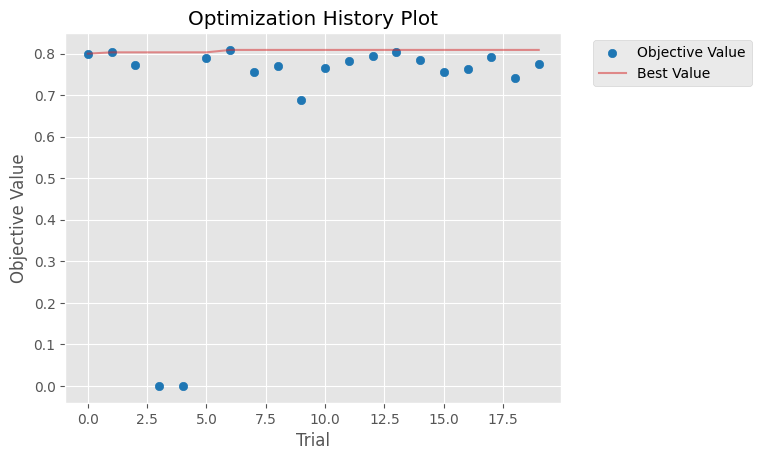

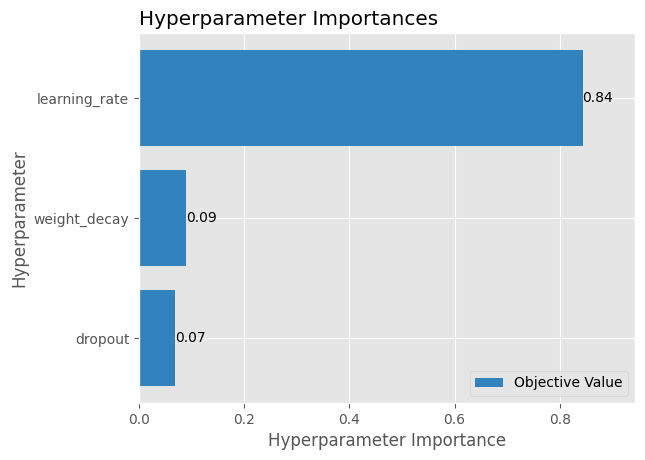

In [38]:
# Show the best parameters and best value
print(f"Best trial: \nValue: {study.best_trial.value}\nParams: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# Plotting all the results
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)


In [192]:
import matplotlib.pyplot as plt

def plot_trial_metrics(trial_number):
    trial_data = hyperparameter_dict[trial_number]
    history = trial_data["training_history"]
    
    steps = list(range(0, len(history["train_loss"]) * 100, 100))
    train_loss = history["train_loss"]
    eval_loss = history["eval_loss"]
    eval_f1 = history["eval_f1"]
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps, train_loss, label='Train Loss')
    plt.plot(steps, eval_loss, label='Eval Loss')
    plt.plot(steps, eval_f1, label='Eval F1')
    plt.xlabel('Steps')
    plt.title(f'Metrics for Trial {trial_number}')
    plt.legend()
    plt.show()

# After your Optuna study is complete:
for trial_number in hyperparameter_dict.keys():
    plot_trial_metrics(trial_number)

In [30]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(".\laoutlm3_output/checkpoint-100")

In [33]:
def getf1(example):
    image = example["image"].convert("RGB")
    words = example["tokens"]
    boxes = example["bboxes"]
    normalized_boxes = []

    for i in range(len(boxes)):
        normalized_boxes.append(normalize_box(boxes[i], image.width, image.height))


    normalized_boxes = torch.tensor(normalized_boxes, dtype=torch.long)
    
    word_labels = example["ner_tags"]
    word_labels = torch.tensor(word_labels, dtype=torch.long)

    
    encoding = processor(image, words, boxes=normalized_boxes, word_labels=word_labels,
                         truncation=True, padding="max_length", return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**encoding)
        
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    labels = encoding.labels.squeeze().tolist()
    
    true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]

    correct_predictions = sum(t == p for t, p in zip(true_labels, true_predictions))
    all_tokens = len(true_labels)
    

    return correct_predictions, all_tokens


In [ ]:
correct = 0
all_tokens = 0
for i in range(len(funsd_test_dataset)):
    ci,ai = getf1(funsd_test_dataset[i])
    correct += ci
    all_tokens += ai


In [ ]:
correct/all_tokens

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions,true_boxes ):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(label_map[label]).lower()
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [ ]:
### put an image from epant !!!!!!!!!!!!!!!!!!!!!!!!!!!!!